# Imports

In [1]:
import pandas as pd
import pyodbc
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from generalized_regression_pipeline import *
import scipy.stats as stats
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Data engineering

##### Import SAP data, stored locally 

In [2]:
excel_path = r'C:\Users\lodhasr\Projects\Mahlo\IPC.xlsx'
df_sap = pd.read_excel(excel_path, sheet_name='DATA')
df_sap = df_sap[df_sap['CD_CORE*STARTTIME'] != datetime(1, 1, 1, 0, 0, 0)]
df_sap.dropna(inplace=True)

df_sap.head()

BATCHSTART           BATCHSTOP      Line  \
0 2021-01-04 19:11:49 2021-01-04 19:40:14  LAMMONTC   
1 2021-01-04 19:40:14 2021-01-04 22:00:19  LAMMONTC   
2 2021-01-05 13:25:58 2021-01-05 14:40:19  LAMMONTH   
5 2021-01-05 23:15:59 2021-01-06 03:07:42  LAMMONTC   
6 2021-01-06 03:07:42 2021-01-06 06:45:46  LAMMONTC   

                             DESCRIPTION  NOMINALTHICKNESS       BATCH SHIFT  \
0     2.6 Flat Blk-Blk 20psi 48x48 288sf               2.6  0520000LHC     C   
1     2.6 Flat Blk-Blk 20psi 48x96 576sf               2.6  0520000LHD     C   
2  2.6 Flat Blk-Blk 20psi 48x48 576sf DP               2.6  0520000LJB     B   
5     2.6 Flat Blk-Blk 20psi 48x96 576sf               2.6  0520000LJH     A   
6     2.6 Flat Blk-Blk 20psi 48x96 576sf               2.6  0520000LJJ     A   

   RUNWETDENS  UPTIMEMINUTES    CD_CORE*STARTTIME  IP_CORE*AVG  IP_CORE1  \
0       1.772         25.000  2021-01-04 19:45:15        1.681     1.645   
1       1.771        126.433  2021-01-04 20:15:09        1.669     1.681   
2       1.735         66.850  2021-01-05 13:41:52        1.618     1.591   
5       1.779        208.967  2021-01-05 23:49:46        1.664     1.639   
6       1.778        209.533  2021-01-06 03:33:43        1.657     1.636   

   IP_CORE2  IP_CORE3  IP_CORE4  
0     1.695     1.690     1.696  
1     1.647     1.685     1.662  
2     1.599     1.635     1.646  
5     1.657     1.673     1.685  
6     1.654     1.656     1.683

#### Wonderware
##### Initialize the connection strings and connection to the server

In [3]:
server = 'PLT520WW'  # SQL Server name or IP address
database = 'Runtime'  # Database name
username = 'wwUser'  # SQL Server username
password = 'wwUser'  # SQL Server password

conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

##### Fetching data from Wonderware for a period of X minutes from the start_time parameter 

In [4]:
def fetch_density_data(start_time, line):
    """
    Fetches density data from Wonderware for a specific line within a time range.
    
    Parameters:
        start_time : datetime
            The start time for the data query.
        line : str
            The line identifier (e.g., 'Line 1', 'Line 2').
    
    Returns:
        list of tuples
            The fetched density data as a list of tuples, each representing a row in the result set.
    
    Exceptions:
        ValueError
            If the provided arguments are invalid.
        OverflowError
            If the query results in data that is too large to handle.
        Exception
            For any other unexpected errors.
    """

    
    try:
        if isinstance(start_time, str):
            start_time = datetime.strptime(start_time, '%m/%d/%Y %H:%M:%S')

        time_start = start_time - timedelta(minutes=10)
        time_end = start_time

        if line == 'LAMMONTC':
            column_prefix = 'L1'
        elif line == 'LAMMONTH':
            column_prefix = 'L2'
        else:
            print(f"Unknown line value: {line}")
            return None

        # Format the time range to match SQL Server datetime format
        time_start_str = time_start.strftime('%m/%d/%Y %H:%M:%S')
        time_end_str = time_end.strftime('%m/%d/%Y %H:%M:%S')

        # Construct the subquery for `OPENQUERY`
        subquery = f'''
        SELECT DateTime,
               [{column_prefix}_Mahlo_Zone_0_Foam_Density],
               [{column_prefix}_Mahlo_Zone_1_Foam_Density],
               [{column_prefix}_Mahlo_Zone_2_Foam_Density],
               [{column_prefix}_Mahlo_Zone_3_Foam_Density],
               [{column_prefix}_Mahlo_Zone_4_Foam_Density],
               [{column_prefix}_Mahlo_Zone_5_Foam_Density],
               [{column_prefix}_Mahlo_Zone_6_Foam_Density],
               [{column_prefix}_Mahlo_Zone_7_Foam_Density],
               [{column_prefix}_Mahlo_Zone_8_Foam_Density],
               [{column_prefix}_Mahlo_Zone_9_Foam_Density]
        FROM WideHistory 
        WHERE DateTime >= "{time_start_str}" AND DateTime <= "{time_end_str}"
        AND wwRetrievalmode = "DELTA"
        '''

        # Construct the main query using `OPENQUERY`
        query = f'''
        SELECT DateTime,
               [{column_prefix}_Mahlo_Zone_0_Foam_Density],
               [{column_prefix}_Mahlo_Zone_1_Foam_Density],
               [{column_prefix}_Mahlo_Zone_2_Foam_Density],
               [{column_prefix}_Mahlo_Zone_3_Foam_Density],
               [{column_prefix}_Mahlo_Zone_4_Foam_Density],
               [{column_prefix}_Mahlo_Zone_5_Foam_Density],
               [{column_prefix}_Mahlo_Zone_6_Foam_Density],
               [{column_prefix}_Mahlo_Zone_7_Foam_Density],
               [{column_prefix}_Mahlo_Zone_8_Foam_Density],
               [{column_prefix}_Mahlo_Zone_9_Foam_Density]
        FROM OPENQUERY(INSQL, '{subquery}')
        '''

        # Execute the query
        cursor.execute(query)

        # Fetch and return the results
        return cursor.fetchall()

    except ValueError as ve:
        print(f"ValueError: {ve}")
        return None
    except OverflowError as oe:
        print(f"OverflowError: {oe}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None


##### Calling the function to extract data from Wonderware and storing the zone densities in 2 dataframes (segregated based on the line)

In [5]:
l1=[]
l2=[]

for index, row in df_sap.iterrows():
    start_time = row['CD_CORE*STARTTIME']
    line = row['Line']
    density_data = fetch_density_data(start_time, line)
    # Append the fetched data to the all_results list
    if density_data:
        if(line=='LAMMONTC'):
            l1.extend(density_data)
        else:
            l2.extend(density_data)

In [6]:
df_l1 = pd.DataFrame([tuple(row) for row in l1],columns=['DateTime','L1 Zone 0','L1 Zone 1','L1 Zone 2','L1 Zone 3','L1 Zone 4','L1 Zone 5','L1 Zone 6','L1 Zone 7','L1 Zone 8','L1 Zone 9'])
df_l2 = pd.DataFrame([tuple(row) for row in l2],columns=['DateTime','L2 Zone 0','L2 Zone 1','L2 Zone 2','L2 Zone 3','L2 Zone 4','L2 Zone 5','L2 Zone 6','L2 Zone 7','L2 Zone 8','L2 Zone 9'])

In [7]:
df_l1

DateTime  L1 Zone 0  L1 Zone 1  L1 Zone 2  L1 Zone 3  \
0     2021-01-04 19:35:15.000        NaN        NaN        NaN        NaN   
1     2021-01-04 20:05:09.000        NaN        NaN        NaN        NaN   
2     2021-01-05 23:39:46.000        NaN        NaN        NaN        NaN   
3     2021-01-06 03:23:43.000        NaN        NaN        NaN        NaN   
4     2021-01-06 06:48:55.000        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
61987 2024-04-17 00:31:35.988    2.21619   2.204559   2.189851   2.195930   
61988 2024-04-17 00:31:36.988    2.21619   2.204559   2.189800   2.195930   
61989 2024-04-17 00:31:37.988    2.21619   2.204559   2.189800   2.195930   
61990 2024-04-17 00:31:38.988    2.21619   2.204559   2.189800   2.195930   
61991 2024-04-24 05:47:38.000    2.23326   2.222716   2.187532   2.180227   

       L1 Zone 4  L1 Zone 5  L1 Zone 6  L1 Zone 7  L1 Zone 8  L1 Zone 9  
0            NaN        NaN        NaN        NaN        NaN        NaN  
1            NaN        NaN        NaN        NaN        NaN        NaN  
2            NaN        NaN        NaN        NaN        NaN        NaN  
3            NaN        NaN        NaN        NaN        NaN        NaN  
4            NaN        NaN        NaN        NaN        NaN        NaN  
...          ...        ...        ...        ...        ...        ...  
61987   2.203476   2.210759   2.199992   2.188772   2.192856   2.186824  
61988   2.203175   2.210759   2.200144   2.188897   2.192887   2.198409  
61989   2.203175   2.210759   2.200144   2.188897   2.188412   2.200038  
61990   2.203175   2.210759   2.200144   2.192153   2.186364   2.200038  
61991   2.175684   2.200445   2.192323   2.169740   2.186810   2.222714  

[61992 rows x 11 columns]

In [8]:
df_l2

DateTime  L2 Zone 0  L2 Zone 1  L2 Zone 2  L2 Zone 3  \
0      2021-01-05 13:31:52.000        NaN        NaN        NaN        NaN   
1      2021-01-07 14:02:44.000        NaN        NaN        NaN        NaN   
2      2021-01-11 10:39:26.000        NaN        NaN        NaN        NaN   
3      2021-01-11 13:11:46.000        NaN        NaN        NaN        NaN   
4      2021-01-13 08:35:12.000        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
473829 2024-06-03 14:23:15.806   2.210655   2.217168   2.221176   2.214233   
473830 2024-06-03 14:23:16.810   2.210655   2.217168   2.221176   2.214233   
473831 2024-06-03 14:23:16.810   2.210655   2.217168   2.221176   2.214233   
473832 2024-06-04 23:16:12.000   0.000000   0.000000   0.000000   0.000000   
473833 2024-06-05 18:15:43.000   0.000000   0.000000   0.000000   0.000000   

        L2 Zone 4  L2 Zone 5  L2 Zone 6  L2 Zone 7  L2 Zone 8  L2 Zone 9  
0             NaN        NaN        NaN        NaN        NaN        NaN  
1             NaN        NaN        NaN        NaN        NaN        NaN  
2             NaN        NaN        NaN        NaN        NaN        NaN  
3             NaN        NaN        NaN        NaN        NaN        NaN  
4             NaN        NaN        NaN        NaN        NaN        NaN  
...           ...        ...        ...        ...        ...        ...  
473829   2.201264   2.202532   2.215218   2.219050   2.234081   2.256569  
473830   2.201264   2.201322   2.225771   2.231568   2.234587   2.256569  
473831   2.201264   2.201322   2.227249   2.231568   2.234587   2.256569  
473832   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
473833   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  

[473834 rows x 11 columns]

##### Computing and storing the average for a 10-minute timeframe

In [9]:
def processing(df, line):

    """
    Processes raw data by removing null values and zeros, then aggregates the data into 10-minute intervals.
    
    Parameters:
        df : pandas.DataFrame
            The raw data containing density measurements.
        line : str
            The line identifier for which the data is processed.
    
    Returns:
        pandas.DataFrame
            A DataFrame containing the average density values for each 10-minute interval.
    """
    
        
    df = df.dropna()  
    df = df[~(df == 0).any(axis=1)] 

    new_df = pd.DataFrame({
        'DateTime': df['DateTime'],
        line+' Zone 0': df[line+' Zone 0'],
        line+' Zone 1': df[line+' Zone 1'],
        line+' Zone 2': df[line+' Zone 2'],
        line+' Zone 3': df[line+' Zone 3'],
        line+' Zone 4': df[line+' Zone 4'],
        line+' Zone 5': df[line+' Zone 5'],
        line+' Zone 6': df[line+' Zone 6'],
        line+' Zone 7': df[line+' Zone 7'],
        line+' Zone 8': df[line+' Zone 8'],
        line+' Zone 9': df[line+' Zone 9']
    })
     
    results = []
    df = new_df
    start_time = new_df['DateTime'].iloc[0]
    count=0
    while not df[df['DateTime'] >= start_time].empty:
        count+=1
        end_time = start_time + timedelta(minutes=10)
        interval_df = df[(df['DateTime'] >= start_time) & (df['DateTime'] <= end_time)]
        
        # If the interval is not empty, calculate the mean of the zone values
        if not interval_df.empty:
            avg_values = interval_df.mean(numeric_only=True)
            # Reorder columns to have 'DateTime' as the first column
            avg_values = pd.concat([pd.Series({'DateTime': end_time}), avg_values])
            results.append(avg_values)
        
        # Get the next start time for the following interval
        next_start_time = df[df['DateTime'] > end_time]['DateTime'].min()
        if pd.isna(next_start_time):
            break
        start_time = next_start_time
    
    new_df = pd.DataFrame(results)
    print(count)
    # Reset the index of the result dataframe
    new_df.reset_index(drop=True, inplace=True)
    
    # Display the result dataframe
    # print(new_df)
    return new_df


In [10]:
df_l1 = processing(df_l1, 'L1')
df_l2 = processing(df_l2, 'L2')

146
1227


In [11]:
df_l1

DateTime  L1 Zone 0  L1 Zone 1  L1 Zone 2  L1 Zone 3  \
0   2022-01-08 16:48:19   2.161245   2.163765   2.155238   2.148194   
1   2022-01-08 20:51:54   2.149674   2.145366   2.141920   2.133903   
2   2022-01-10 00:28:35   2.188040   2.186360   2.179523   2.158435   
3   2022-01-10 19:45:51   2.148869   2.142990   2.112148   2.098338   
4   2022-01-21 22:25:35   2.198606   2.199191   2.188503   2.167289   
..                  ...        ...        ...        ...        ...   
141 2024-04-08 01:27:14   2.236243   2.243878   2.226434   2.215775   
142 2024-04-12 13:19:09   2.244243   2.226483   2.212024   2.198737   
143 2024-04-12 15:59:11   2.159086   2.161598   2.157917   2.154789   
144 2024-04-17 00:31:39   2.235522   2.227513   2.210985   2.203571   
145 2024-04-24 05:57:38   2.233260   2.222716   2.187532   2.180227   

     L1 Zone 4  L1 Zone 5  L1 Zone 6  L1 Zone 7  L1 Zone 8  L1 Zone 9  
0     2.156981   2.203472   2.215945   2.191433   2.139990   2.125858  
1     2.154569   2.200383   2.214186   2.194584   2.146303   2.137786  
2     2.165845   2.175485   2.166259   2.182360   2.182052   2.167635  
3     2.112934   2.146004   2.150650   2.166002   2.170003   2.174059  
4     2.176022   2.199233   2.201601   2.214438   2.217121   2.215067  
..         ...        ...        ...        ...        ...        ...  
141   2.215772   2.215611   2.204682   2.215358   2.216880   2.201684  
142   2.198014   2.195588   2.186786   2.183452   2.198733   2.187314  
143   2.164087   2.169436   2.169076   2.185169   2.195014   2.197496  
144   2.200243   2.211618   2.205166   2.198885   2.200200   2.203139  
145   2.175684   2.200445   2.192323   2.169740   2.186810   2.222714  

[146 rows x 11 columns]

In [12]:
df_l2

DateTime  L2 Zone 0  L2 Zone 1  L2 Zone 2  L2 Zone 3  \
0    2022-01-06 12:48:06   2.187186   2.176557   2.161335   2.150839   
1    2022-01-06 22:39:47   2.193074   2.195938   2.196310   2.189075   
2    2022-01-07 01:27:33   2.182750   2.196814   2.203600   2.196590   
3    2022-01-07 04:41:11   2.151023   2.152147   2.160370   2.163024   
4    2022-01-07 08:10:45   2.184784   2.169310   2.154919   2.142793   
...                  ...        ...        ...        ...        ...   
1222 2024-05-31 19:49:36   2.242766   2.236101   2.234539   2.237179   
1223 2024-06-03 05:14:53   2.203340   2.189125   2.179781   2.184388   
1224 2024-06-03 08:33:32   2.218236   2.207626   2.199768   2.197609   
1225 2024-06-03 11:17:26   2.211585   2.191809   2.181250   2.179631   
1226 2024-06-03 14:23:17   2.222297   2.205255   2.197567   2.198477   

      L2 Zone 4  L2 Zone 5  L2 Zone 6  L2 Zone 7  L2 Zone 8  L2 Zone 9  
0      2.154810   2.161338   2.168175   2.190162   2.213701   2.230420  
1      2.179820   2.171643   2.167987   2.166574   2.164809   2.165998  
2      2.178017   2.158759   2.146926   2.139983   2.144652   2.157973  
3      2.160486   2.146787   2.142044   2.163901   2.177995   2.178710  
4      2.124303   2.128541   2.156988   2.180210   2.202130   2.221086  
...         ...        ...        ...        ...        ...        ...  
1222   2.244640   2.254857   2.261276   2.256130   2.244155   2.242247  
1223   2.190475   2.202836   2.214649   2.218837   2.223310   2.227510  
1224   2.191183   2.193278   2.201851   2.205478   2.218365   2.243509  
1225   2.179751   2.188584   2.200776   2.211956   2.224530   2.235761  
1226   2.197975   2.211117   2.227653   2.229417   2.234986   2.248656  

[1227 rows x 11 columns]

##### Integrating the data from SAP and Wonderware to get a final dataset per line

In [13]:
df_sap['CD_CORE*STARTTIME'] = pd.to_datetime(df_sap['CD_CORE*STARTTIME'])

# Filter the relevant columns and rename to match the zones processing
df_l1_additional = df_sap[df_sap['Line'] == 'LAMMONTC'][['CD_CORE*STARTTIME', 'IP_CORE*AVG', 'IP_CORE1', 'IP_CORE2', 'IP_CORE3', 'IP_CORE4']]
df_l2_additional = df_sap[df_sap['Line'] == 'LAMMONTH'][['CD_CORE*STARTTIME', 'IP_CORE*AVG', 'IP_CORE1', 'IP_CORE2', 'IP_CORE3', 'IP_CORE4']]

# Merge the dataframes on DateTime
df_l1_final = pd.merge(df_l1, df_l1_additional, left_on='DateTime', right_on='CD_CORE*STARTTIME', how='left')
df_l2_final = pd.merge(df_l2, df_l2_additional, left_on='DateTime', right_on='CD_CORE*STARTTIME', how='left')

# Select and reorder the columns for L1
df_l1_final = df_l1_final[['DateTime', 'L1 Zone 0', 'L1 Zone 1', 'L1 Zone 2', 'L1 Zone 3', 'L1 Zone 4', 'L1 Zone 5', 
                           'L1 Zone 6', 'L1 Zone 7', 'L1 Zone 8', 'L1 Zone 9', 'IP_CORE*AVG', 'IP_CORE1', 'IP_CORE2', 
                           'IP_CORE3', 'IP_CORE4']]

# Select and reorder the columns for L2
df_l2_final = df_l2_final[['DateTime', 'L2 Zone 0', 'L2 Zone 1', 'L2 Zone 2', 'L2 Zone 3', 'L2 Zone 4', 'L2 Zone 5', 
                           'L2 Zone 6', 'L2 Zone 7', 'L2 Zone 8', 'L2 Zone 9', 'IP_CORE*AVG', 'IP_CORE1', 'IP_CORE2', 
                           'IP_CORE3', 'IP_CORE4']]

df_l1_final.dropna(inplace=True)
df_l2_final.dropna(inplace=True)

# Display the final dataframes
print("L1 Final DataFrame")
print(df_l1_final)

print("\nL2 Final DataFrame")
print(df_l2_final.head())

L1 Final DataFrame
               DateTime  L1 Zone 0  L1 Zone 1  L1 Zone 2  L1 Zone 3  \
0   2022-01-08 16:48:19   2.161245   2.163765   2.155238   2.148194   
1   2022-01-08 20:51:54   2.149674   2.145366   2.141920   2.133903   
2   2022-01-10 00:28:35   2.188040   2.186360   2.179523   2.158435   
3   2022-01-10 19:45:51   2.148869   2.142990   2.112148   2.098338   
4   2022-01-21 22:25:35   2.198606   2.199191   2.188503   2.167289   
..                  ...        ...        ...        ...        ...   
141 2024-04-08 01:27:14   2.236243   2.243878   2.226434   2.215775   
142 2024-04-12 13:19:09   2.244243   2.226483   2.212024   2.198737   
143 2024-04-12 15:59:11   2.159086   2.161598   2.157917   2.154789   
144 2024-04-17 00:31:39   2.235522   2.227513   2.210985   2.203571   
145 2024-04-24 05:57:38   2.233260   2.222716   2.187532   2.180227   

     L1 Zone 4  L1 Zone 5  L1 Zone 6  L1 Zone 7  L1 Zone 8  L1 Zone 9  \
0     2.156981   2.203472   2.215945   2.191433   2.139

##### Checking the initial correlation in the data

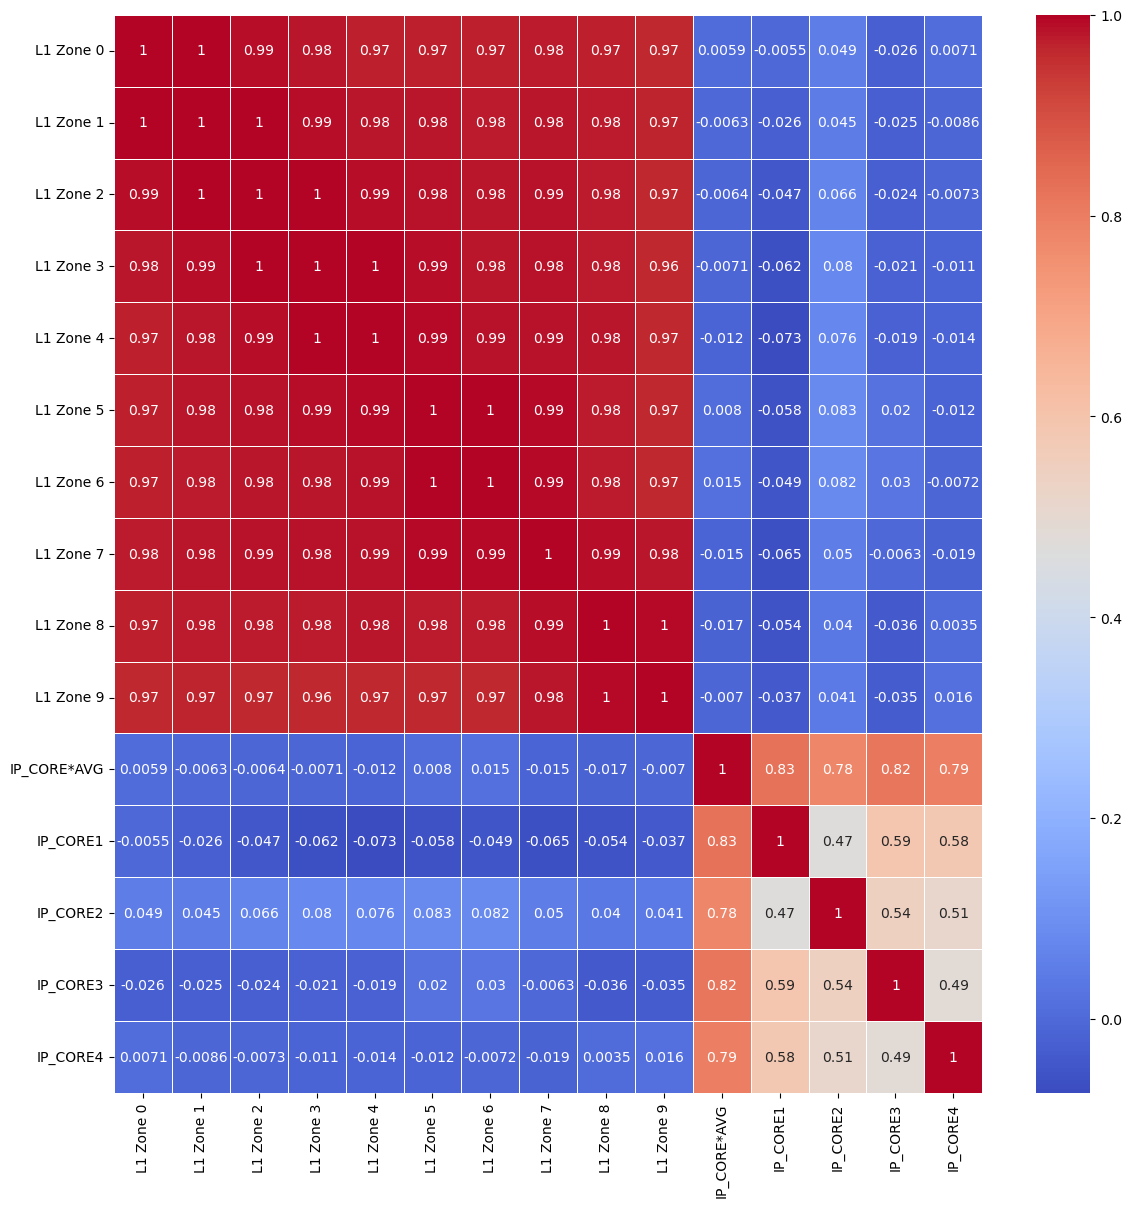

In [14]:
# Compute the correlation matrix
correlation_matrix = df_l1_final.drop(columns=['DateTime']).corr()

# Create the heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# Display the heatmap
plt.show()

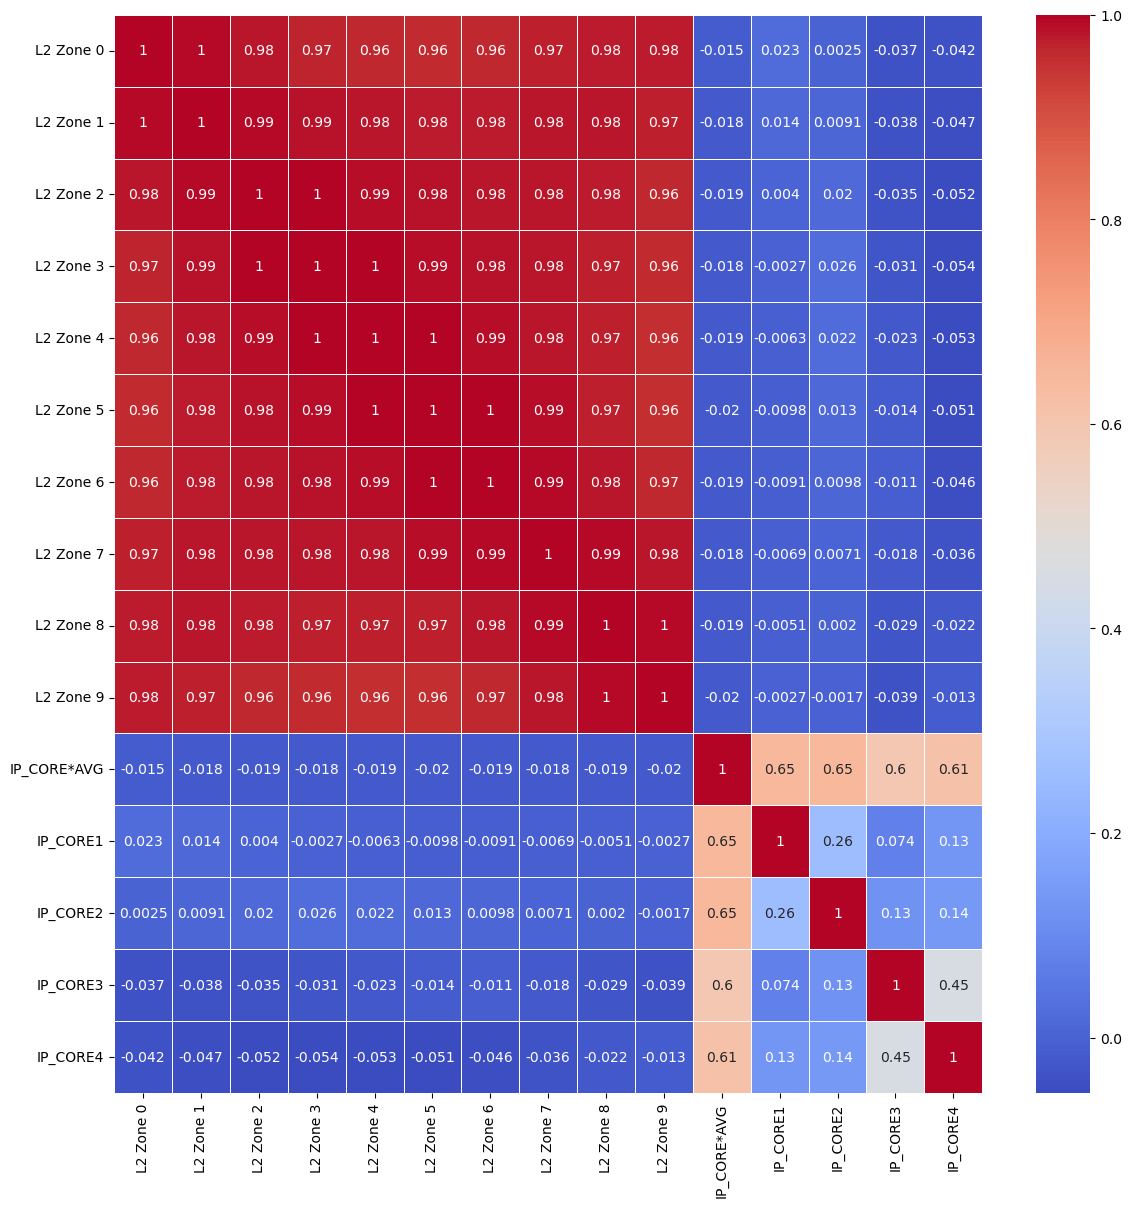

In [15]:
# Compute the correlation matrix
correlation_matrix = df_l2_final.drop(columns=['DateTime']).corr()

# Create the heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# Display the heatmap
plt.show()

##### Computing average densities based on zones

In [16]:
# For L1 Final DataFrame
df_l1_new = df_l1_final.copy()
df_l1_new['L1 Zones 1-4'] = df_l1_new[['L1 Zone 1', 'L1 Zone 2', 'L1 Zone 3', 'L1 Zone 4']].mean(axis=1)
df_l1_new['L1 Zones 5-8'] = df_l1_new[['L1 Zone 5', 'L1 Zone 6', 'L1 Zone 7', 'L1 Zone 8']].mean(axis=1)

df_l1_new = df_l1_new[['DateTime', 'L1 Zone 0', 'L1 Zones 1-4', 'L1 Zones 5-8', 'L1 Zone 9']]

# For L2 Final DataFrame
df_l2_new = df_l2_final.copy()
df_l2_new['L2 Zones 1-4'] = df_l2_new[['L2 Zone 1', 'L2 Zone 2', 'L2 Zone 3', 'L2 Zone 4']].mean(axis=1)
df_l2_new['L2 Zones 5-8'] = df_l2_new[['L2 Zone 5', 'L2 Zone 6', 'L2 Zone 7', 'L2 Zone 8']].mean(axis=1)

df_l2_new = df_l2_new[['DateTime', 'L2 Zone 0', 'L2 Zones 1-4', 'L2 Zones 5-8', 'L2 Zone 9']]

# Display the new dataframes
print("L1 New DataFrame")
print(df_l1_new)

print("\nL2 New DataFrame")
print(df_l2_new)


L1 New DataFrame
               DateTime  L1 Zone 0  L1 Zones 1-4  L1 Zones 5-8  L1 Zone 9
0   2022-01-08 16:48:19   2.161245      2.156044      2.187710   2.125858
1   2022-01-08 20:51:54   2.149674      2.143940      2.188864   2.137786
2   2022-01-10 00:28:35   2.188040      2.172541      2.176539   2.167635
3   2022-01-10 19:45:51   2.148869      2.116602      2.158165   2.174059
4   2022-01-21 22:25:35   2.198606      2.182751      2.208098   2.215067
..                  ...        ...           ...           ...        ...
141 2024-04-08 01:27:14   2.236243      2.225464      2.213133   2.201684
142 2024-04-12 13:19:09   2.244243      2.208814      2.191140   2.187314
143 2024-04-12 15:59:11   2.159086      2.159598      2.179674   2.197496
144 2024-04-17 00:31:39   2.235522      2.210578      2.203967   2.203139
145 2024-04-24 05:57:38   2.233260      2.191540      2.187329   2.222714

[144 rows x 5 columns]

L2 New DataFrame
                DateTime  L2 Zone 0  L2 Zones 1-4  L2

In [17]:
df_l1_new

DateTime  L1 Zone 0  L1 Zones 1-4  L1 Zones 5-8  L1 Zone 9
0   2022-01-08 16:48:19   2.161245      2.156044      2.187710   2.125858
1   2022-01-08 20:51:54   2.149674      2.143940      2.188864   2.137786
2   2022-01-10 00:28:35   2.188040      2.172541      2.176539   2.167635
3   2022-01-10 19:45:51   2.148869      2.116602      2.158165   2.174059
4   2022-01-21 22:25:35   2.198606      2.182751      2.208098   2.215067
..                  ...        ...           ...           ...        ...
141 2024-04-08 01:27:14   2.236243      2.225464      2.213133   2.201684
142 2024-04-12 13:19:09   2.244243      2.208814      2.191140   2.187314
143 2024-04-12 15:59:11   2.159086      2.159598      2.179674   2.197496
144 2024-04-17 00:31:39   2.235522      2.210578      2.203967   2.203139
145 2024-04-24 05:57:38   2.233260      2.191540      2.187329   2.222714

[144 rows x 5 columns]

In [18]:
df_l2_new.head()

DateTime  L2 Zone 0  L2 Zones 1-4  L2 Zones 5-8  L2 Zone 9
0 2022-01-06 12:48:06   2.187186      2.160885      2.183344   2.230420
1 2022-01-06 22:39:47   2.193074      2.190286      2.167753   2.165998
2 2022-01-07 01:27:33   2.182750      2.193755      2.147580   2.157973
3 2022-01-07 04:41:11   2.151023      2.159007      2.157682   2.178710
4 2022-01-07 08:10:45   2.184784      2.147831      2.166967   2.221086

In [19]:
# Convert DateTime columns to datetime64[ns] in new_df_l1, new_df_l2, and df
df_l1_new['DateTime'] = pd.to_datetime(df_l1_new['DateTime'])
df_l2_new['DateTime'] = pd.to_datetime(df_l2_new['DateTime'])

# Define the mappings
zone_columns_l1 = ['L1 Zone 0', 'L1 Zones 1-4', 'L1 Zones 5-8', 'L1 Zone 9']
zone_columns_l2 = ['L2 Zone 0', 'L2 Zones 1-4', 'L2 Zones 5-8', 'L2 Zone 9']
ip_core_columns = ['IP_CORE1', 'IP_CORE2', 'IP_CORE3', 'IP_CORE4']

# Merge new_df_l1 and new_df_l2 with df on the DateTime column
merged_l1 = pd.merge(df_l1_new, df_sap, left_on='DateTime', right_on='CD_CORE*STARTTIME')
merged_l2 = pd.merge(df_l2_new, df_sap, left_on='DateTime', right_on='CD_CORE*STARTTIME')

# Create the new dataframes for L1 and L2 using loops
new_dataframes_l1 = {}
new_dataframes_l2 = {}

for i in range(4):
    new_dataframes_l1[f'L1_IP_CORE_{i+1}'] = merged_l1[['DateTime', zone_columns_l1[i], ip_core_columns[i]]]
    new_dataframes_l1[f'L1_IP_CORE_{i+1}'].columns = ['DateTime', 'Zone', 'IP_CORE']

    new_dataframes_l2[f'L2_IP_CORE_{i+1}'] = merged_l2[['DateTime', zone_columns_l2[i], ip_core_columns[i]]]
    new_dataframes_l2[f'L2_IP_CORE_{i+1}'].columns = ['DateTime', 'Zone', 'IP_CORE']

# Now new_dataframes_l1 and new_dataframes_l2 contain the required dataframes


In [20]:
new_dataframes_l1

{'L1_IP_CORE_1':                DateTime      Zone  IP_CORE
 0   2022-01-08 16:48:19  2.161245    1.580
 1   2022-01-08 20:51:54  2.149674    1.654
 2   2022-01-10 00:28:35  2.188040    1.616
 3   2022-01-10 19:45:51  2.148869    1.650
 4   2022-01-21 22:25:35  2.198606    1.638
 ..                  ...       ...      ...
 139 2024-04-08 01:27:14  2.236243    1.657
 140 2024-04-12 13:19:09  2.244243    1.628
 141 2024-04-12 15:59:11  2.159086    1.582
 142 2024-04-17 00:31:39  2.235522    1.638
 143 2024-04-24 05:57:38  2.233260    1.656
 
 [144 rows x 3 columns],
 'L1_IP_CORE_2':                DateTime      Zone  IP_CORE
 0   2022-01-08 16:48:19  2.156044    1.705
 1   2022-01-08 20:51:54  2.143940    1.652
 2   2022-01-10 00:28:35  2.172541    1.617
 3   2022-01-10 19:45:51  2.116602    1.601
 4   2022-01-21 22:25:35  2.182751    1.636
 ..                  ...       ...      ...
 139 2024-04-08 01:27:14  2.225464    1.612
 140 2024-04-12 13:19:09  2.208814    1.625
 141 2024-04-12 1

In [21]:
new_dataframes_l2

{'L2_IP_CORE_1':                 DateTime      Zone  IP_CORE
 0    2022-01-06 12:48:06  2.187186    1.575
 1    2022-01-06 22:39:47  2.193074    1.559
 2    2022-01-07 01:27:33  2.182750    1.562
 3    2022-01-07 04:41:11  2.151023    1.605
 4    2022-01-07 08:10:45  2.184784    1.556
 ...                  ...       ...      ...
 1204 2024-05-31 19:49:36  2.242766    1.598
 1205 2024-06-03 05:14:53  2.203340    1.620
 1206 2024-06-03 08:33:32  2.218236    1.565
 1207 2024-06-03 11:17:26  2.211585    1.571
 1208 2024-06-03 14:23:17  2.222297    1.578
 
 [1209 rows x 3 columns],
 'L2_IP_CORE_2':                 DateTime      Zone  IP_CORE
 0    2022-01-06 12:48:06  2.160885    1.558
 1    2022-01-06 22:39:47  2.190286    1.612
 2    2022-01-07 01:27:33  2.193755    1.621
 3    2022-01-07 04:41:11  2.159007    1.589
 4    2022-01-07 08:10:45  2.147831    1.546
 ...                  ...       ...      ...
 1204 2024-05-31 19:49:36  2.238115    1.594
 1205 2024-06-03 05:14:53  2.185942    1

##### Export the two final files which contain all the mapped inline and in-process densities

In [22]:
df_l1_final.to_excel("df_l1_final.xlsx")
df_l2_final.to_excel("df_l2_final.xlsx")

# Checkpoint

##### Storing the results for a 10-minute timeframe locally
##### Each sheet is a core-zone mapping, segregated by the line

In [23]:
with pd.ExcelWriter('output_10 minute timeframe.xlsx') as writer:
    # Loop through new_dataframes_l2 dictionary
    for key in new_dataframes_l2:
        # Write each dataframe to a separate sheet
        new_dataframes_l2[key].to_excel(writer, sheet_name=key)
    
    # Loop through new_dataframes_l1 dictionary
    for key in new_dataframes_l1:
        # Write each dataframe to a separate sheet
        new_dataframes_l1[key].to_excel(writer, sheet_name=key)

##### Fetch thickness data from Wonderware

In [24]:
def fetch_thickness_data(time, line):

    """
    Fetches thickness data from Wonderware for a specific line within a time range.
    
    Parameters:
        time : datetime
            The time for which thickness data is requested.
        line : str
            The line identifier.
    
    Returns:
        list of tuples
            The fetched thickness data as a list of tuples, each representing a row in the result set.
    """


    try:
        if isinstance(time, str):
            time = datetime.strptime(time, '%m/%d/%Y %H:%M:%S')
            
        if line == 'LAMMONTC':
            column_prefix = 'L1'
        elif line == 'LAMMONTH':
            column_prefix = 'L2'
        else:
            print(f"Unknown line value: {line}")
            return None

        # Format the time range to match SQL Server datetime format
        timestamps_str = time.strftime('%m/%d/%Y %H:%M:%S')

        # Construct the subquery for `OPENQUERY`
        subquery = f'''
        SELECT DateTime,
               [{column_prefix}_Mahlo_Zone_0_Thickness],
               [{column_prefix}_Mahlo_Zone_1_Thickness],
               [{column_prefix}_Mahlo_Zone_2_Thickness],
               [{column_prefix}_Mahlo_Zone_3_Thickness],
               [{column_prefix}_Mahlo_Zone_4_Thickness],
               [{column_prefix}_Mahlo_Zone_5_Thickness],
               [{column_prefix}_Mahlo_Zone_6_Thickness],
               [{column_prefix}_Mahlo_Zone_7_Thickness],
               [{column_prefix}_Mahlo_Zone_8_Thickness],
               [{column_prefix}_Mahlo_Zone_9_Thickness]
        FROM WideHistory 
        WHERE DateTime = "{timestamps_str}"
        AND wwRetrievalmode = "DELTA"
        '''

        # Construct the main query using `OPENQUERY`
        query = f'''
        SELECT DateTime,
               [{column_prefix}_Mahlo_Zone_0_Thickness],
               [{column_prefix}_Mahlo_Zone_1_Thickness],
               [{column_prefix}_Mahlo_Zone_2_Thickness],
               [{column_prefix}_Mahlo_Zone_3_Thickness],
               [{column_prefix}_Mahlo_Zone_4_Thickness],
               [{column_prefix}_Mahlo_Zone_5_Thickness],
               [{column_prefix}_Mahlo_Zone_6_Thickness],
               [{column_prefix}_Mahlo_Zone_7_Thickness],
               [{column_prefix}_Mahlo_Zone_8_Thickness],
               [{column_prefix}_Mahlo_Zone_9_Thickness]
        FROM OPENQUERY(INSQL, '{subquery}')
        '''
        # Execute the query
        cursor.execute(query)

        # Fetch and return the results
        return cursor.fetchall()

    except ValueError as ve:
        print(f"ValueError: {ve}")
        return None
    except OverflowError as oe:
        print(f"OverflowError: {oe}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None


##### Segregate and plot thickness data by the line

In [25]:
# Extract unique timestamps
timestamps_l1 = df_l1_final['DateTime'].unique()
timestamps_l2 = df_l2_final['DateTime'].unique()

timestamps_l1, timestamps_l2

(<DatetimeArray>
 ['2022-01-08 16:48:19', '2022-01-08 20:51:54', '2022-01-10 00:28:35',
  '2022-01-10 19:45:51', '2022-01-21 22:25:35', '2022-01-22 02:23:11',
  '2022-01-22 04:34:26', '2022-01-22 06:37:17', '2022-01-29 20:24:51',
  '2022-02-08 08:53:14',
  ...
  '2024-02-07 08:43:13', '2024-02-22 00:00:29', '2024-02-22 03:21:09',
  '2024-03-23 12:28:27', '2024-03-28 01:25:44', '2024-04-08 01:27:14',
  '2024-04-12 13:19:09', '2024-04-12 15:59:11', '2024-04-17 00:31:39',
  '2024-04-24 05:57:38']
 Length: 144, dtype: datetime64[ns],
 <DatetimeArray>
 ['2022-01-06 12:48:06', '2022-01-06 22:39:47', '2022-01-07 01:27:33',
  '2022-01-07 04:41:11', '2022-01-07 08:10:45', '2022-01-07 22:26:37',
  '2022-01-08 07:08:22', '2022-01-08 10:55:59', '2022-01-11 16:24:27',
  '2022-01-11 18:55:39',
  ...
  '2024-05-29 09:37:16', '2024-05-30 06:31:34', '2024-05-30 09:29:49',
  '2024-05-31 13:03:28', '2024-05-31 16:30:08', '2024-05-31 19:49:36',
  '2024-06-03 05:14:53', '2024-06-03 08:33:32', '2024-06-03 1

In [26]:
def get_thickness(line):

    """
    Retrieves, organizes, and plots the thickness data for a given line.
    
    Parameters:
        line : str
            The line identifier.
    
    Returns:
        pandas.DataFrame
            The thickness data for the specified line.
    """

    
    timestamps = timestamps_l1
    if(line == "LAMMONTH"):
        timestamps = timestamps_l2
    results= [] 
    for time in timestamps:
        result = fetch_thickness_data(time, line)
        results.append(result)
    # for result in results:
    #     print(result)
    
    temp = [result[0] for result in results]
    temp = [list(t) for t in temp]
    if(line == "LAMMONTC"):
        line = "L1 "
    else:
        line = "L2 "
    thickness = pd.DataFrame(temp, columns=["DateTime", line+"Zone 0", line+"Zone 1", line+"Zone 2", line+"Zone 3", line+"Zone 4", line+"Zone 5", line+"Zone 6", line+"Zone 7", line+"Zone 8", line+"Zone 9"])
    print(thickness.describe())
    
    plt.figure(figsize=(15, 20))
    for i in range(1, 11):
        plt.subplot(5, 2, i)
        plt.scatter(thickness['DateTime'], thickness[line+f'Zone {i-1}'])
        plt.title(f'Scatter Plot of Zone {i-1} vs. datetime')
        plt.xlabel('DateTime')
        plt.ylabel(f'Zone {i-1}')
        plt.grid(True)
        plt.xticks(rotation=45)
    
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()

    return thickness
            

                            DateTime   L1 Zone 0   L1 Zone 1   L1 Zone 2  \
count                            144  144.000000  144.000000  144.000000   
mean   2022-12-19 09:53:57.638888960    2.537254    2.534735    2.532411   
min              2022-01-08 16:48:19    0.945241    0.936921    0.927799   
25%    2022-08-07 11:07:18.750000128    2.448638    2.445812    2.443161   
50%       2022-12-11 04:36:36.500000    2.462402    2.460006    2.456538   
75%    2023-05-30 01:39:13.750000128    2.485962    2.479915    2.476629   
max              2024-04-24 05:57:38    3.443233    3.507216    3.603531   
std                              NaN    0.358519    0.365740    0.378448   

        L1 Zone 3   L1 Zone 4   L1 Zone 5   L1 Zone 6   L1 Zone 7   L1 Zone 8  \
count  144.000000  144.000000  144.000000  144.000000  144.000000  144.000000   
mean     2.535642    2.539101    2.542384    2.553683    2.565973    2.582031   
min      0.927022    0.923327    0.926941    0.927448    0.929076    0.9

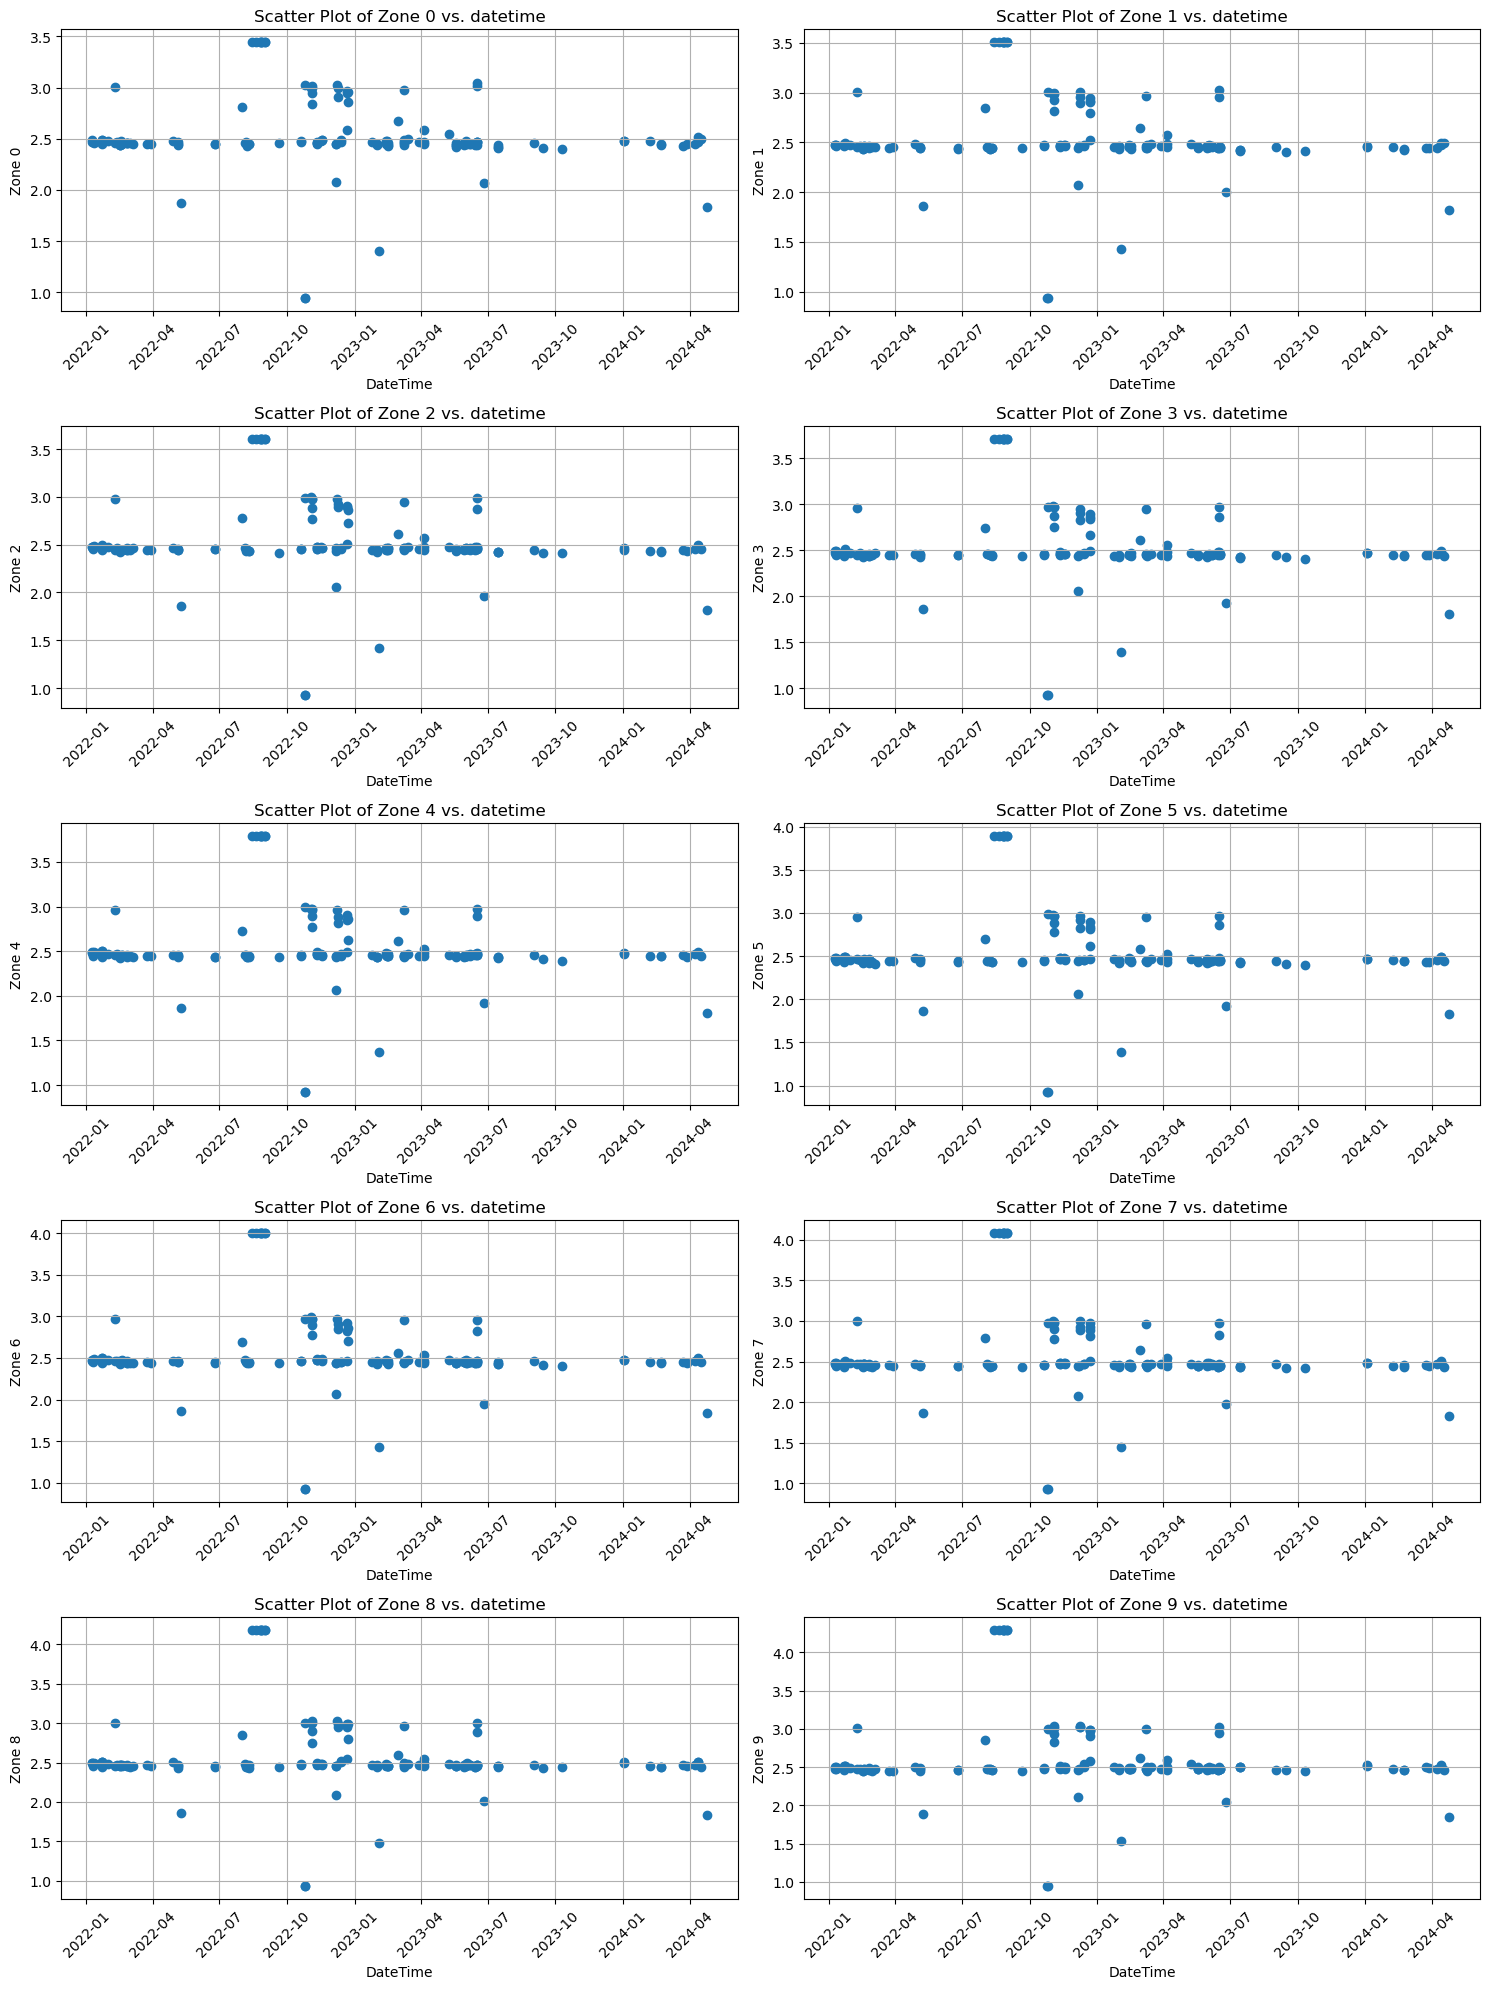

In [27]:
l1_thickness = get_thickness("LAMMONTC")

                            DateTime    L2 Zone 0    L2 Zone 1    L2 Zone 2  \
count                           1209  1209.000000  1209.000000  1209.000000   
mean   2022-12-20 12:26:51.965260544     2.558194     2.558406     2.552189   
min              2022-01-06 12:48:06     0.000000     0.000000     0.000000   
25%              2022-05-12 20:07:23     2.471591     2.477300     2.473470   
50%              2022-09-16 09:07:48     2.489032     2.493508     2.489987   
75%              2023-07-17 18:25:15     2.512795     2.516295     2.513469   
max              2024-06-03 14:23:17     4.283056     4.295129     4.291411   
std                              NaN     0.259824     0.251940     0.247490   

         L2 Zone 3    L2 Zone 4    L2 Zone 5    L2 Zone 6    L2 Zone 7  \
count  1209.000000  1209.000000  1209.000000  1209.000000  1209.000000   
mean      2.551890     2.547983     2.539534     2.533298     2.533160   
min       0.000000     0.000000     0.000000     0.000000     0.00

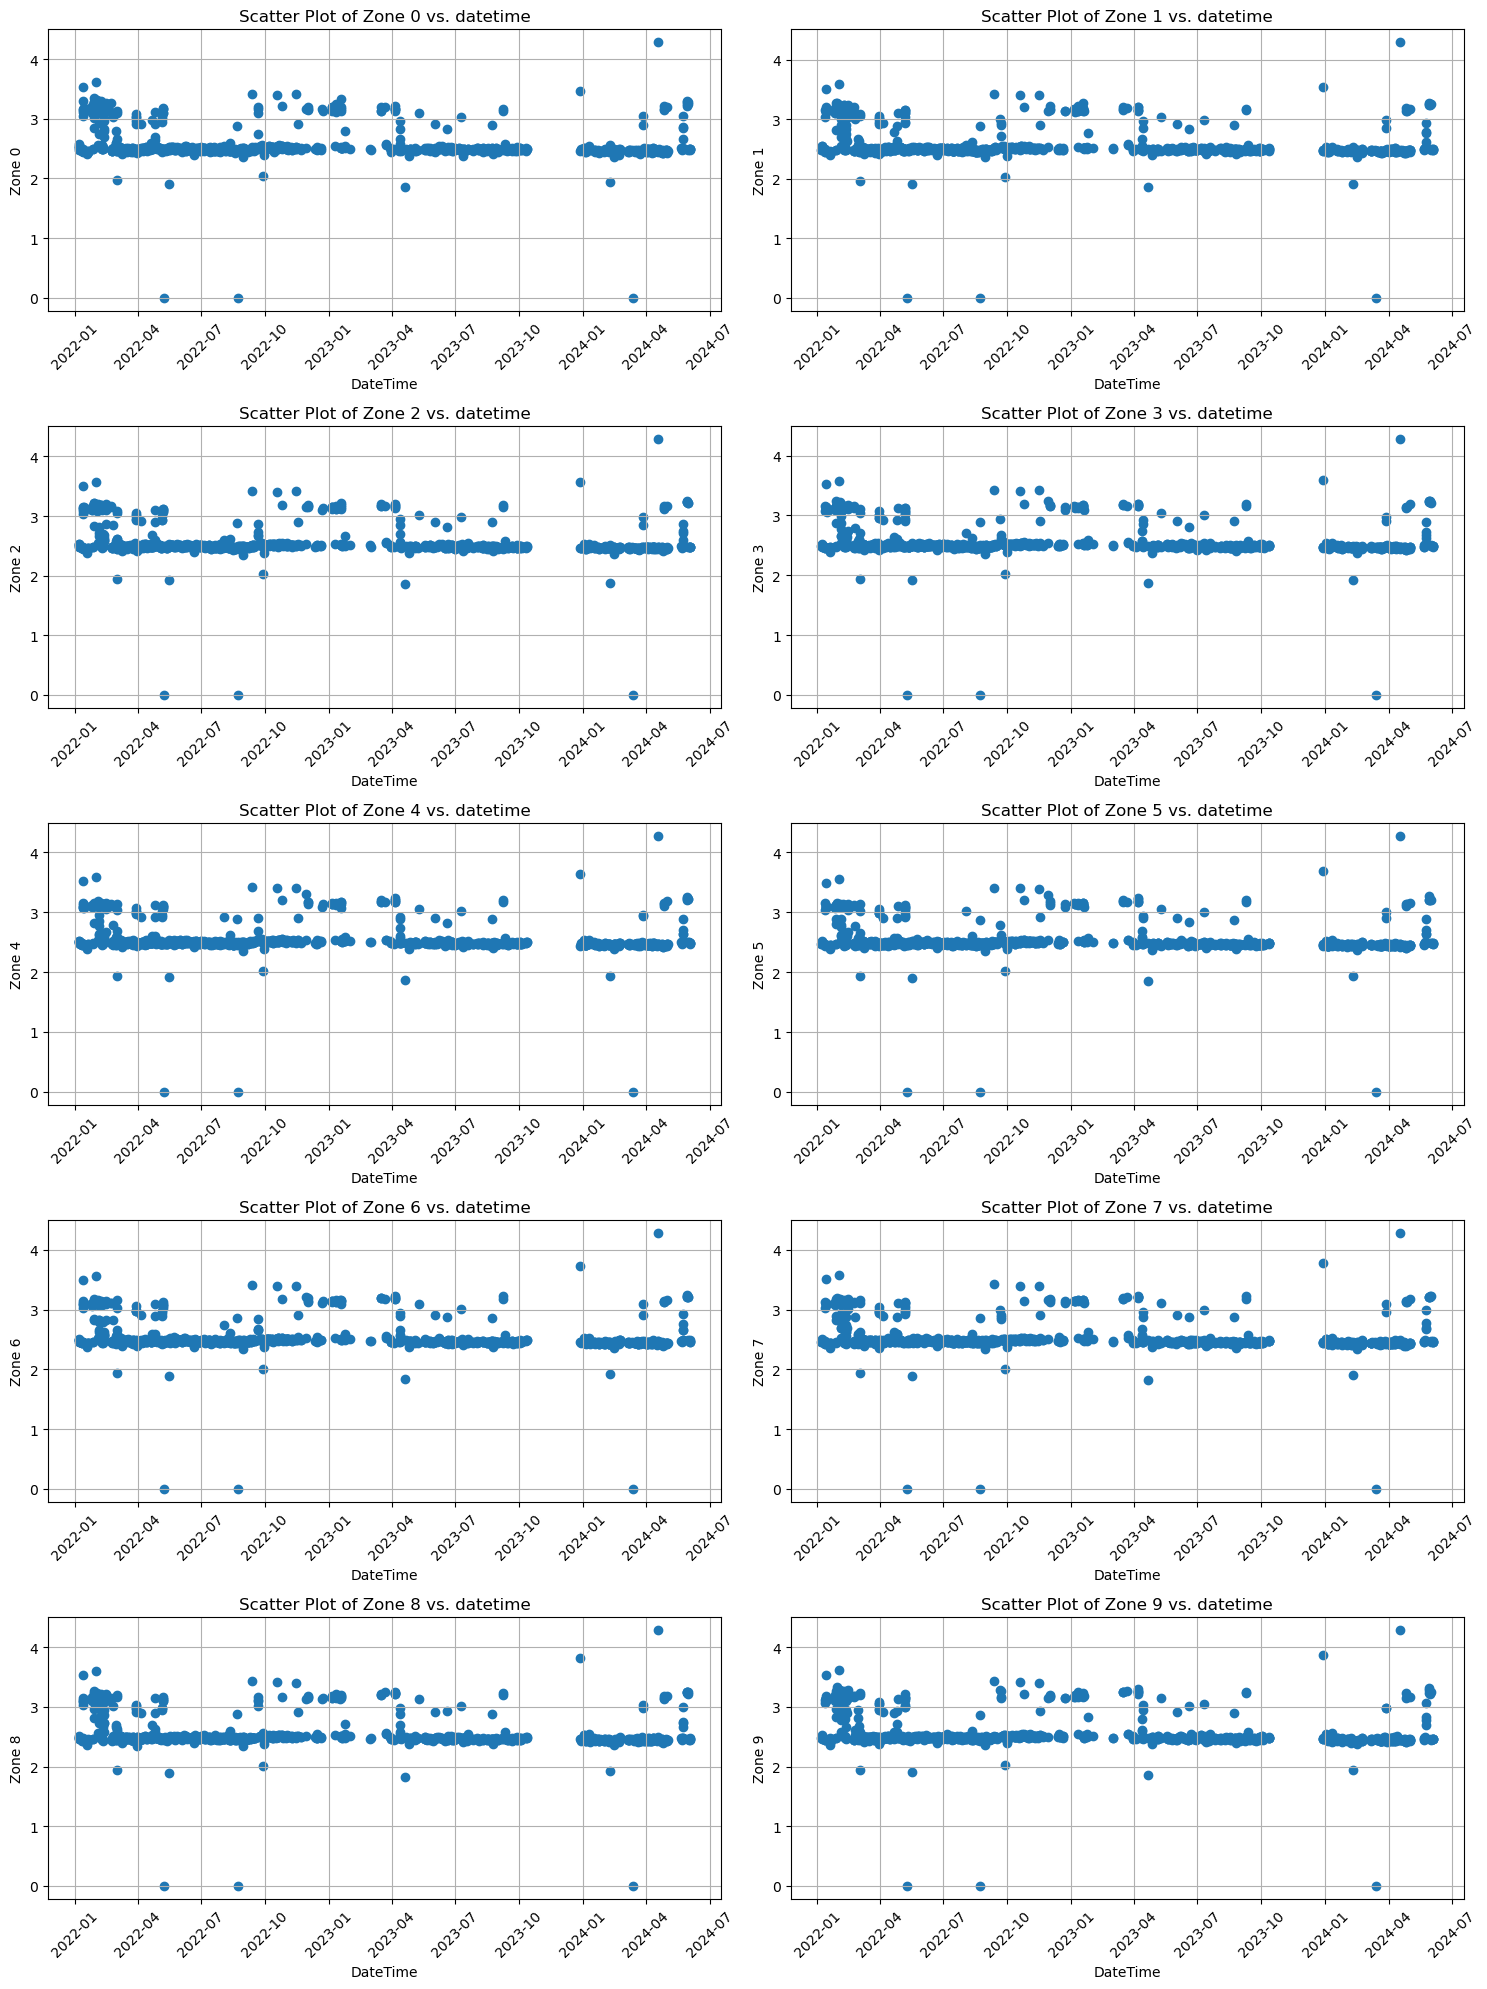

In [28]:
l2_thickness = get_thickness("LAMMONTH")

# EDA

##### Explore the initial correlation in the data

In [29]:
def plot_heatmap(df):

    """
    Plots a heatmap for the given DataFrame to visualize the correlation between different zones/respective features.
    
    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the data to be plotted.
    
    Returns:
        None
    """

    
    correlation_matrix = df.corr()
    # Create the heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"size": 8})
    
    # Display the heatmap
    plt.show()


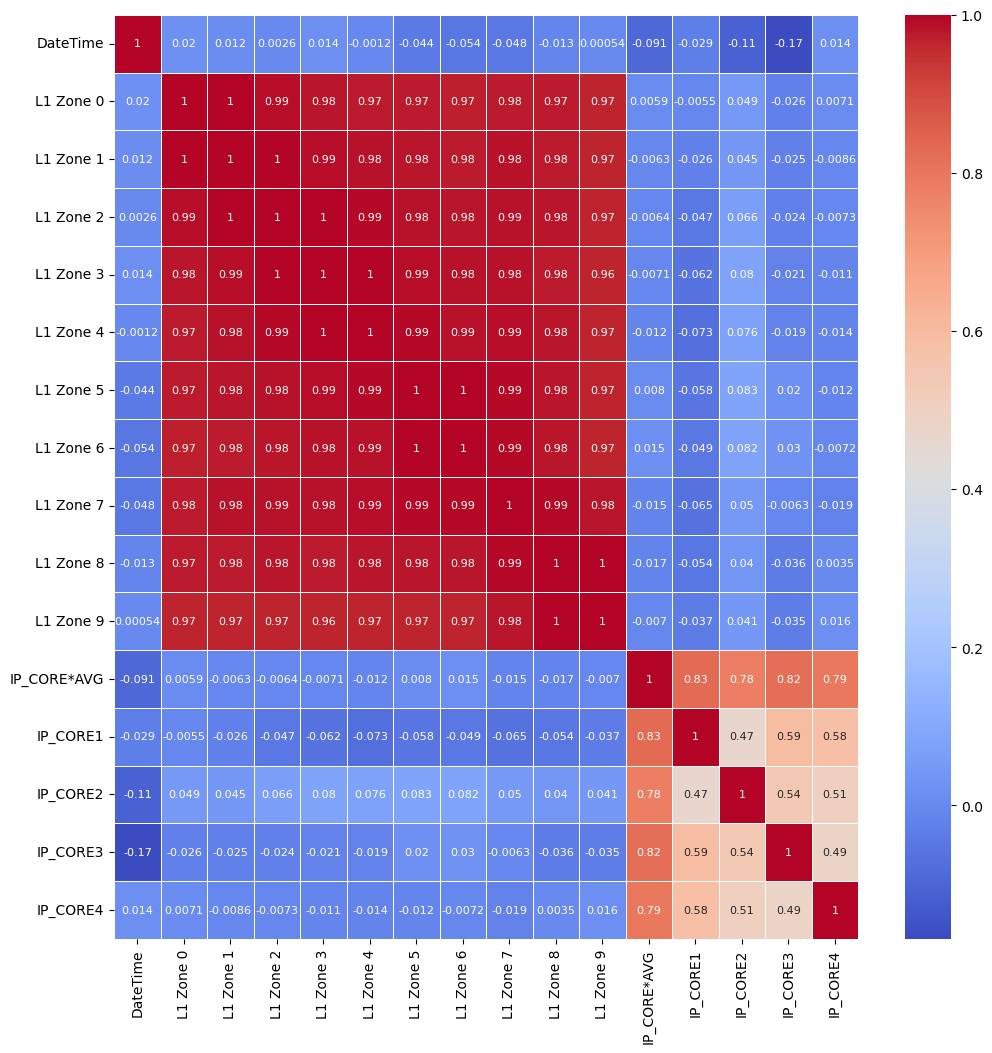

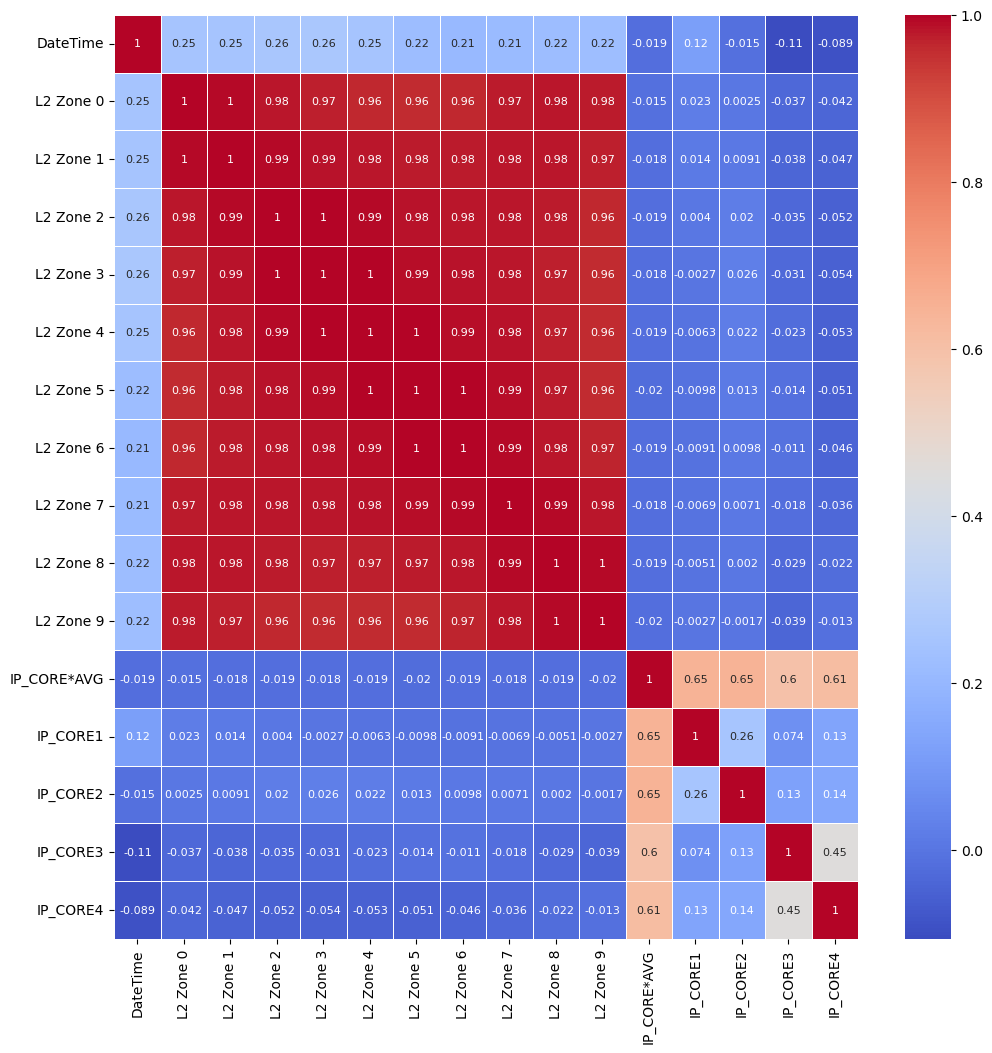

In [30]:
plot_heatmap(df_l1_final)
plot_heatmap(df_l2_final)

##### Plot the frequency distribution for all the zones and cores

In [31]:
def plot_density(df):

    """
    Plots the frequency distribution for the features in the given dataframe.
    
    Parameters:
        df : pandas.DataFrame
            The DataFrame containing density data.
    
    Returns:
        None
    """

    
    # Set up the plotting style
    sns.set(style="whitegrid")
    
    # Extract zone and IP core columns
    zone_columns = [col for col in df.columns if 'Zone'  in col]
    ip_core_columns = [col for col in df.columns if 'IP_CORE' in col]
    
    # Define the number of plots per row
    plots_per_row = 4
    
    # Plot histograms and density plots for each zone (non-normalized)
    fig, axes = plt.subplots(nrows=(len(zone_columns) + plots_per_row - 1) // plots_per_row, ncols=plots_per_row, figsize=(20, 20))
    axes = axes.flatten()
    
    for i, zone in enumerate(zone_columns):
        sns.histplot(df[zone], kde=True, ax=axes[i], stat="count")
        axes[i].set_title(f'Histogram and Density Plot for {zone}')
        axes[i].set_xlabel(zone)
        axes[i].set_ylabel('Frequency')
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    # Plot histograms and density plots for each IP core (non-normalized)
    fig, axes = plt.subplots(nrows=(len(ip_core_columns) + plots_per_row - 1) // plots_per_row, ncols=plots_per_row, figsize=(20, 20))
    axes = axes.flatten()
    
    for i, ip_core in enumerate(ip_core_columns):
        sns.histplot(df[ip_core], kde=True, ax=axes[i], stat="count")
        axes[i].set_title(f'Histogram and Density Plot for {ip_core}')
        axes[i].set_xlabel(ip_core)
        axes[i].set_ylabel('Frequency')
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


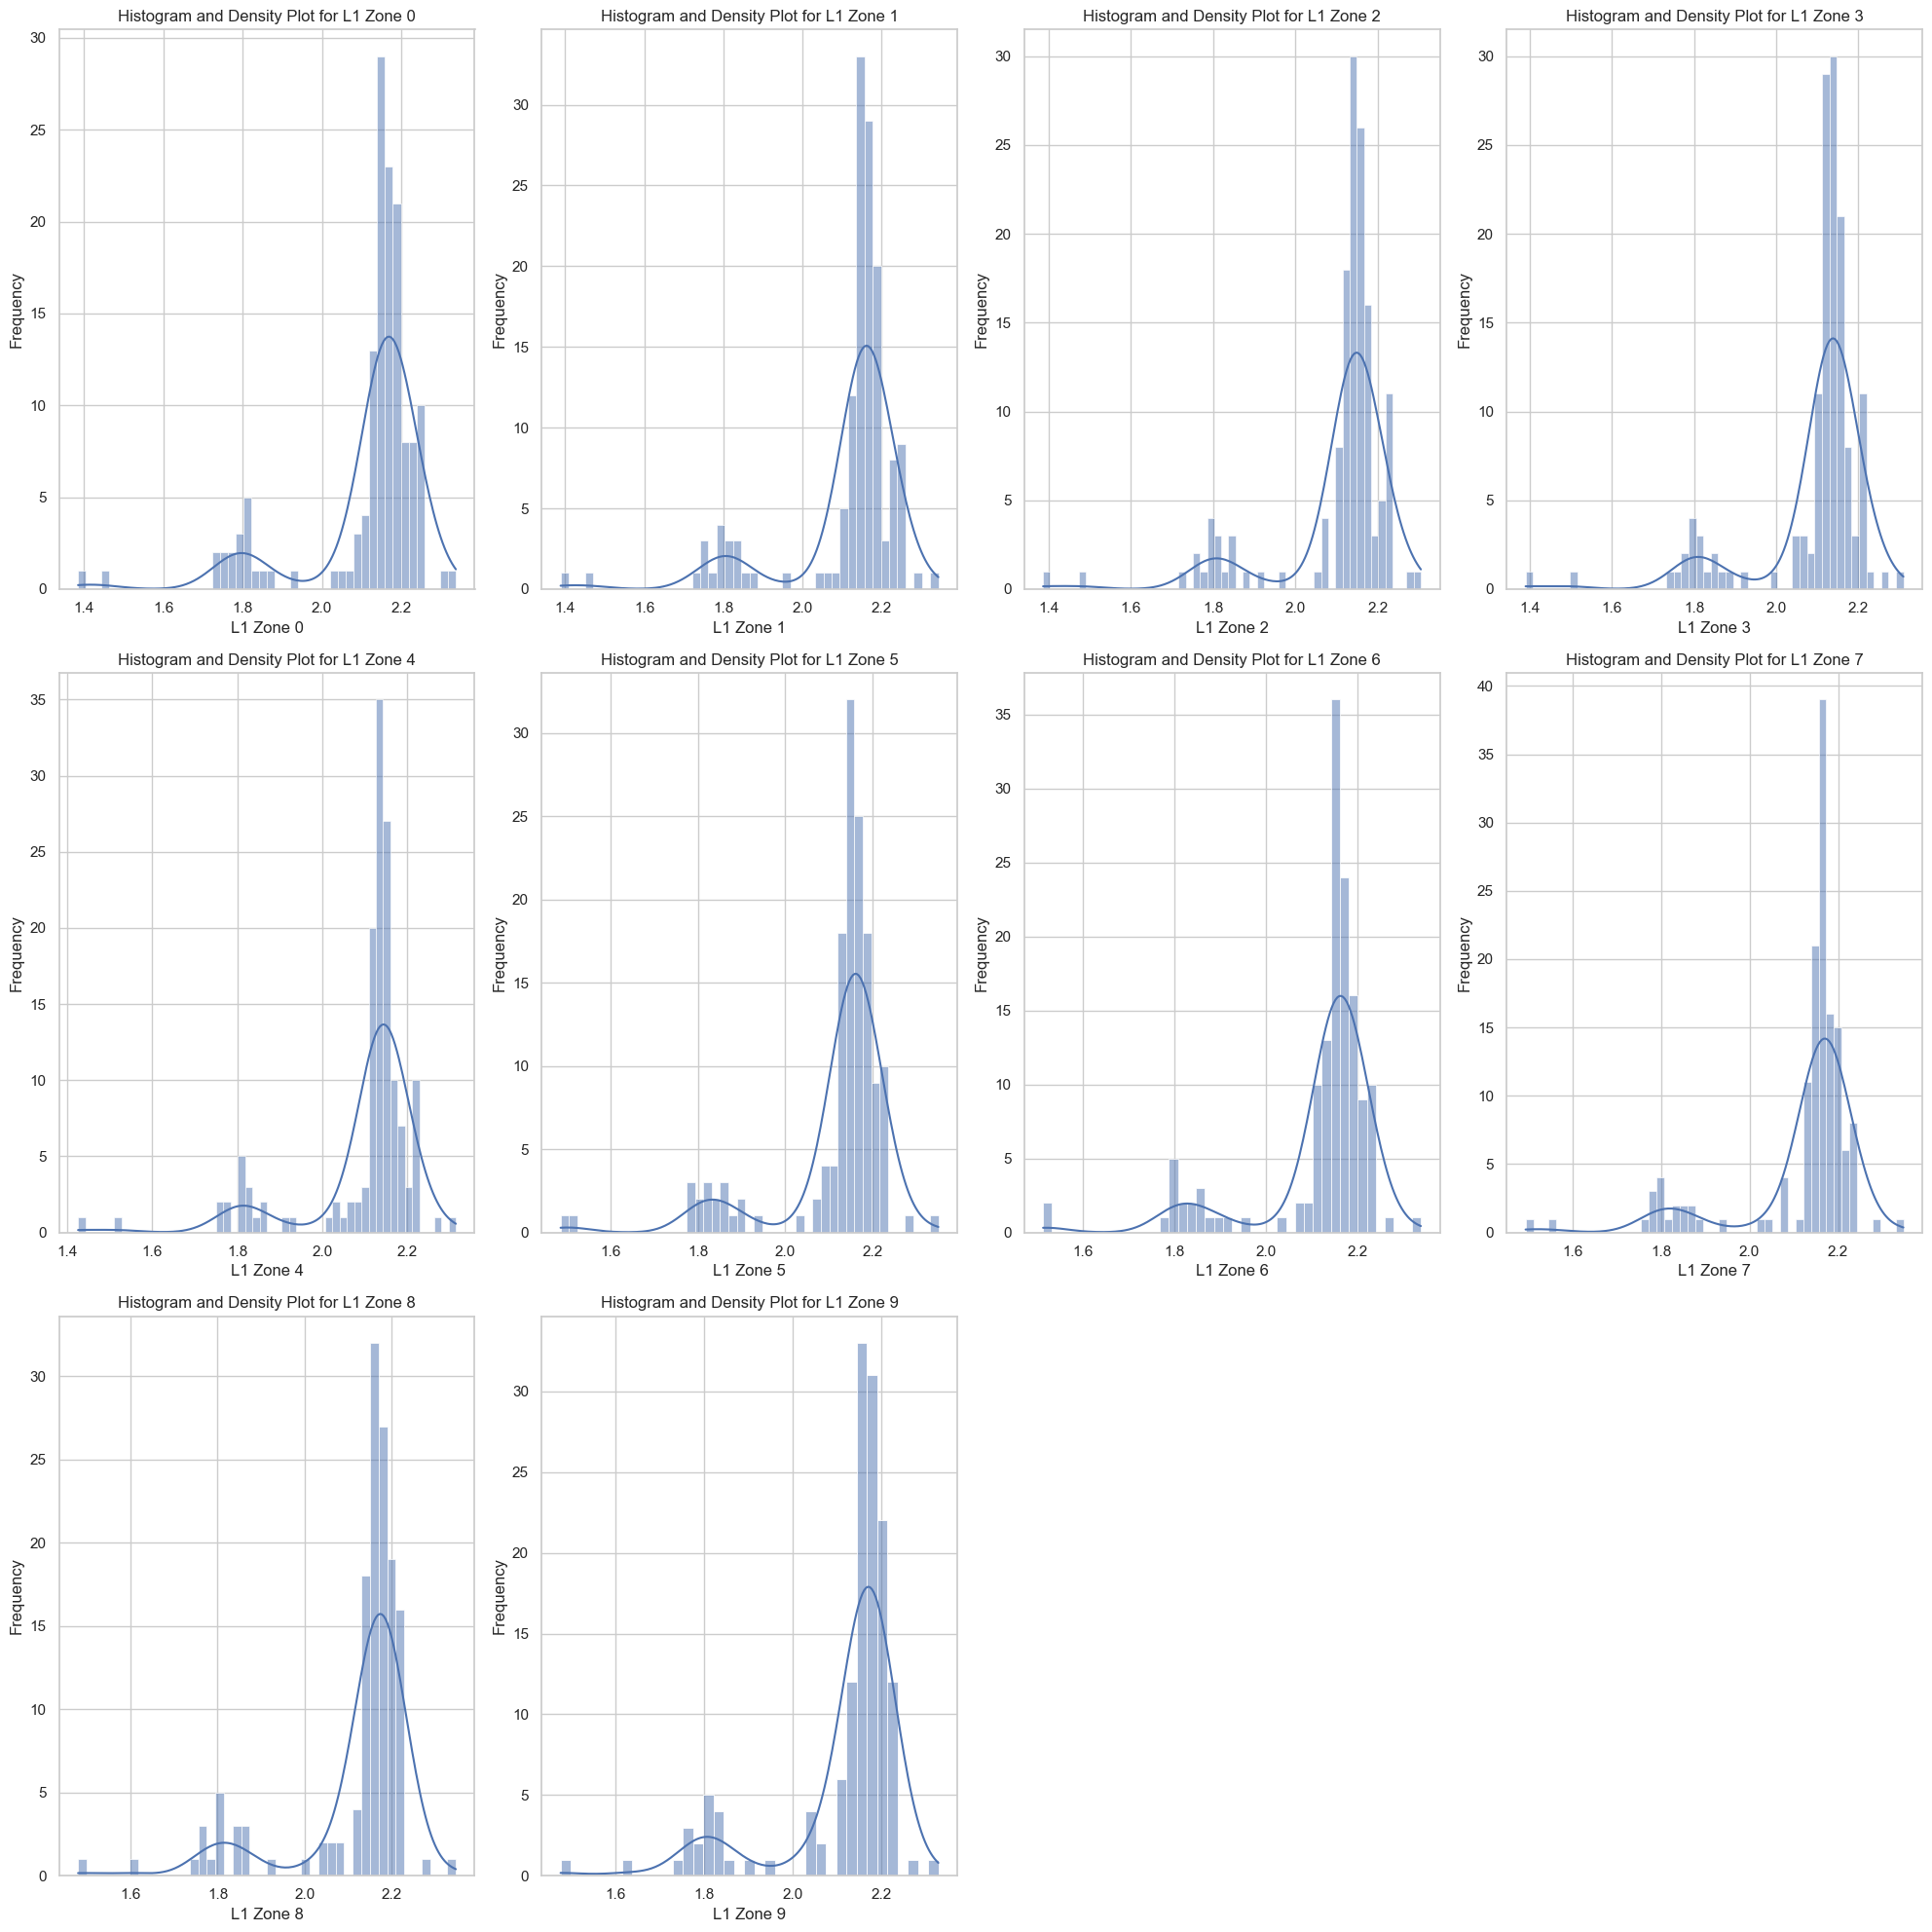

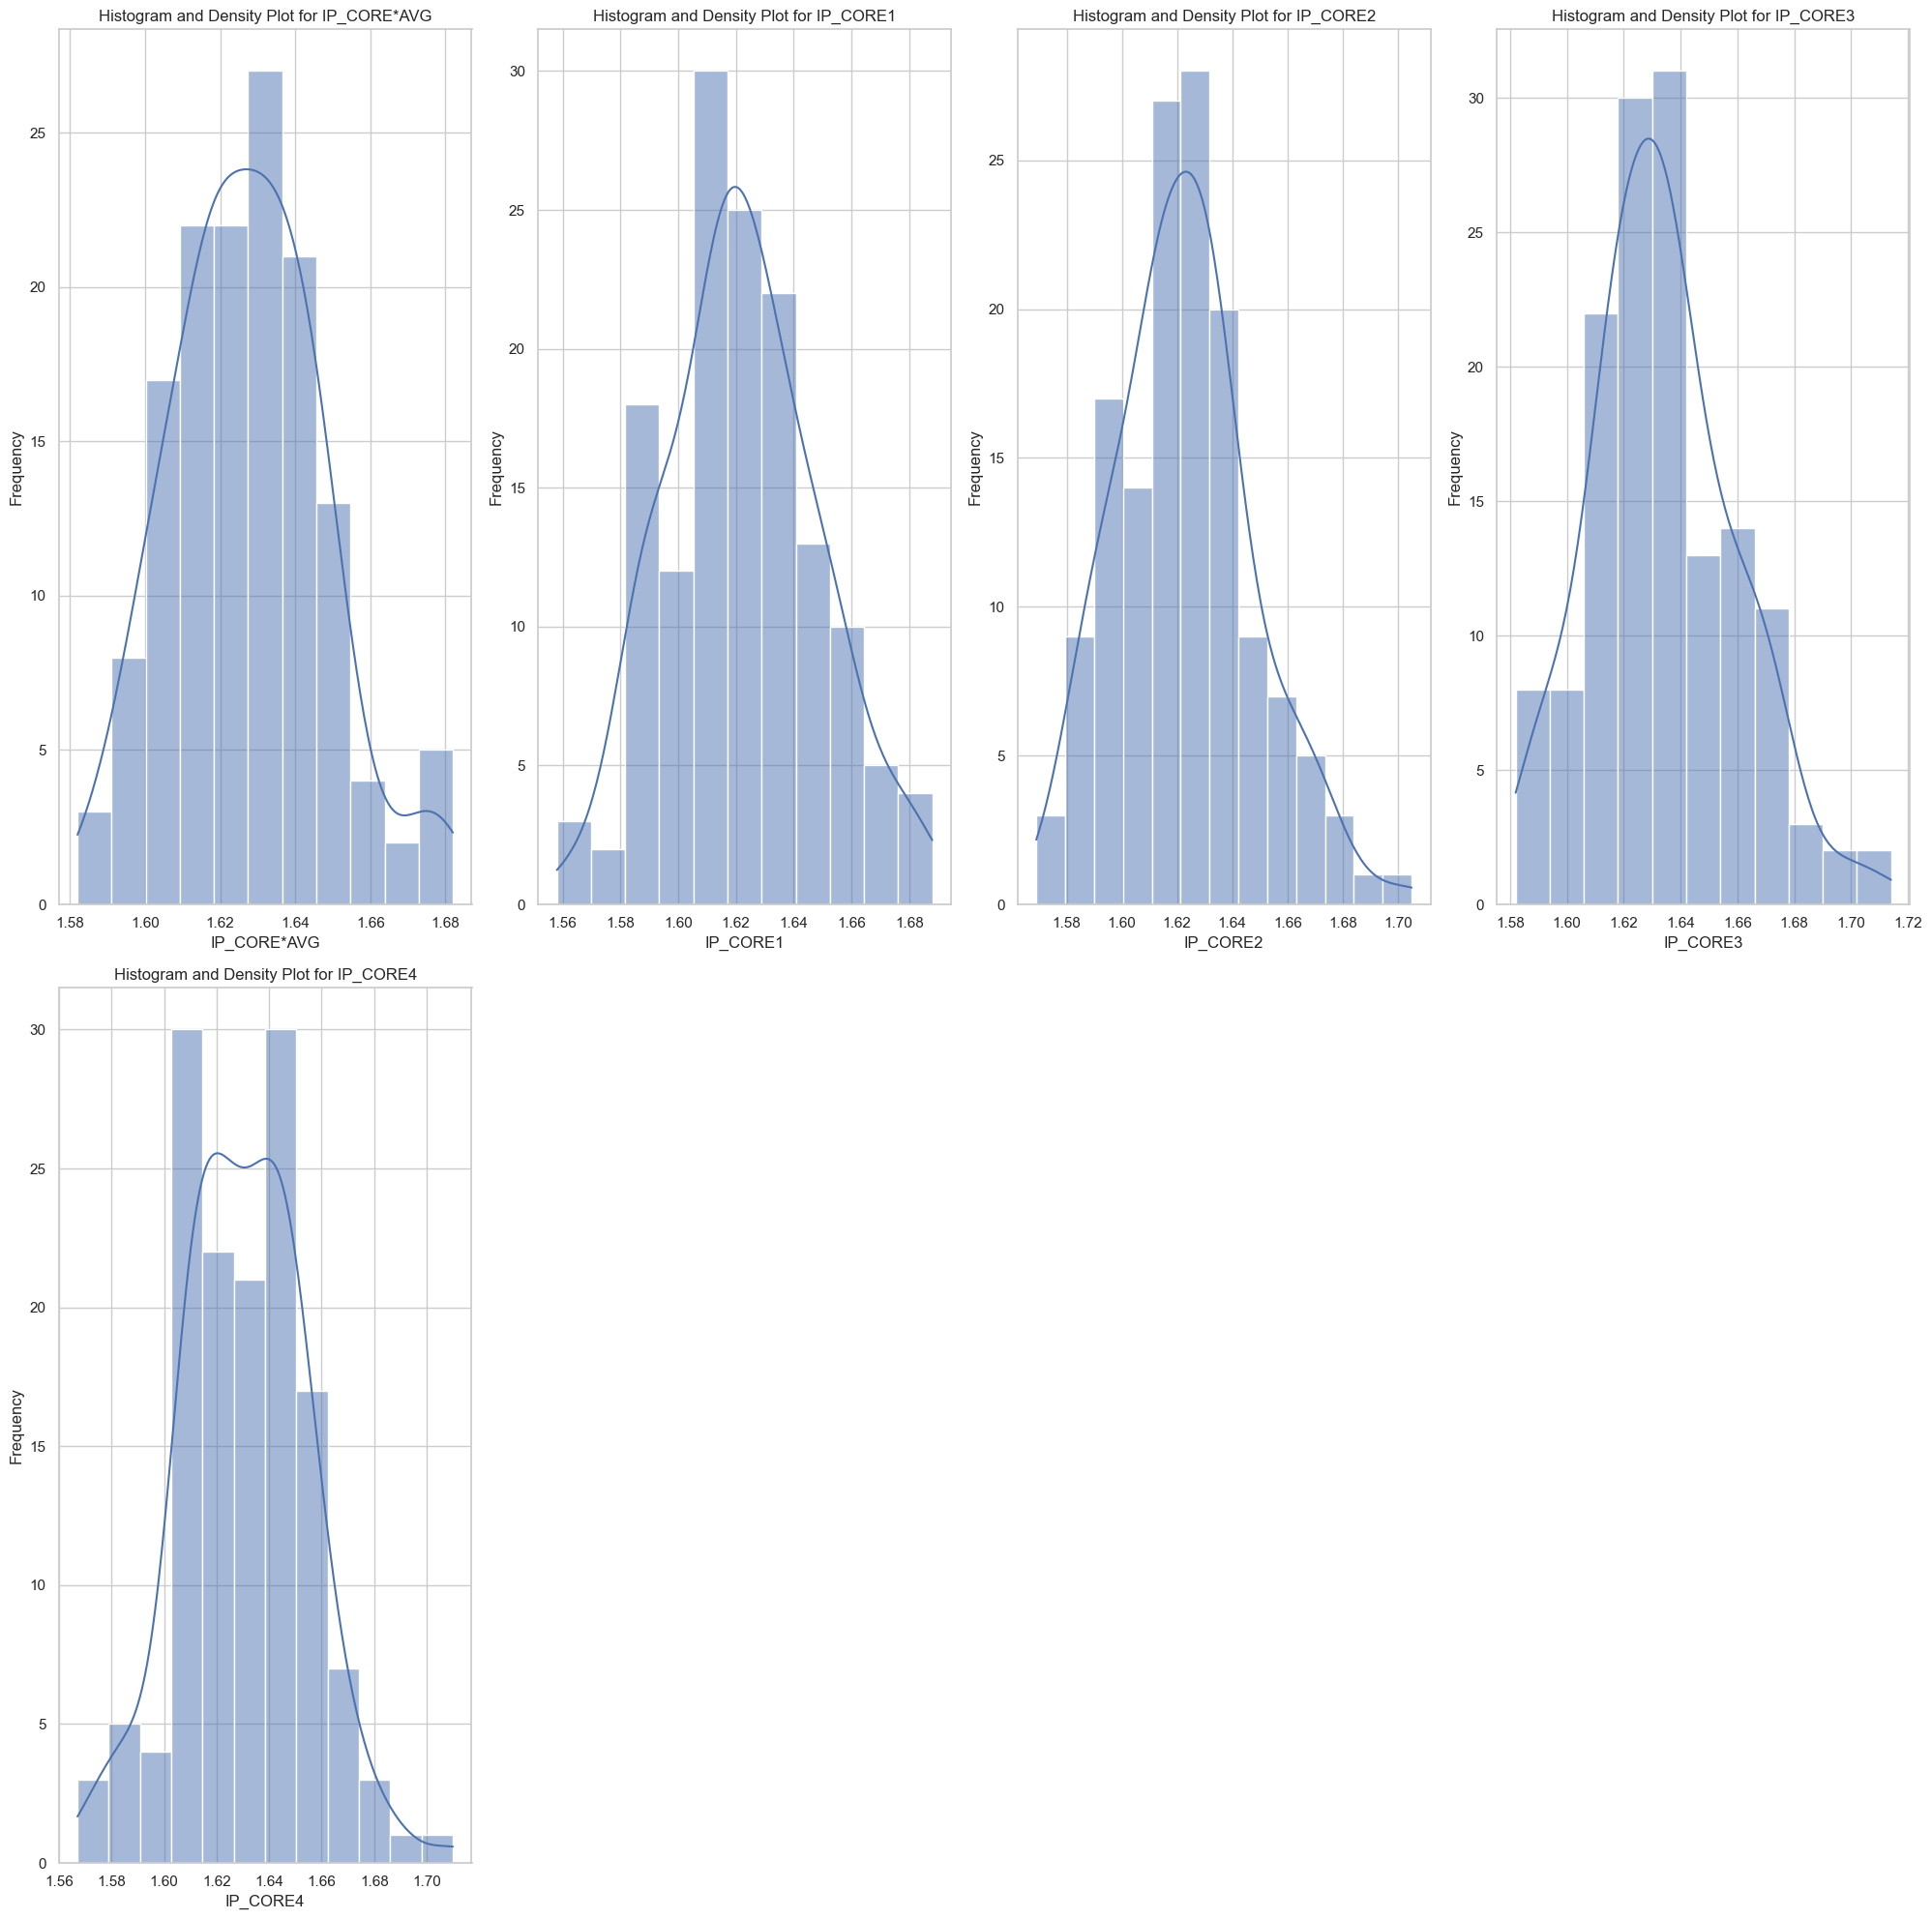

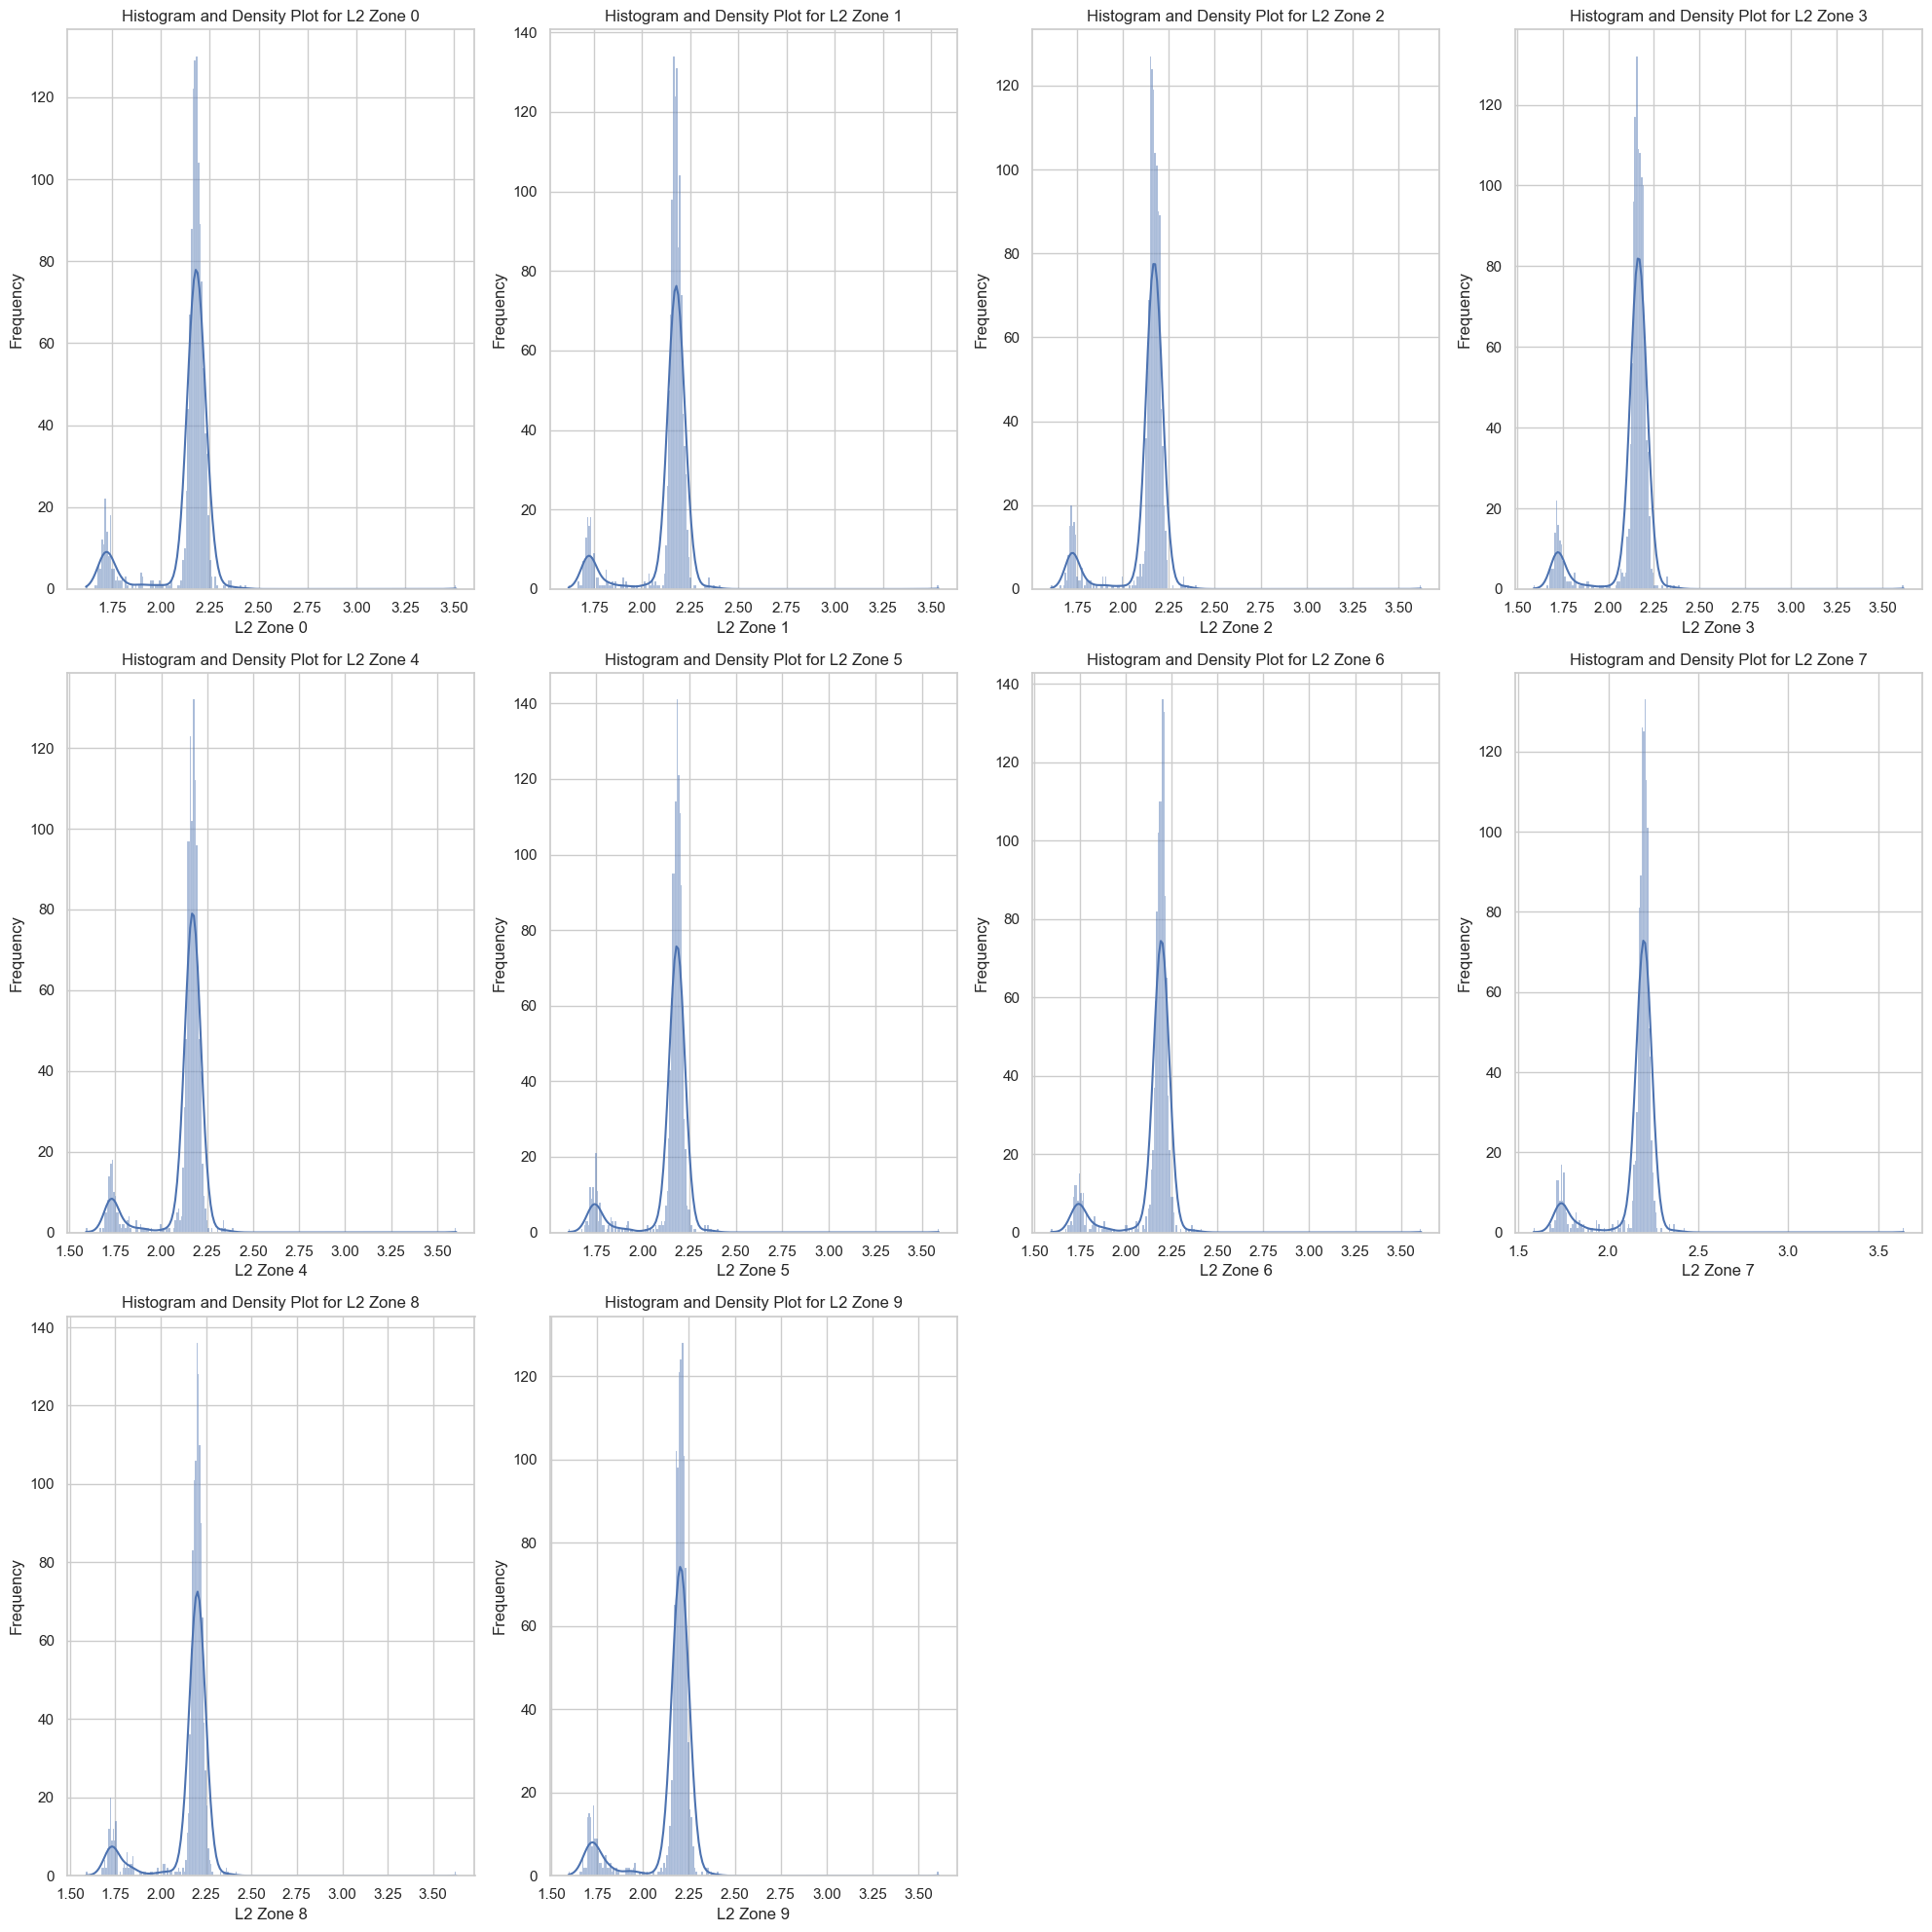

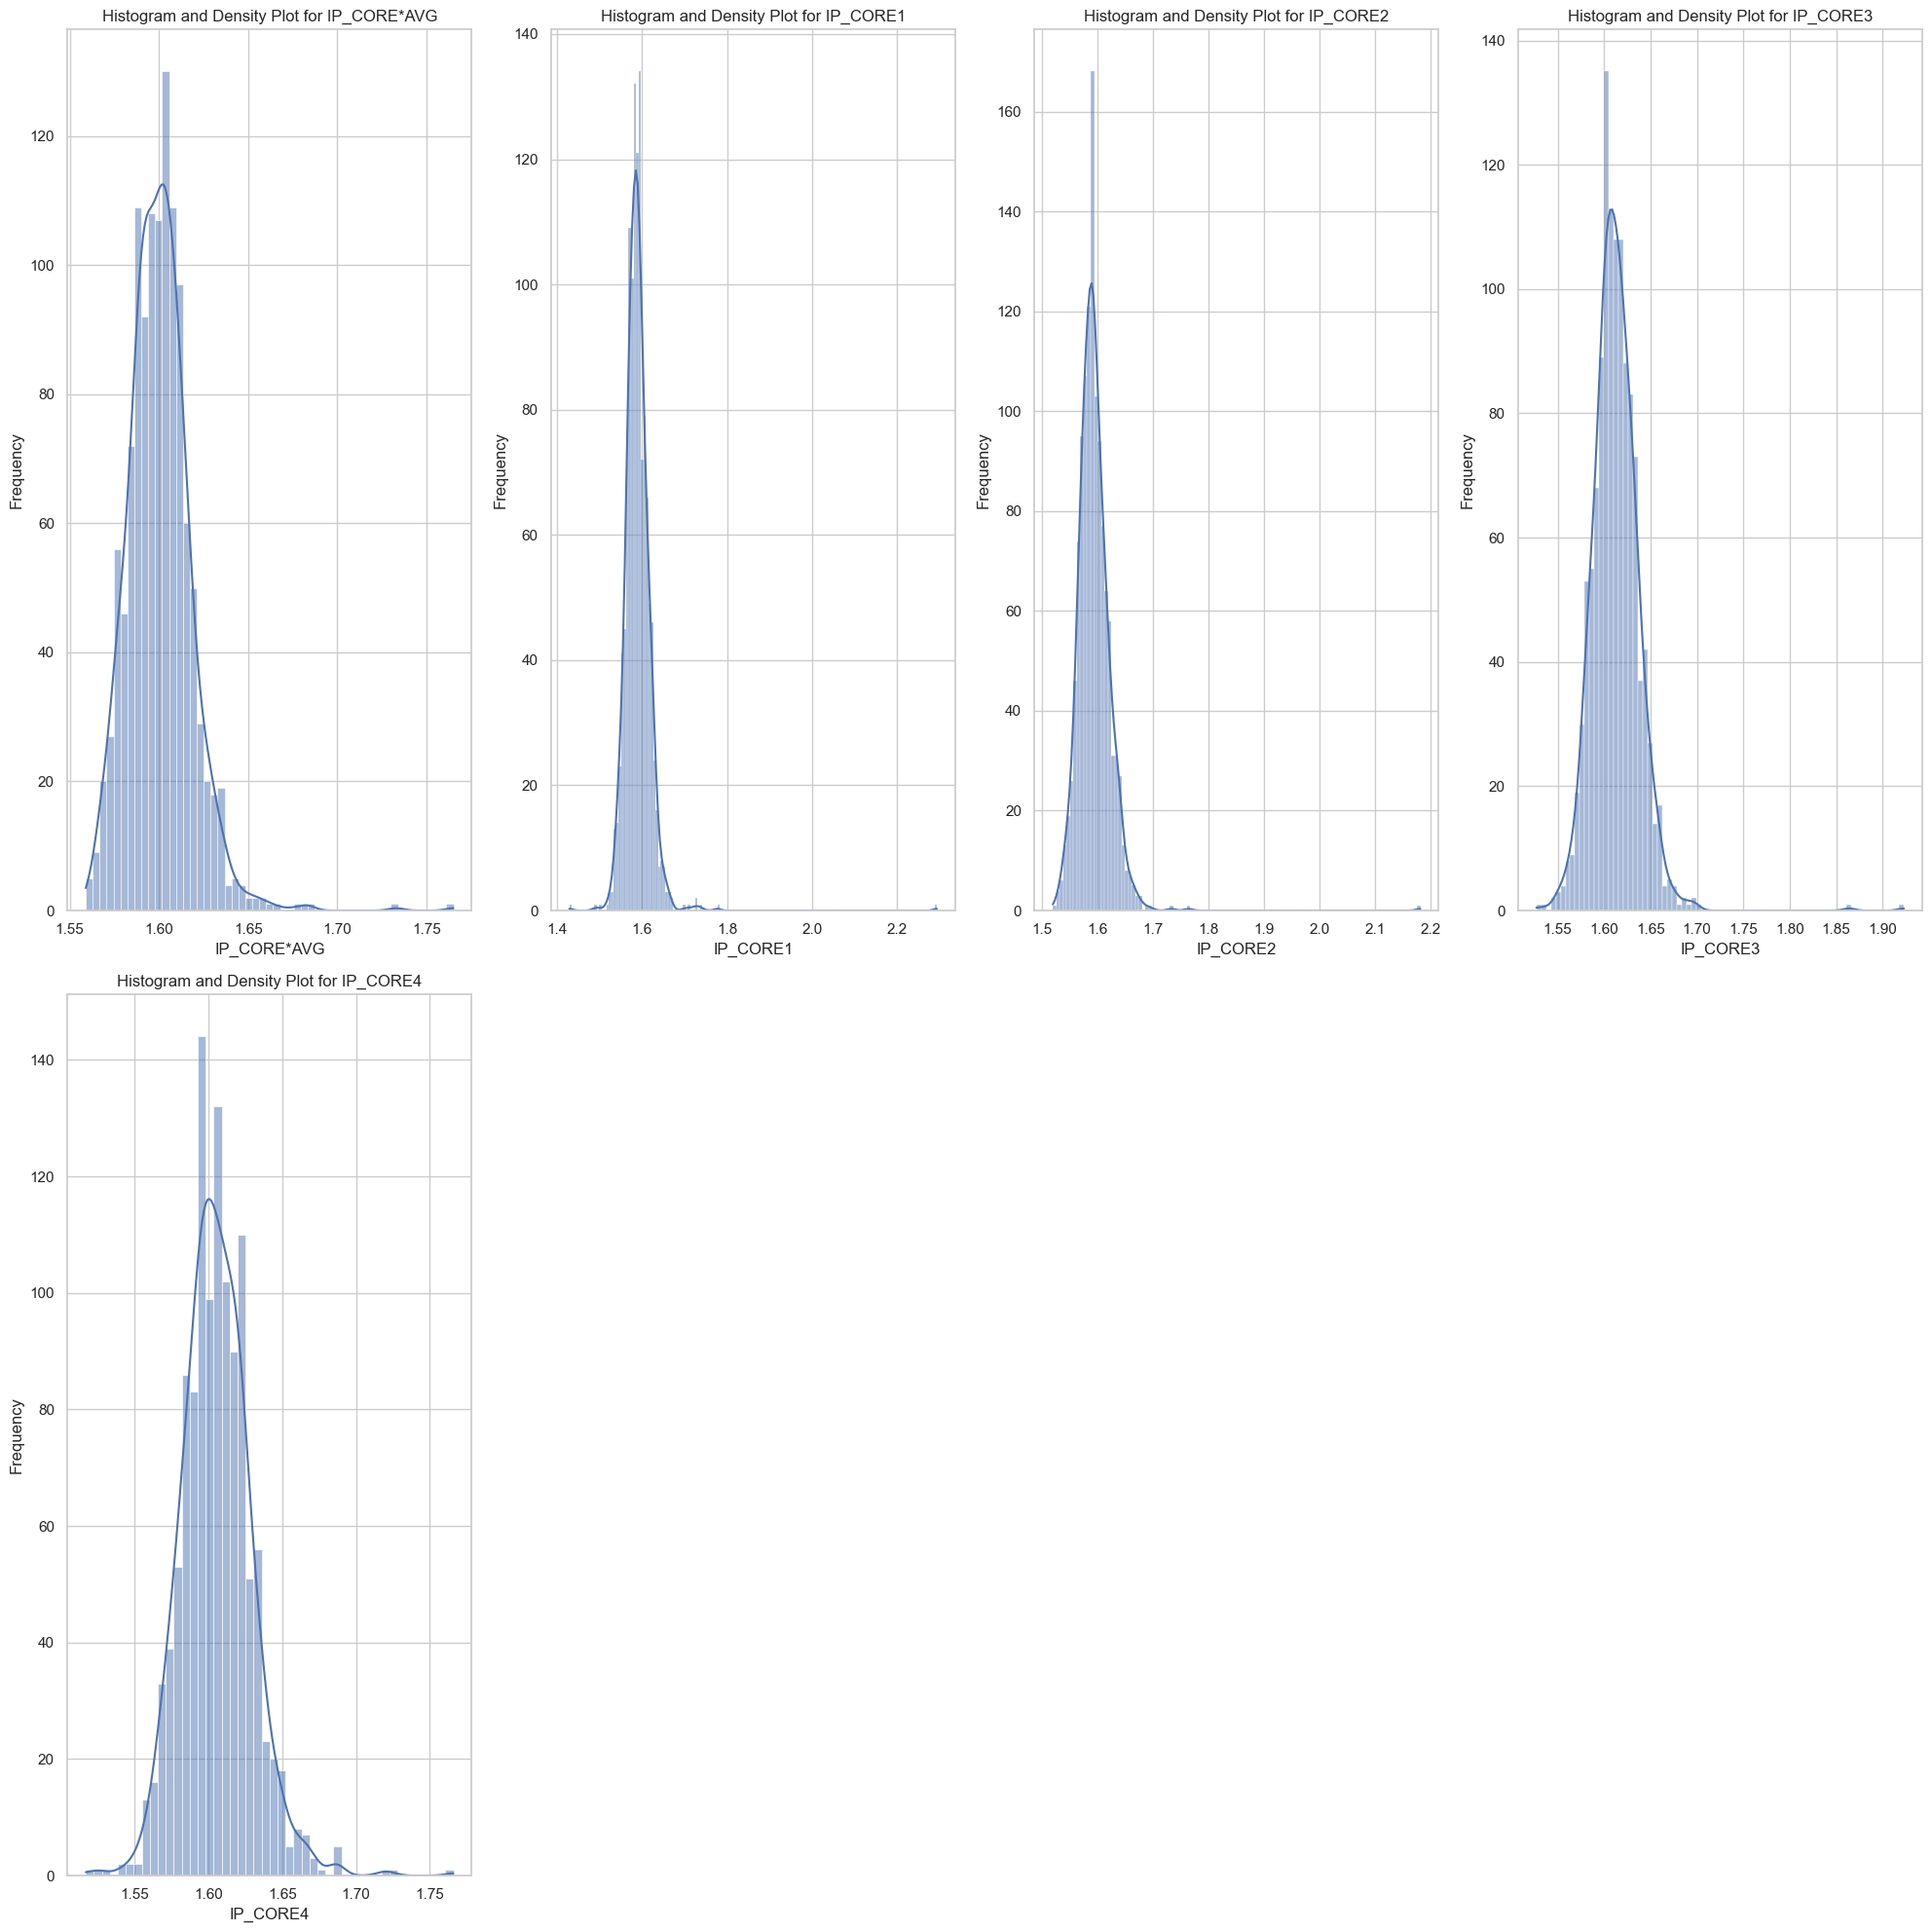

In [32]:
plot_density(df_l1_final)
plot_density(df_l2_final)

In [33]:
print(df_l1_final.describe())

                            DateTime   L1 Zone 0   L1 Zone 1   L1 Zone 2  \
count                            144  144.000000  144.000000  144.000000   
mean   2022-12-19 09:53:57.638888960    2.114830    2.112038    2.102623   
min              2022-01-08 16:48:19    1.385431    1.388357    1.387100   
25%    2022-08-07 11:07:18.750000128    2.135599    2.125001    2.120302   
50%       2022-12-11 04:36:36.500000    2.157141    2.155741    2.142123   
75%    2023-05-30 01:39:13.750000128    2.188628    2.180213    2.166321   
max              2024-04-24 05:57:38    2.337107    2.343015    2.304687   
std                              NaN    0.154873    0.149833    0.142617   

        L1 Zone 3   L1 Zone 4   L1 Zone 5   L1 Zone 6   L1 Zone 7   L1 Zone 8  \
count  144.000000  144.000000  144.000000  144.000000  144.000000  144.000000   
mean     2.094335    2.099110    2.116161    2.117814    2.120396    2.120016   
min      1.389595    1.425297    1.485341    1.513504    1.494442    1.4

In [34]:
print(df_l2_final.describe())

                            DateTime    L2 Zone 0    L2 Zone 1    L2 Zone 2  \
count                           1209  1209.000000  1209.000000  1209.000000   
mean   2022-12-20 12:26:51.965260544     2.132807     2.132195     2.126971   
min              2022-01-06 12:48:06     1.616074     1.618891     1.609221   
25%              2022-05-12 20:07:23     2.152091     2.151882     2.144924   
50%              2022-09-16 09:07:48     2.176391     2.173387     2.165531   
75%              2023-07-17 18:25:15     2.198203     2.194497     2.188376   
max              2024-06-03 14:23:17     3.510964     3.540011     3.622670   
std                              NaN     0.150407     0.145380     0.142935   

         L2 Zone 3    L2 Zone 4    L2 Zone 5    L2 Zone 6    L2 Zone 7  \
count  1209.000000  1209.000000  1209.000000  1209.000000  1209.000000   
mean      2.122358     2.127905     2.140179     2.148065     2.150552   
min       1.590176     1.590371     1.600356     1.592054     1.58

##### Scaling the data using StandardScaler (all columns except DateTime)

In [35]:
scaler = StandardScaler()

def scale(df):

    """
    Scales the data (exclusing the datetime feature) using StandardScaler.
    
    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the data to be scaled.
    
    Returns:
        pandas.DataFrame
            The scaled DataFrame
    """
    
        
    datetime_col = df.select_dtypes(include=['datetime']).columns
    features = df.drop(columns=datetime_col)
    scaled_df = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    scaled_df[datetime_col] = df[datetime_col].values
    print(scaled_df.describe())
    return scaled_df

scaled_l1 = scale(df_l1_final)
scaled_l2 = scale(df_l2_final)

          L1 Zone 0     L1 Zone 1     L1 Zone 2     L1 Zone 3     L1 Zone 4  \
count  1.440000e+02  1.440000e+02  1.440000e+02  1.440000e+02  1.440000e+02   
mean  -2.812565e-15 -9.159340e-16 -6.106227e-16 -1.609823e-15 -1.326100e-15   
min   -4.726109e+00 -4.846775e+00 -5.034592e+00 -5.133031e+00 -4.985174e+00   
25%    1.345747e-01  8.682333e-02  1.243938e-01  9.831850e-02  1.037792e-01   
50%    2.741516e-01  2.926985e-01  2.779312e-01  2.818280e-01  2.804283e-01   
75%    4.781681e-01  4.565986e-01  4.481958e-01  4.468254e-01  4.367596e-01   
max    1.440235e+00  1.546950e+00  1.421770e+00  1.569896e+00  1.595638e+00   
std    1.003490e+00  1.003490e+00  1.003490e+00  1.003490e+00  1.003490e+00   

          L1 Zone 5     L1 Zone 6     L1 Zone 7     L1 Zone 8     L1 Zone 9  \
count  1.440000e+02  1.440000e+02  1.440000e+02  1.440000e+02  1.440000e+02   
mean   1.245917e-15 -7.586524e-16 -4.194176e-16 -1.159566e-15 -1.652999e-15   
min   -4.726197e+00 -4.553497e+00 -4.569366e+00 -4.

##### Removing outliers using IQR

In [36]:
def remove_outliers(df):

    """
    Removes outliers from the DataFrame by filtering using Inter Quartile Range method.
    
    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the data from which outliers need to be removed.
    
    Returns:
        pandas.DataFrame
            The DataFrame with outliers removed.
    """

    
    # Extract zone and IP core columns
    zone_columns = [col for col in df.columns if 'Zone'  in col]
    ip_core_columns = [col for col in df.columns if 'IP_CORE' in col]

    columns = zone_columns + ip_core_columns
    
    Q1 = df[columns].quantile(0.15)
    Q3 = df[columns].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]

##### Exploring the correlation in data post outlier removal

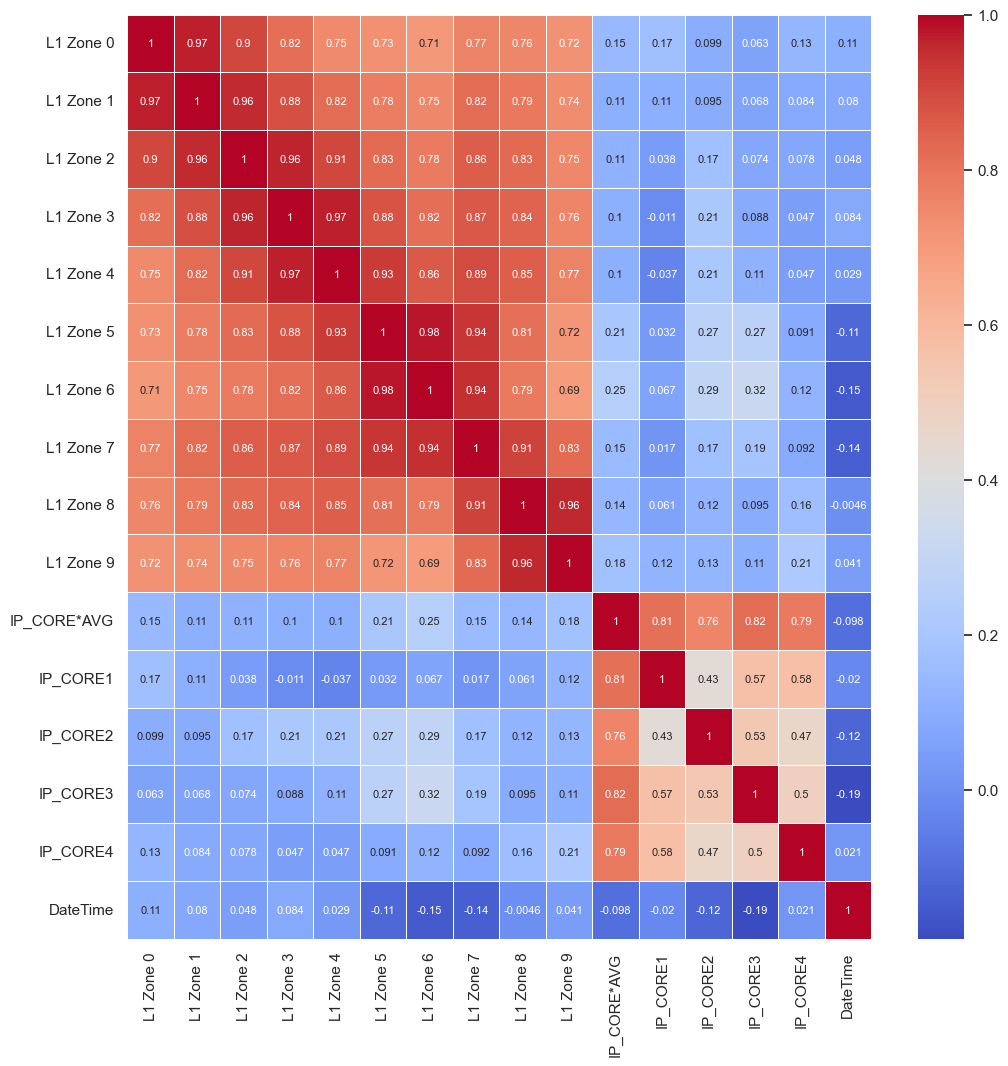

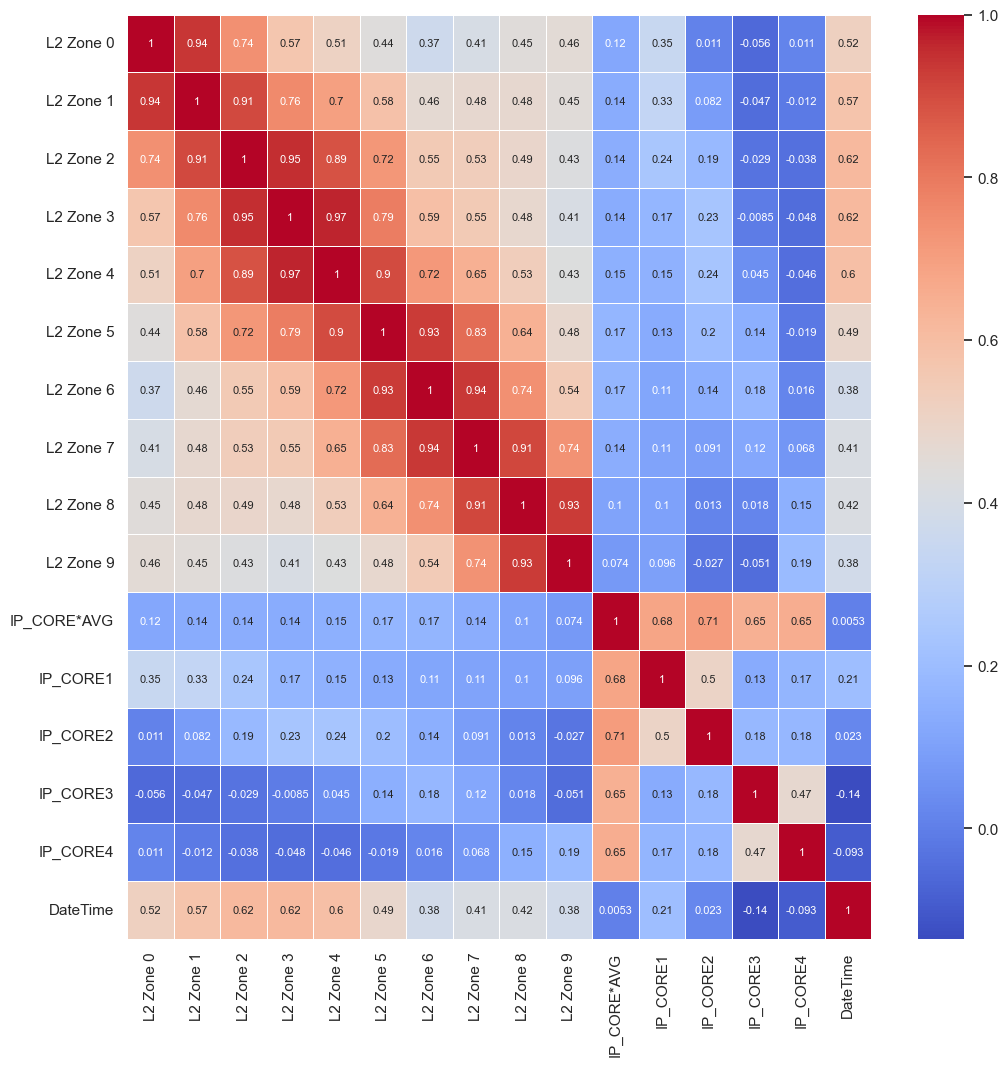

In [37]:
plot_heatmap(remove_outliers(scaled_l1))
plot_heatmap(remove_outliers(scaled_l2))

In [38]:
print(remove_outliers(scaled_l1).describe())
print(remove_outliers(scaled_l2).describe())

        L1 Zone 0   L1 Zone 1   L1 Zone 2   L1 Zone 3   L1 Zone 4   L1 Zone 5  \
count  125.000000  125.000000  125.000000  125.000000  125.000000  125.000000   
mean     0.353773    0.354241    0.353014    0.349958    0.352156    0.353896   
min     -1.234577   -1.045724   -0.929448   -0.735839   -0.609197   -0.566485   
25%      0.202062    0.194489    0.203363    0.188388    0.212134    0.182427   
50%      0.323076    0.321695    0.325500    0.318740    0.305585    0.321010   
75%      0.508421    0.497767    0.470141    0.477034    0.475868    0.518265   
max      1.440235    1.546950    1.421770    1.569896    1.595638    1.754476   
std      0.330237    0.314942    0.305938    0.318446    0.317378    0.309770   

        L1 Zone 6   L1 Zone 7   L1 Zone 8   L1 Zone 9  IP_CORE*AVG  \
count  125.000000  125.000000  125.000000  125.000000   125.000000   
mean     0.355787    0.359093    0.360479    0.359680    -0.034069   
min     -0.642199   -0.703321   -0.818252   -1.229686    -2.

In [39]:
# Extract unique timestamps
timestamps_l1 = df_l1_final['DateTime'].unique()
timestamps_l2 = df_l2_final['DateTime'].unique()

timestamps_l1, timestamps_l2

(<DatetimeArray>
 ['2022-01-08 16:48:19', '2022-01-08 20:51:54', '2022-01-10 00:28:35',
  '2022-01-10 19:45:51', '2022-01-21 22:25:35', '2022-01-22 02:23:11',
  '2022-01-22 04:34:26', '2022-01-22 06:37:17', '2022-01-29 20:24:51',
  '2022-02-08 08:53:14',
  ...
  '2024-02-07 08:43:13', '2024-02-22 00:00:29', '2024-02-22 03:21:09',
  '2024-03-23 12:28:27', '2024-03-28 01:25:44', '2024-04-08 01:27:14',
  '2024-04-12 13:19:09', '2024-04-12 15:59:11', '2024-04-17 00:31:39',
  '2024-04-24 05:57:38']
 Length: 144, dtype: datetime64[ns],
 <DatetimeArray>
 ['2022-01-06 12:48:06', '2022-01-06 22:39:47', '2022-01-07 01:27:33',
  '2022-01-07 04:41:11', '2022-01-07 08:10:45', '2022-01-07 22:26:37',
  '2022-01-08 07:08:22', '2022-01-08 10:55:59', '2022-01-11 16:24:27',
  '2022-01-11 18:55:39',
  ...
  '2024-05-29 09:37:16', '2024-05-30 06:31:34', '2024-05-30 09:29:49',
  '2024-05-31 13:03:28', '2024-05-31 16:30:08', '2024-05-31 19:49:36',
  '2024-06-03 05:14:53', '2024-06-03 08:33:32', '2024-06-03 1

##### Filter points using outliers in the thickness results

In [40]:
def filter_and_eliminate(thickness_df, df):

    """
    Filters and eliminates rows from the density DataFrame based on the thickness DataFrame criteria.
    
    Parameters:
        thickness_df : pandas.DataFrame
            The DataFrame containing thickness data used as a filtering criterion.
        df : pandas.DataFrame
            The DataFrame containing density data to be filtered.
    
    Returns:
        pandas.DataFrame
            The filtered DataFrame.
    """

    
    # Filter the thickness dataframe based on the thickness values between 2.25 and 2.75
    mask = (thickness_df.iloc[:, 1:] >= 2.25) & (thickness_df.iloc[:, 1:] <= 2.75)
    rows_to_keep = mask.all(axis=1)
    
    # Get the datetime values of the rows that do not meet the criteria
    datetime_to_eliminate = thickness_df.loc[~rows_to_keep, thickness_df.columns[0]].tolist()
    # Filter the original thickness dataframe to only keep the rows that meet the criteria
    filtered_thickness_df = thickness_df[rows_to_keep]
    
    # Eliminate rows from the provided dataframe based on the datetime values
    filtered_df = df[~df.iloc[:, 0].isin(datetime_to_eliminate)]
    
    return filtered_thickness_df, filtered_df

In [41]:
filtered_l1_thickness, filtered_df_l1 = filter_and_eliminate(l1_thickness, df_l1_final)
filtered_l2_thickness, filtered_df_l2 = filter_and_eliminate(l2_thickness, df_l2_final)

In [42]:
filtered_l1_thickness.describe()

DateTime   L1 Zone 0   L1 Zone 1   L1 Zone 2  \
count                            111  111.000000  111.000000  111.000000   
mean   2022-12-27 06:25:00.243243520    2.462488    2.459143    2.455281   
min              2022-01-08 16:48:19    2.399052    2.406182    2.408467   
25%              2022-05-05 07:08:02    2.448516    2.445029    2.442996   
50%              2023-01-31 07:33:47    2.457403    2.455667    2.451515   
75%              2023-06-01 19:27:24    2.471385    2.467230    2.462825   
max              2024-04-17 00:31:39    2.672115    2.647409    2.614981   
std                              NaN    0.033418    0.027593    0.025447   

        L1 Zone 3   L1 Zone 4   L1 Zone 5   L1 Zone 6   L1 Zone 7   L1 Zone 8  \
count  111.000000  111.000000  111.000000  111.000000  111.000000  111.000000   
mean     2.455707    2.454545    2.452077    2.457046    2.461139    2.469763   
min      2.402646    2.393801    2.395397    2.409420    2.422222    2.432426   
25%      2.444333    2.442981    2.439133    2.442804    2.445738    2.454228   
50%      2.451224    2.450443    2.448792    2.451891    2.457732    2.465441   
75%      2.463622    2.463316    2.463268    2.467229    2.472965    2.479176   
max      2.615948    2.609635    2.585764    2.559484    2.643958    2.590936   
std      0.024813    0.023866    0.023249    0.021524    0.026218    0.024017   

        L1 Zone 9  
count  111.000000  
mean     2.483098  
min      2.445326  
25%      2.466973  
50%      2.476678  
75%      2.495675  
max      2.624740  
std      0.027348

In [43]:
filtered_l2_thickness.describe()

DateTime    L2 Zone 0    L2 Zone 1    L2 Zone 2  \
count                           1048  1048.000000  1048.000000  1048.000000   
mean   2023-01-04 02:58:02.027671808     2.486765     2.491339     2.487980   
min              2022-01-06 12:48:06     2.353974     2.362769     2.355033   
25%    2022-06-05 15:26:23.249999872     2.469822     2.475332     2.471924   
50%       2022-09-27 01:11:27.500000     2.485797     2.488921     2.486307   
75%              2023-08-10 15:15:11     2.502367     2.506522     2.503526   
max              2024-06-03 14:23:17     2.694950     2.639152     2.618127   
std                              NaN     0.029236     0.025562     0.025700   

         L2 Zone 3    L2 Zone 4    L2 Zone 5    L2 Zone 6    L2 Zone 7  \
count  1048.000000  1048.000000  1048.000000  1048.000000  1048.000000   
mean      2.488633     2.485308     2.476848     2.468668     2.465841   
min       2.356506     2.356880     2.350377     2.338944     2.337477   
25%       2.472465     2.468860     2.460282     2.452884     2.449931   
50%       2.486792     2.483754     2.475564     2.466438     2.464521   
75%       2.504344     2.500486     2.493388     2.483883     2.481512   
max       2.700359     2.688696     2.655625     2.659306     2.676903   
std       0.026698     0.026716     0.026787     0.027631     0.028186   

         L2 Zone 8    L2 Zone 9  
count  1048.000000  1048.000000  
mean      2.471730     2.477945  
min       2.347329     2.356512  
25%       2.456164     2.460923  
50%       2.470731     2.477392  
75%       2.486662     2.493353  
max       2.665022     2.709491  
std       0.027918     0.030717

In [44]:
filtered_df_l1.head()

DateTime  L1 Zone 0  L1 Zone 1  L1 Zone 2  L1 Zone 3  L1 Zone 4  \
0 2022-01-08 16:48:19   2.161245   2.163765   2.155238   2.148194   2.156981   
1 2022-01-08 20:51:54   2.149674   2.145366   2.141920   2.133903   2.154569   
2 2022-01-10 00:28:35   2.188040   2.186360   2.179523   2.158435   2.165845   
3 2022-01-10 19:45:51   2.148869   2.142990   2.112148   2.098338   2.112934   
4 2022-01-21 22:25:35   2.198606   2.199191   2.188503   2.167289   2.176022   

   L1 Zone 5  L1 Zone 6  L1 Zone 7  L1 Zone 8  L1 Zone 9  IP_CORE*AVG  \
0   2.203472   2.215945   2.191433   2.139990   2.125858        1.636   
1   2.200383   2.214186   2.194584   2.146303   2.137786        1.657   
2   2.175485   2.166259   2.182360   2.182052   2.167635        1.631   
3   2.146004   2.150650   2.166002   2.170003   2.174059        1.631   
4   2.199233   2.201601   2.214438   2.217121   2.215067        1.634   

   IP_CORE1  IP_CORE2  IP_CORE3  IP_CORE4  
0     1.580     1.705     1.633     1.627  
1     1.654     1.652     1.676     1.647  
2     1.616     1.617     1.640     1.652  
3     1.650     1.601     1.631     1.643  
4     1.638     1.636     1.609     1.655

In [45]:
filtered_df_l2.head()

DateTime  L2 Zone 0  L2 Zone 1  L2 Zone 2  L2 Zone 3  L2 Zone 4  \
0 2022-01-06 12:48:06   2.187186   2.176557   2.161335   2.150839   2.154810   
1 2022-01-06 22:39:47   2.193074   2.195938   2.196310   2.189075   2.179820   
2 2022-01-07 01:27:33   2.182750   2.196814   2.203600   2.196590   2.178017   
3 2022-01-07 04:41:11   2.151023   2.152147   2.160370   2.163024   2.160486   
4 2022-01-07 08:10:45   2.184784   2.169310   2.154919   2.142793   2.124303   

   L2 Zone 5  L2 Zone 6  L2 Zone 7  L2 Zone 8  L2 Zone 9  IP_CORE*AVG  \
0   2.161338   2.168175   2.190162   2.213701   2.230420        1.581   
1   2.171643   2.167987   2.166574   2.164809   2.165998        1.587   
2   2.158759   2.146926   2.139983   2.144652   2.157973        1.593   
3   2.146787   2.142044   2.163901   2.177995   2.178710        1.585   
4   2.128541   2.156988   2.180210   2.202130   2.221086        1.565   

   IP_CORE1  IP_CORE2  IP_CORE3  IP_CORE4  
0     1.575     1.558     1.581     1.611  
1     1.559     1.612     1.599     1.579  
2     1.562     1.621     1.606     1.582  
3     1.605     1.589     1.606     1.539  
4     1.556     1.546     1.554     1.604

In [46]:
def remove_outliers2(df, df_new):

    """
    Removes outliers from the DataFrame based on specified criteria for multiple columns.
    
    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the thickness data.
        df_new : pandas.DataFrame
            The DataFrame containing the density data.
    
    Returns:
        pandas.DataFrame
            The DataFrames with outliers removed.
    """

    columns_to_check = df.columns.difference(['DateTime'])
    
    # Calculate the 25th percentile, 75th percentile, and standard deviation for each column
    percentiles_25 = df[columns_to_check].quantile(0.25)
    percentiles_75 = df[columns_to_check].quantile(0.75)
    std_devs = df[columns_to_check].std()
    
    # Define the lower and upper limits for each column
    lower_limits = percentiles_25 - 2 * std_devs
    upper_limits = percentiles_75 + 2 * std_devs
    
    # Create a boolean mask to identify rows that should be kept
    mask = pd.Series(True, index=df.index)
    
    for column in columns_to_check:
        mask &= df[column].between(lower_limits[column], upper_limits[column])
    
    # Filter the DataFrame using the mask
    filtered_df = df[mask]
    
    # Display the first few rows of the filtered DataFrame

    dates_to_keep = filtered_df['DateTime']
    filtered_df_new = df_new[df_new['DateTime'].isin(dates_to_keep)]

    print(filtered_df.describe())
    
    return filtered_df, filtered_df_new


In [47]:
filtered_l1_thickness_new, filtered_df_l1_new = remove_outliers2(filtered_l1_thickness, filtered_df_l1)
filtered_l2_thickness_new, filtered_df_l2_new = remove_outliers2(filtered_l2_thickness, filtered_df_l2)

                            DateTime   L1 Zone 0   L1 Zone 1   L1 Zone 2  \
count                            106  106.000000  106.000000  106.000000   
mean   2022-12-21 19:27:42.632075776    2.457987    2.455873    2.452456   
min              2022-01-08 16:48:19    2.407134    2.406182    2.411202   
25%       2022-05-05 02:06:39.500000    2.448457    2.444970    2.442988   
50%       2023-01-31 03:06:05.500000    2.456253    2.455473    2.451378   
75%              2023-06-01 19:55:50    2.468484    2.466693    2.462291   
max              2024-04-17 00:31:39    2.518073    2.494300    2.500665   
std                              NaN    0.018232    0.015923    0.016009   

        L1 Zone 3   L1 Zone 4   L1 Zone 5   L1 Zone 6   L1 Zone 7   L1 Zone 8  \
count  106.000000  106.000000  106.000000  106.000000  106.000000  106.000000   
mean     2.453195    2.452674    2.450461    2.455521    2.458508    2.467339   
min      2.416611    2.416154    2.407901    2.415868    2.422222    2.4

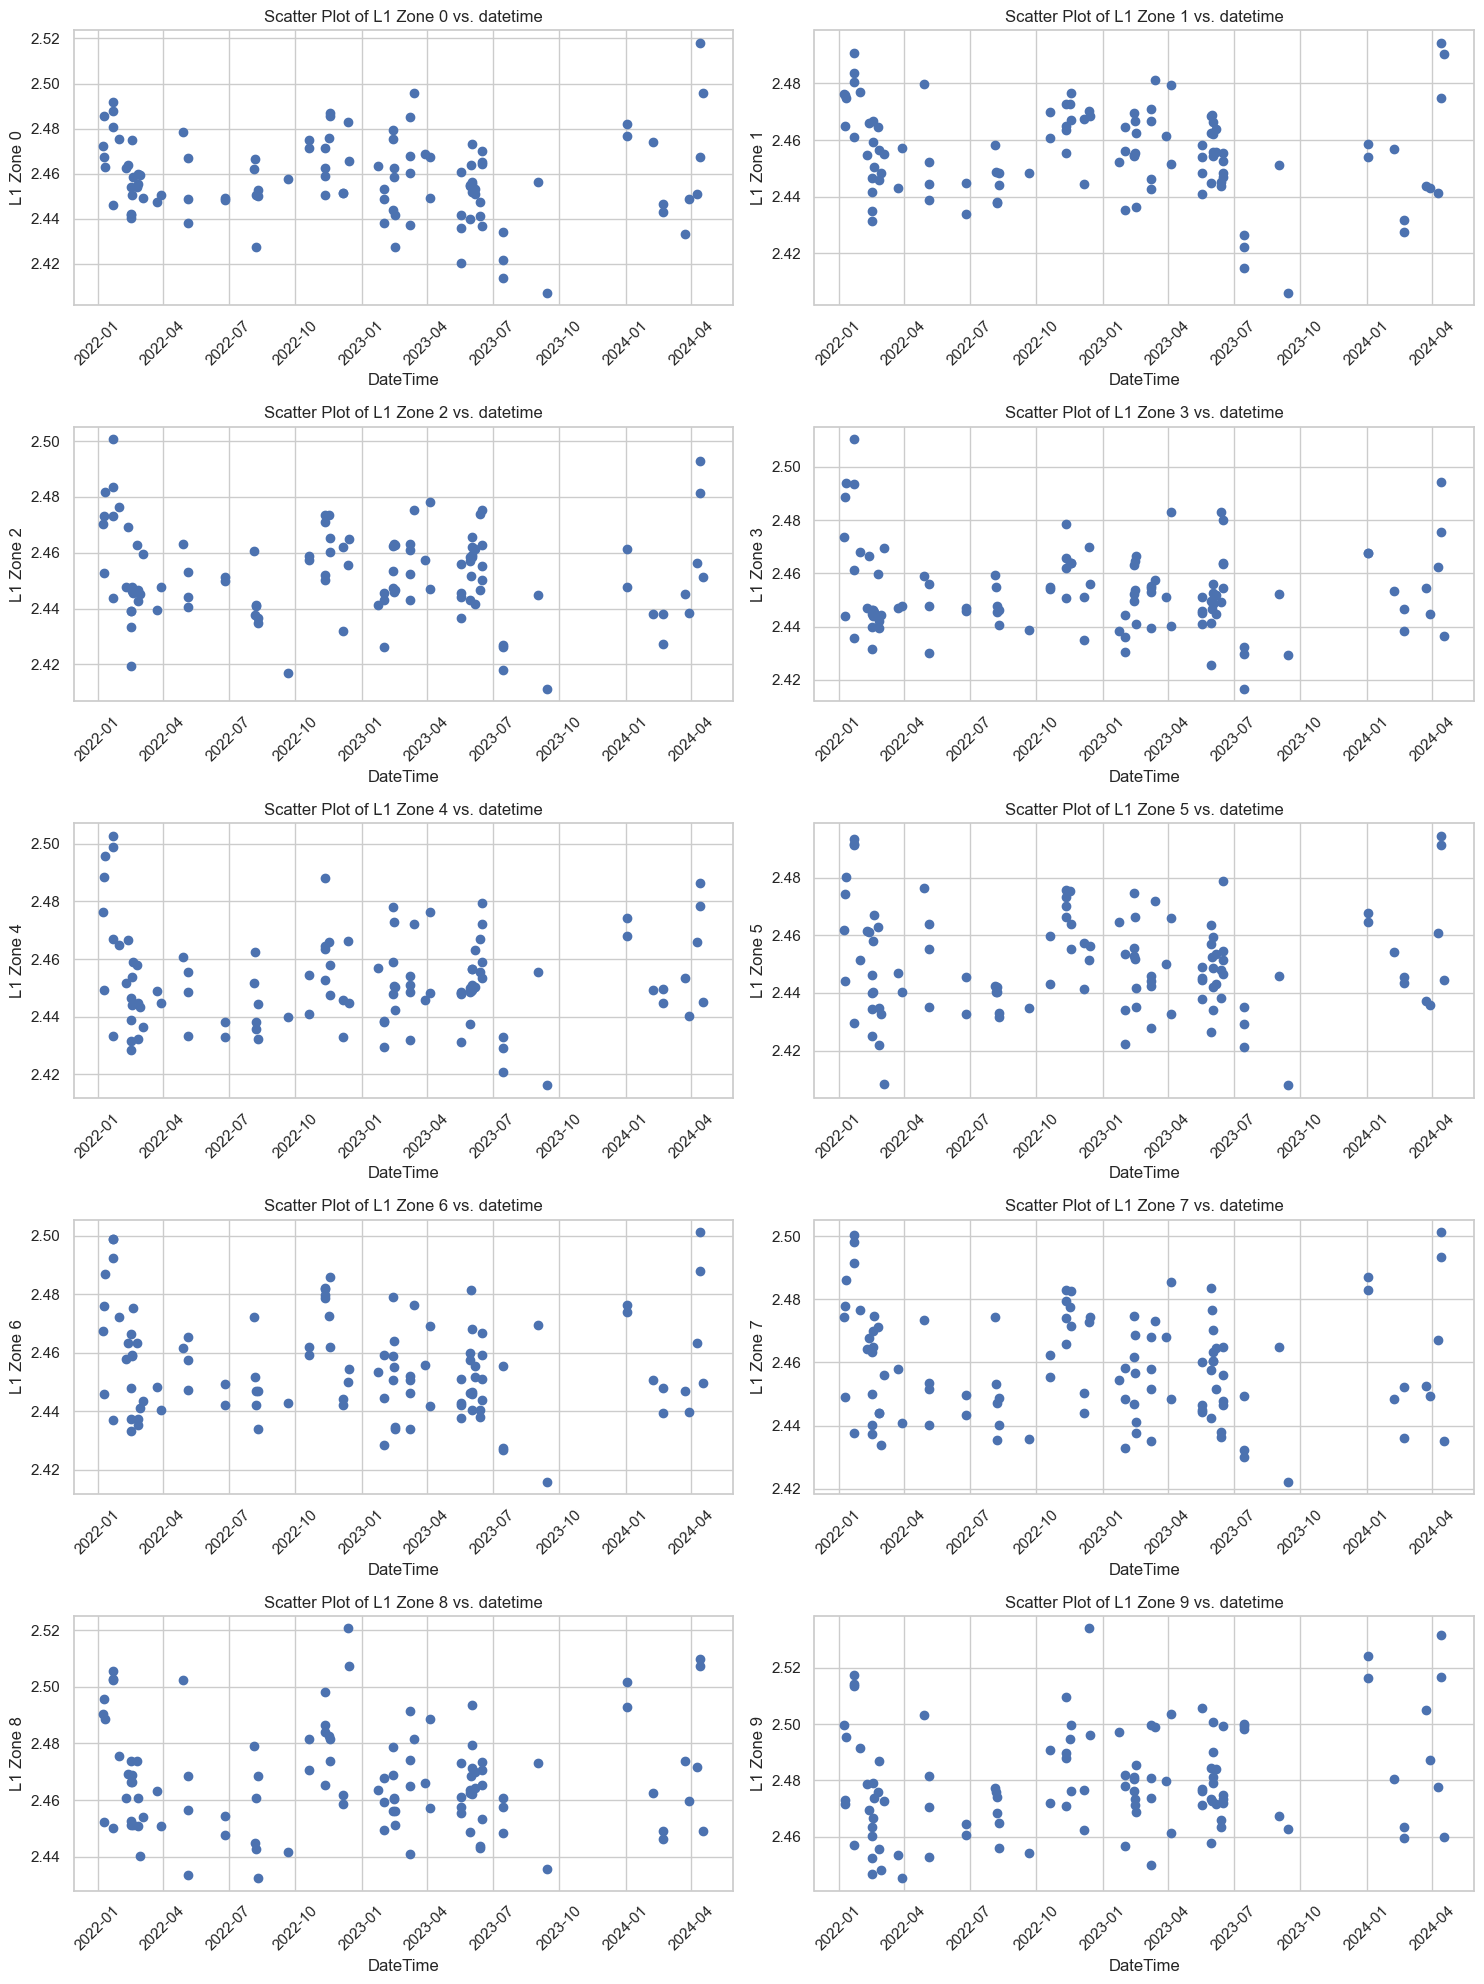

In [48]:
plt.figure(figsize=(15, 20))
for i in range(1, 11):
    plt.subplot(5, 2, i)
    plt.scatter(filtered_l1_thickness_new['DateTime'], filtered_l1_thickness_new[f'L1 Zone {i-1}'])
    plt.title(f'Scatter Plot of L1 Zone {i-1} vs. datetime')
    plt.xlabel('DateTime')
    plt.ylabel(f'L1 Zone {i-1}')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to fit everything
plt.show()

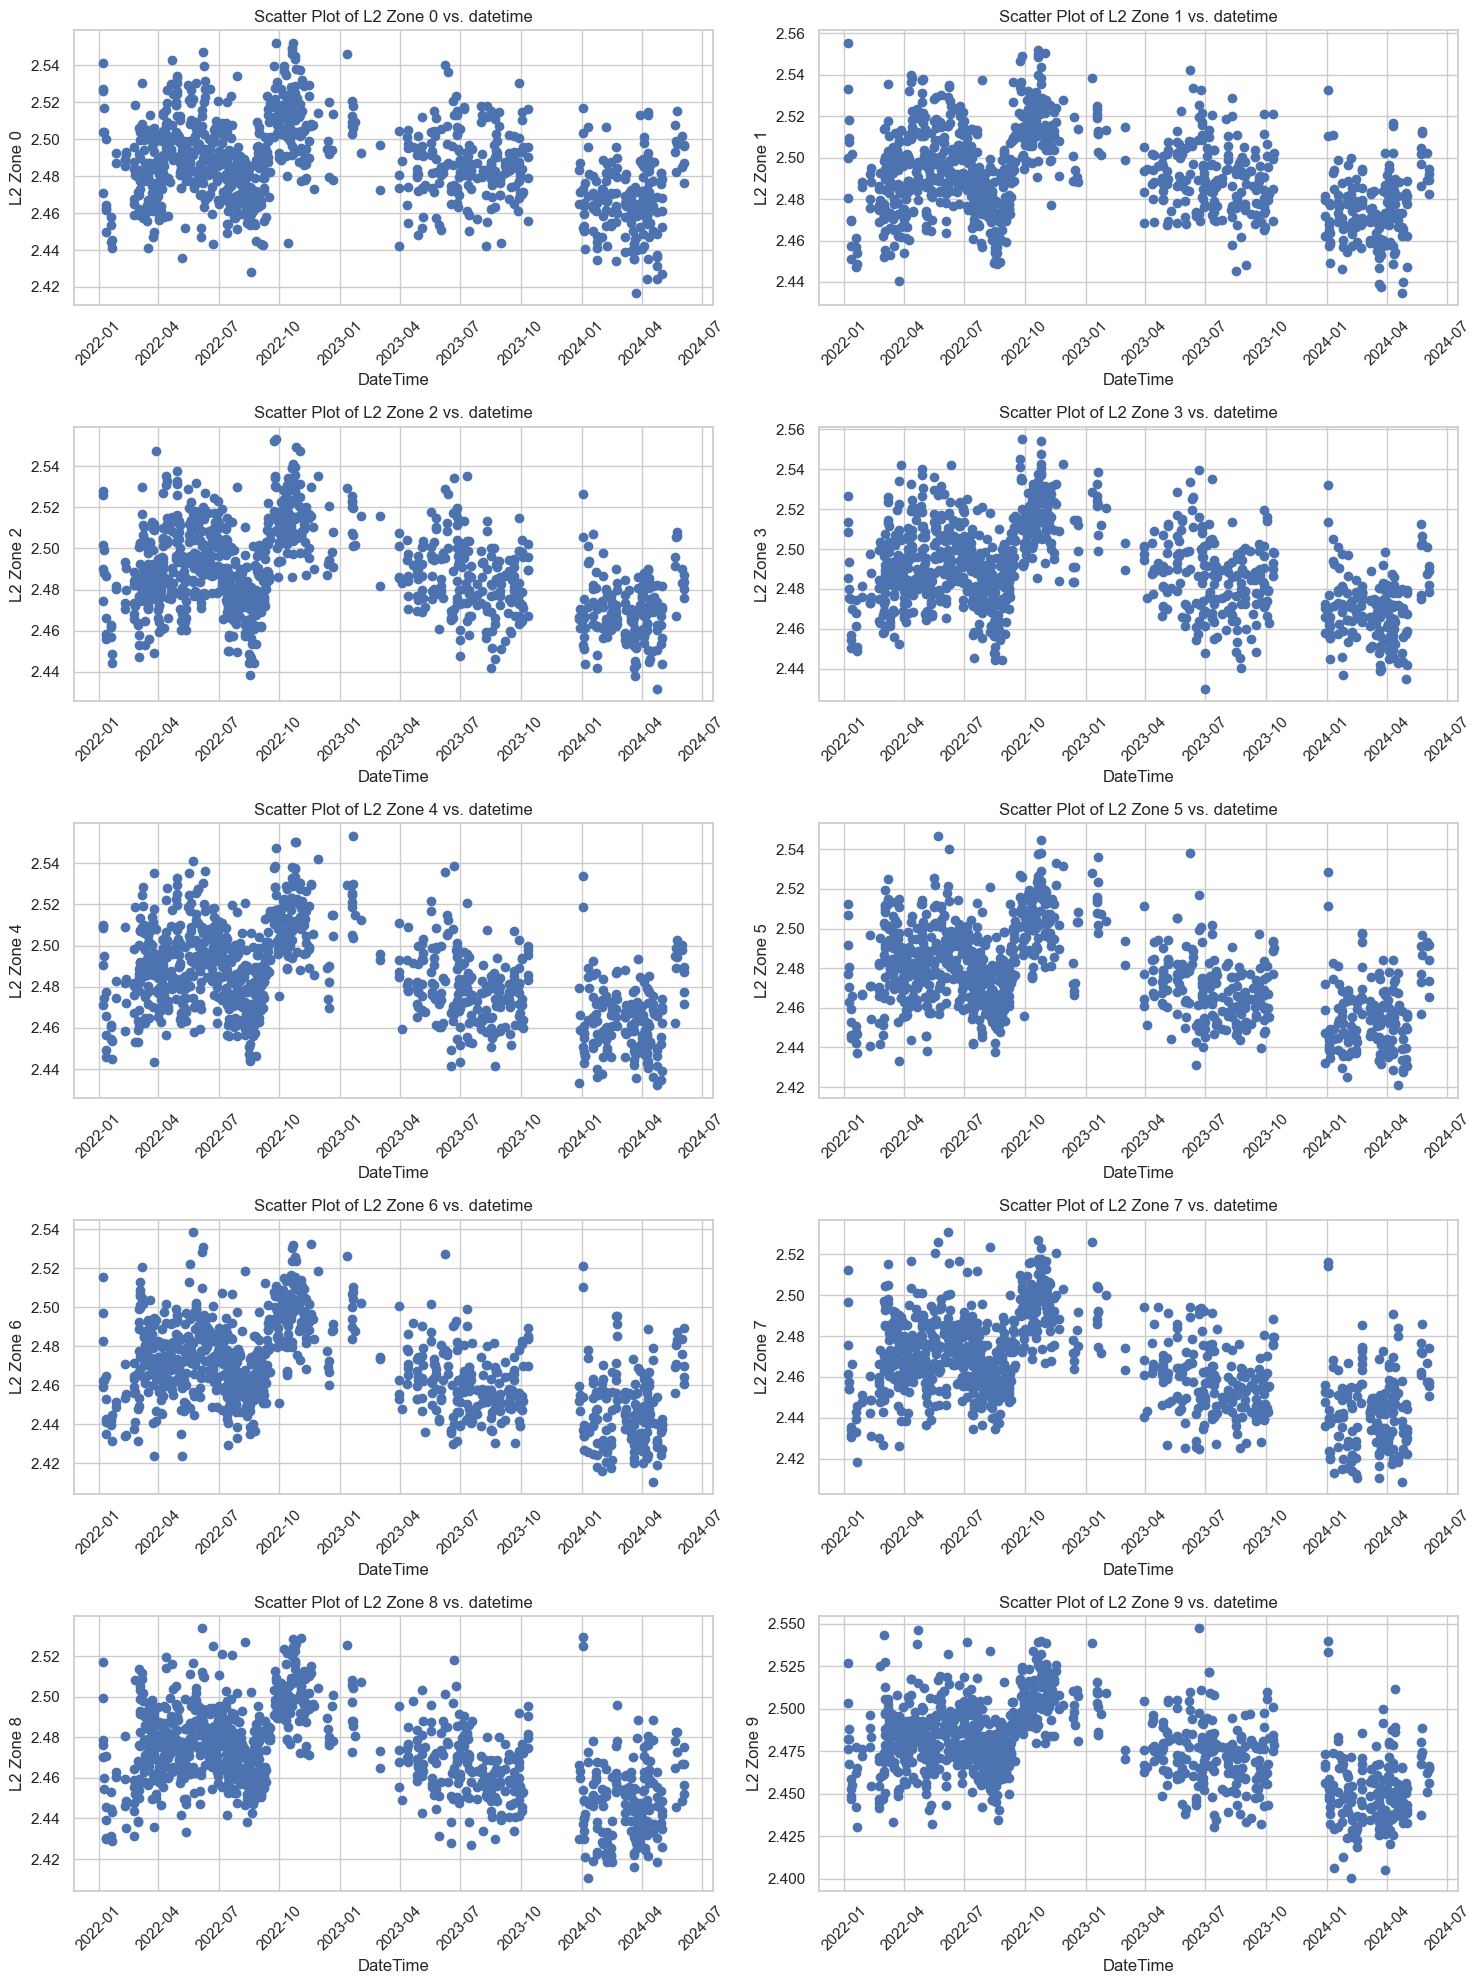

In [49]:
plt.figure(figsize=(15, 20))
for i in range(1, 11):
    plt.subplot(5, 2, i)
    plt.scatter(filtered_l2_thickness_new['DateTime'], filtered_l2_thickness_new[f'L2 Zone {i-1}'])
    plt.title(f'Scatter Plot of L2 Zone {i-1} vs. datetime')
    plt.xlabel('DateTime')
    plt.ylabel(f'L2 Zone {i-1}')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to fit everything
plt.show()

In [50]:
def analyze_zones_and_cores(df, label):

    """
    Rearrange and build new dataframes by mapping the zone values to core values in 2 ways per line.
    
    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the zone and core data.
        label : str
            Specified line.
    
    Returns:
        pandas.DataFrame
            The new dataframes.
    """

    
    zone_columns = [col for col in df.columns if 'Zone' in col]
    for col in zone_columns:
        df[f'{label}{col}'] = df[col]
    
    # Calculating averages for Zone 1-4 and Zone 5-8 with label
    df[f'{label}Zone 1-4 Avg'] = df[[f'{label}Zone 1', f'{label}Zone 2', f'{label}Zone 3', f'{label}Zone 4']].mean(axis=1)
    df[f'{label}Zone 5-8 Avg'] = df[[f'{label}Zone 5', f'{label}Zone 6', f'{label}Zone 7', f'{label}Zone 8']].mean(axis=1)

    # Creating the first dataset
    dataset1 = df[['DateTime', f'{label}Zone 0', f'{label}Zone 1-4 Avg', f'{label}Zone 5-8 Avg', f'{label}Zone 9', 
                   'IP_CORE1', 'IP_CORE2', 'IP_CORE3', 'IP_CORE4']].copy()

    # Creating the second dataset
    dataset2 = df[['DateTime', f'{label}Zone 0', f'{label}Zone 2', f'{label}Zone 6', f'{label}Zone 9', 
                   'IP_CORE1', 'IP_CORE2', 'IP_CORE3', 'IP_CORE4']].copy()

    # Function to plot correlation matrix
    def plot_corr(dataset, title):

        """
        Plots the correlation matrix for the given dataset.
        
        Parameters:
            dataset : pandas.DataFrame
                The DataFrame containing the data for which the correlation matrix is plotted.
            title : str
                The title of the plot.
        
        Returns:
            None
        """

        plt.figure(figsize=(10, 8))
        sns.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title(title)
        plt.show()

    # Plotting correlation matrices for both datasets
    plot_corr(dataset1, 'Correlation Matrix for Dataset 1')
    plot_corr(dataset2, 'Correlation Matrix for Dataset 2')

    return (dataset1, dataset2)


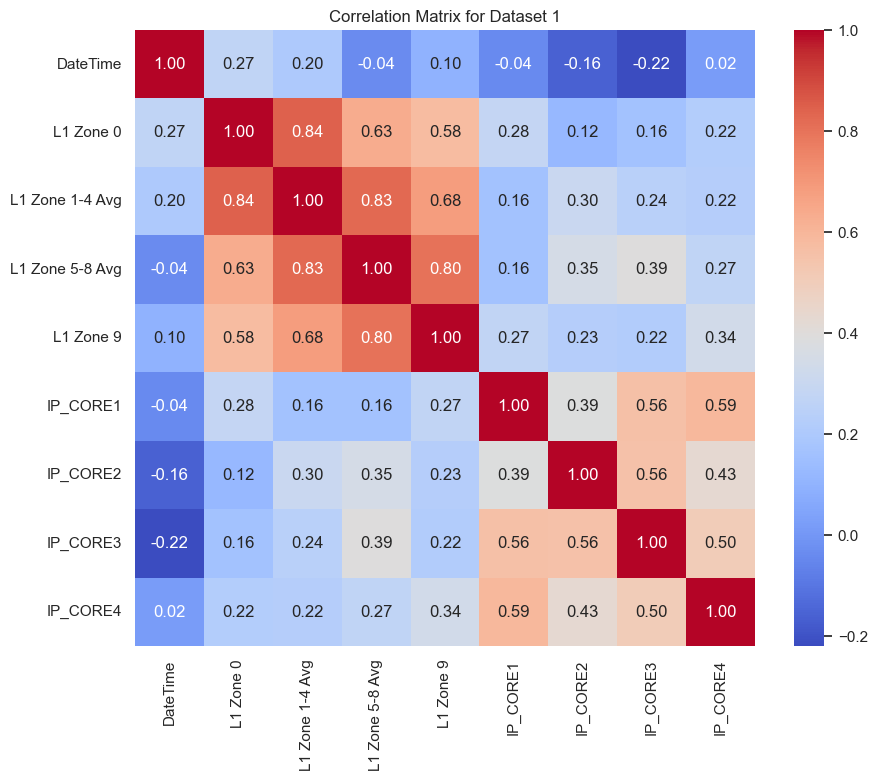

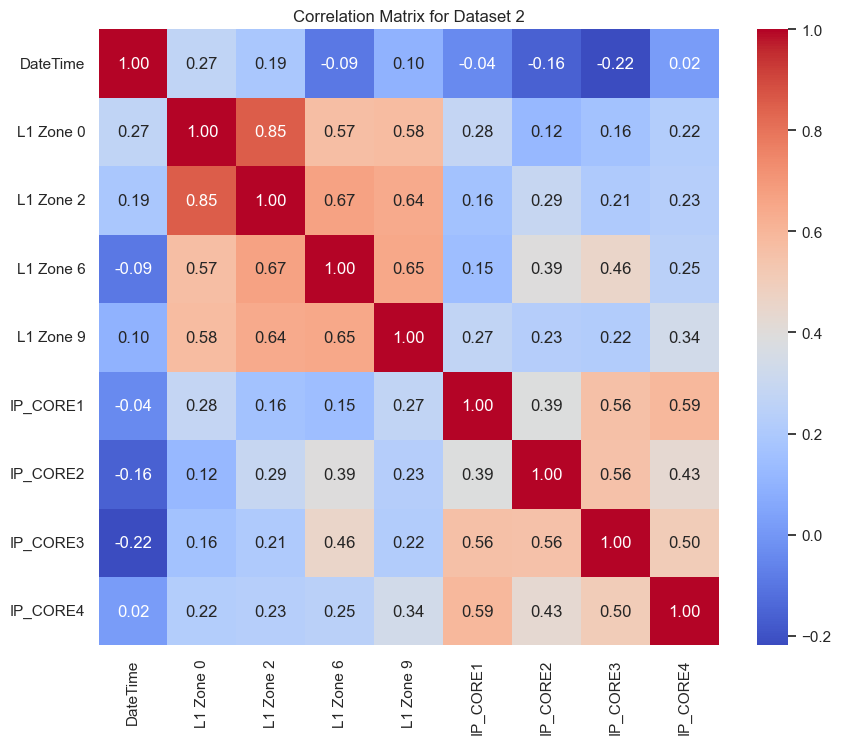

In [51]:
(l1_1, l1_2) = analyze_zones_and_cores(filtered_df_l1_new,'L1 ')

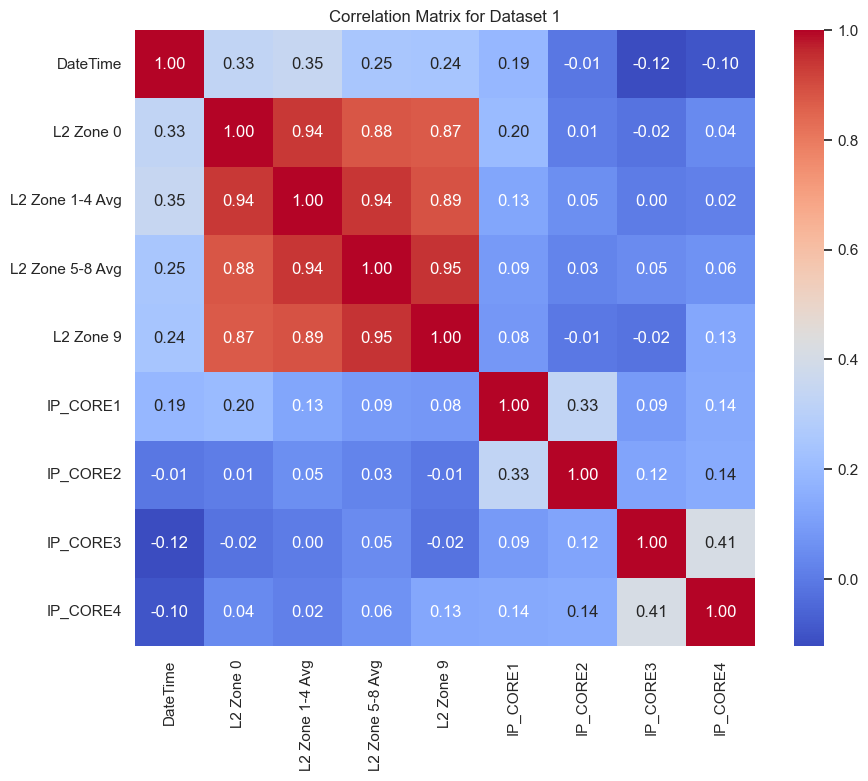

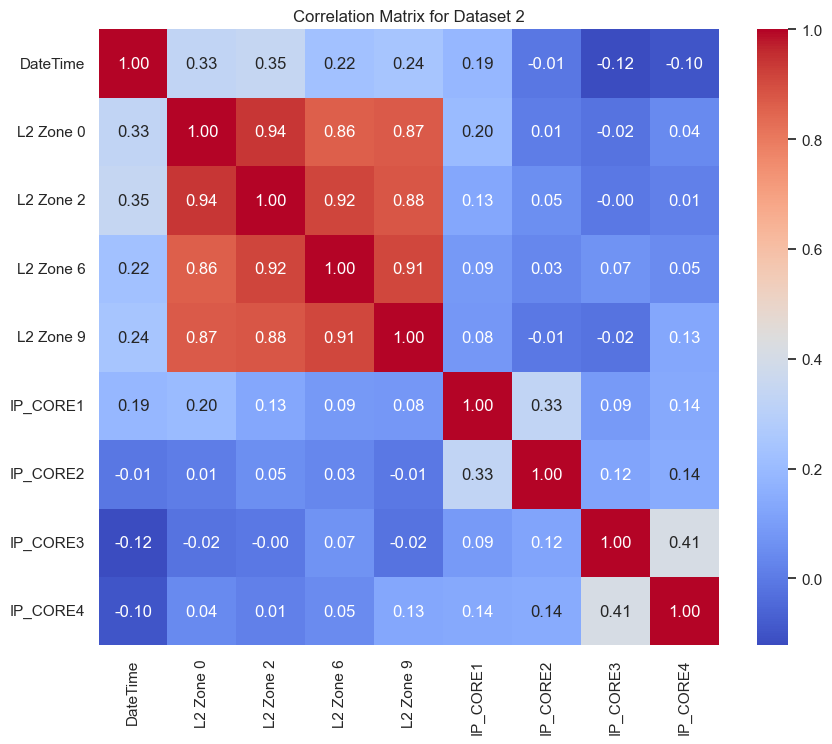

In [52]:
(l2_1, l2_2) = analyze_zones_and_cores(filtered_df_l2_new,'L2 ')

# ML pipeline

##### Experimenting different models

In [53]:
def pipeline(inputdf, X, y):

    """
    Executes the entire data science pipeline. Tests multiple ML models.
    
    Parameters:
        inputdf: pandas.DataFrame
                 The input dataframe (not used)
        X : pandas.DataFrame
            The feature matrix.
        y : pandas.Series
            The target variable.
    
    Returns:
        model : trained model object
            The trained model ready for prediction.
    """
    
    models = {
        'Linear Reg': LinearRegression(),
        'Ridge Reg': Ridge(),
        'DTR': DecisionTreeRegressor(),
        'RFR': RandomForestRegressor(),
        'XGB': XGBRegressor(),
        'Gradient Boosting Reg': GradientBoostingRegressor(),
    }
    scaler = StandardScaler()
    best_results=[]
    for model_name, model_instance in models.items():
        results=[]
        for i in range(0, 100):
            X_remaining, X_train, X_val, X_test, y_remaining, y_train, y_val, y_test = train_val_test_split(i, model_instance, scaler, X, y)
            model_instance.fit(X_train, y_train)
            results.append(modeling(model_instance, X_val, y_val))
        print('\nModel:\n ',model_name)
        best_r2_model = check_best_result(results)
        
        best_model = model_tuning(best_r2_model, X_train, y_train, X_val, y_val)
        check_best_result([modeling(best_model, X_val, y_val)])

        best_model.fit(X_remaining, y_remaining)
        check_best_result([modeling(best_model, X_test, y_test)])

def calculate_mape(actual, forecast):

    """
    Calculates the Mean Absolute Percentage Error (MAPE) between actual and forecasted values.
    
    Parameters:
        actual : numpy.array or pandas.Series
            The actual observed values.
        forecast : numpy.array or pandas.Series
            The forecasted or predicted values.
    
    Returns:
        float
            The MAPE value indicating the accuracy of the predictions.
    """

    
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [54]:
def train_val_test_split(i, model, scaler, X, y, ratio_train=0.65,ratio_val=0.2,ratio_test=0.15):

    """
    Splits the data into training, validation, and test sets based on provided ratios.
    
    Parameters:
        scaler : sklearn.preprocessing.StandardScaler or similar
            The scaler used to normalize the features.
        X : pandas.DataFrame
            The feature matrix.
        y : pandas.Series
            The target variable.
    
    Returns:
        X_train : pandas.DataFrame
            The training feature matrix.
        X_val : pandas.DataFrame
            The validation feature matrix.
        X_test : pandas.DataFrame
            The test feature matrix.
        y_train : pandas.Series
            The training target variable.
        y_val : pandas.Series
            The validation target variable.
        y_test : pandas.Series
            The test target variable.
    """

    X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=ratio_test, random_state = 0)

    # Adjusts val ratio, w.r.t. remaining dataset.
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining

    # Produces train and val splits.
    X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=ratio_val_adjusted, random_state = i)
    
    return scaler.fit_transform(X_remaining), scaler.fit_transform(X_train), scaler.fit_transform(X_val), scaler.transform(X_test), y_remaining, y_train, y_val, y_test

In [55]:
def modeling(model, X_val, y_val):

    """
    Performs model evaluation on the validation set and returns performance metrics.
    
    Parameters:
        model : trained model object
            The trained model to be evaluated.
        X_val : pandas.DataFrame
            The validation feature matrix.
        y_val : pandas.Series
            The validation target variable.
    
    Returns:
        dict
            A dictionary containing evaluation metrics such as accuracy, precision, recall, etc.
    """

    
    # Predict on the validation and test sets
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)
    mape_val = calculate_mape(y_val, y_val_pred)
   
    # Store the results in a dictionary
    results = {
        'rmse_val': rmse_val,
        'r2_val': r2_val,
        'mape_val': mape_val,
        'model': model,
        'X_val': X_val,
        'y_val': y_val,
        'y_val_pred': y_val_pred,
        'model':model
    }
    return results
    # return (X_val, y_val, y_val_pred, rmse_val, r2_val, mape_val)


In [56]:
def model_tuning(model, X_train, y_train, X_val, y_val):

    """
    Performs hyperparameter tuning using RandomizedSearchCV and GridSearchCV.
    
    Parameters:
        model : sklearn estimator
            The machine learning model to be tuned.
        X_train : pandas.DataFrame
            The training feature matrix.
        y_train : pandas.Series
            The training target variable.
        X_val : pandas.DataFrame
            The validation feature matrix.
        y_val : pandas.Series
            The validation target variable.
    
    Returns:
        model : sklearn estimator
            The best model found after tuning with optimized hyperparameters.
    """
    
    param_grid = {
        LinearRegression: {},
        Ridge: {'alpha': [0.1, 1.0, 10.0]},
        DecisionTreeRegressor: {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
        RandomForestRegressor: {'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2']},
        XGBRegressor: {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
        GradientBoostingRegressor: {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
        }
    
    model_class = type(model)
    if model_class not in param_grid:
        raise ValueError(f"Model {model_class.__name__} not supported for hyperparameter tuning.")
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_class], cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
  
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    val_score = best_model.score(X_val, y_val)
    # print (best_model, best_score, best_params, val_score)
    return best_model


In [57]:
def check_best_result(results):

    """
    Checks the best result from a series of model evaluations.
    
    Parameters:
        results : list of dict
            A list containing the evaluation results from different models.
    
    Returns:
        dict
            The best result found in the list.
    """

    
    # results_df = pd.DataFrame(results, columns=['X_val', 'y_val', 'y_val_pred', 'RMSE', 'R2', 'MAPE'])
    results_df = pd.DataFrame(results)
    best_model = results_df.loc[results_df['rmse_val'].idxmin()]
    best_r2_model = results_df.loc[results_df['r2_val'].idxmax()]
    
    # Print the maximum R2 value
    max_r2 = results_df['r2_val'].max()
    min_rmse = results_df['rmse_val'].min()
    min_mape = results_df['mape_val'].min()
    
    print(f"Maximum R2 Value: {max_r2:.4f}")
    print(f"Minimum RMSE Value: {min_rmse:.4f}")
    print(f"Minimum MAPE Value: {min_mape:.4f}")
    
    return best_r2_model['model']

In [58]:
pipeline(l1_2, l1_2['L1 Zone 2'].values.reshape(-1,1), l1_2['IP_CORE2'].values.reshape(-1,1))


Model:
  Linear Reg
Maximum R2 Value: 0.2343
Minimum RMSE Value: 0.0172
Minimum MAPE Value: 0.7714
Maximum R2 Value: 0.0185
Minimum RMSE Value: 0.0235
Minimum MAPE Value: 1.0448
Maximum R2 Value: 0.1722
Minimum RMSE Value: 0.0201
Minimum MAPE Value: 0.9923

Model:
  Ridge Reg
Maximum R2 Value: 0.2316
Minimum RMSE Value: 0.0171
Minimum MAPE Value: 0.7691
Maximum R2 Value: 0.0214
Minimum RMSE Value: 0.0235
Minimum MAPE Value: 1.0337
Maximum R2 Value: 0.1604
Minimum RMSE Value: 0.0202
Minimum MAPE Value: 0.9989

Model:
  DTR
Maximum R2 Value: 0.0531
Minimum RMSE Value: 0.0230
Minimum MAPE Value: 1.3534
Maximum R2 Value: -0.8922
Minimum RMSE Value: 0.0327
Minimum MAPE Value: 1.8009
Maximum R2 Value: -0.7094
Minimum RMSE Value: 0.0288
Minimum MAPE Value: 1.5423

Model:
  RFR
Maximum R2 Value: 0.3042
Minimum RMSE Value: 0.0184
Minimum MAPE Value: 1.1360
Maximum R2 Value: -0.6246
Minimum RMSE Value: 0.0303
Minimum MAPE Value: 1.6536
Maximum R2 Value: -0.2745
Minimum RMSE Value: 0.0249
Minimu

# Hypertuning GBR

In [59]:
def pipeline(X, y):

    model = GradientBoostingRegressor()
    
    X_remaining, X_train, X_val, X_test, y_remaining, y_train, y_val, y_test = train_val_test_split(scaler, X, y)
    model.fit(X_train, y_train)
    
    print('Before tuning:\n')
    check_result(model, X_train, y_train)
    check_result(model, X_val, y_val)

    tuned_model = hypertune_model(model, X_train, y_train)
    print(tuned_model)
    print('\nAfter tuning:\n')
    check_result(tuned_model, X_val, y_val)
    
    tuned_model.fit(X_remaining, y_remaining)
    print('\nFinal results\n')
    y_pred_train = check_result(tuned_model, X_train, y_train)
    y_pred_val = check_result(tuned_model, X_val, y_val)
    y_pred_test = check_result(tuned_model, X_test, y_test)
    
    return y_pred_train, y_train, y_pred_val, y_val,y_pred_test, y_test
   

In [60]:
def train_val_test_split(scaler, X, y):
    
    ratio_train=0.65
    ratio_val=0.15
    ratio_test=0.20
    
    X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=ratio_test, random_state = 90)
    
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining
    
    # Produces train and val splits.
    X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=ratio_val_adjusted, random_state = 60)

    # print('Training Data Size: {}'.format(len(X_train)))
    # print('Validation Data Size: {}'.format(len(X_val)))
    # print('Test Data Size: {}'.format(len(X_test)))
    
    
    return X_remaining, X_train, X_val, X_test, y_remaining, y_train, y_val, y_test
    # scaler.fit(X_train)
    # return scaler.transform(X_remaining), scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test), y_remaining, y_train, y_val, y_test

In [61]:
def check_result(model, X_val, y_val):

    """
    Evaluates the model on the validation set and checks for performance metrics.
    
    Parameters:
        model : trained model object
            The trained model to be evaluated.
        X_val : pandas.DataFrame
            The validation feature matrix.
        y_val : pandas.Series
            The validation target variable.
    
    Returns:
        dict
            A dictionary containing evaluation metrics such as accuracy, precision, recall, etc.
    """

    
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)
    mape_val = calculate_mape(y_val, y_val_pred)
    
    print(f"R2 Value: {r2_val:.4f}")
    print(f"RMSE Value: {rmse_val:.4f}")
    print(f"MAPE Value: {mape_val:.4f}")

    return y_val_pred
    # print(X_val,y_val,y_val_pred)


In [62]:
def hypertune_model(model, X_train, y_train):

    """
    Performs hyperparameter tuning using GridSearchCV or RandomizedSearchCV to find the best parameters for a given model.
    
    Parameters:
        model : sklearn estimator
            The machine learning model to be tuned.
        X_train : pandas.DataFrame
            The training feature matrix.
        y_train : pandas.Series
            The training target variable.
    
    Returns:
        sklearn estimator
            The best model with optimized hyperparameters.
    """

    
    # Define the hyperparameter grid for RandomSearchCV
    param_dist = {
        'learning_rate': np.linspace(0.001, 0.5, 50),
        'n_estimators': np.arange(10, 200, 10),
        'max_depth': np.arange(1, 20, 2),
        'min_samples_split': np.arange(2, 20, 2),
        'min_samples_leaf': np.arange(1, 20, 2),
        'min_weight_fraction_leaf': np.linspace(0.0, 0.5, 10),
        'min_impurity_decrease': np.linspace(0.0, 0.2, 10),
        'warm_start': [True, False] 
    }
    
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=0)
    random_search.fit(X_train, y_train)
    best_random_params = random_search.best_params_
    
    # print(f"Best parameters from RandomSearchCV: {best_random_params}")

    param_grid = {
        'learning_rate': [best_random_params['learning_rate'] * 0.8, best_random_params['learning_rate'], best_random_params['learning_rate'] * 1.2],
        'n_estimators': [best_random_params['n_estimators'] - 10, best_random_params['n_estimators'], best_random_params['n_estimators'] + 10],
        'max_depth': [best_random_params['max_depth'] - 2, best_random_params['max_depth'], best_random_params['max_depth'] + 2],
        'min_samples_split': [best_random_params['min_samples_split'] - 2, best_random_params['min_samples_split'], best_random_params['min_samples_split'] + 2],
        'min_samples_leaf': [best_random_params['min_samples_leaf'] - 2, best_random_params['min_samples_leaf'], best_random_params['min_samples_leaf'] + 2],
        'min_weight_fraction_leaf': [best_random_params['min_weight_fraction_leaf'] * 0.9, best_random_params['min_weight_fraction_leaf'], best_random_params['min_weight_fraction_leaf'] * 1.1],
        'min_impurity_decrease': [best_random_params['min_impurity_decrease'] * 0.9, best_random_params['min_impurity_decrease'], best_random_params['min_impurity_decrease'] * 1.1],
        'warm_start': [best_random_params['warm_start']]
    }
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_grid_params = grid_search.best_params_
    
    # print(f"Best parameters from GridSearchCV: {best_grid_params}")
    # print(grid_search.best_estimator_)
    return grid_search.best_estimator_

In [63]:
scaler = StandardScaler()
def plot_predictions(dates, y_actual, y_pred, title):

    """
    Plots the actual versus predicted values over time.
    
    Parameters:
        dates : pandas.Series or numpy.array
            The time series data for the x-axis.
        y_actual : pandas.Series or numpy.array
            The actual observed values.
        y_pred : pandas.Series or numpy.array
            The predicted values by the model.
        title : str
            The title of the plot.
    
    Returns:
        None
            Displays a plot of actual vs. predicted values.
    """
    
    plt.figure(figsize=(10, 4))
    plt.plot(dates, y_actual, label='Actual Values', color='blue')
    plt.plot(dates, y_pred, label='Predicted Values', color='red')
    plt.xlabel('DateTime')
    plt.ylabel('Density Value')
    plt.title(title)
    plt.legend()
    plt.show()

Before tuning:

R2 Value: 0.9395
RMSE Value: 0.0062
MAPE Value: 1.6208
R2 Value: -1.6092
RMSE Value: 0.0397
MAPE Value: 1.7492
GradientBoostingRegressor(learning_rate=0.6, max_depth=15, min_samples_leaf=15,
                          min_samples_split=16,
                          min_weight_fraction_leaf=0.4444444444444444,
                          n_estimators=200, warm_start=True)

After tuning:

R2 Value: -0.3609
RMSE Value: 0.0287
MAPE Value: 1.4096

Final results

R2 Value: 0.1605
RMSE Value: 0.0230
MAPE Value: 1.3508
R2 Value: -0.3609
RMSE Value: 0.0287
MAPE Value: 1.4096
R2 Value: 0.0909
RMSE Value: 0.0266
MAPE Value: 1.4401


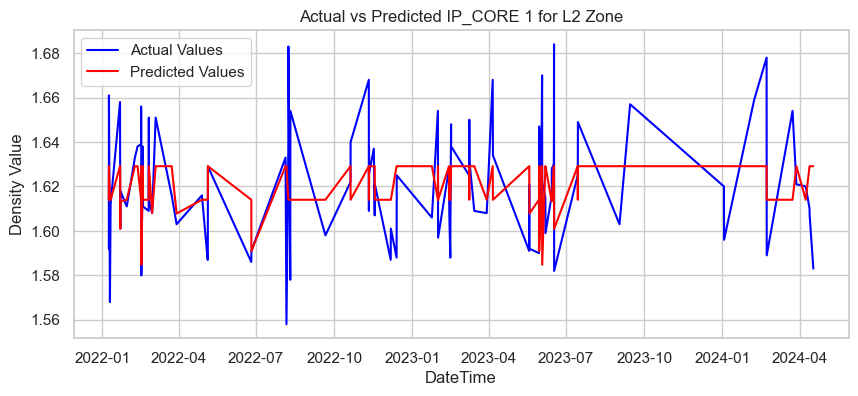

Before tuning:

R2 Value: 0.9240
RMSE Value: 0.0068
MAPE Value: 1.5209
R2 Value: 0.0891
RMSE Value: 0.0214
MAPE Value: 1.5309
GradientBoostingRegressor(learning_rate=0.0012, min_samples_leaf=17,
                          min_samples_split=8, min_weight_fraction_leaf=0.3,
                          n_estimators=200, warm_start=True)

After tuning:

R2 Value: -0.0137
RMSE Value: 0.0225
MAPE Value: 1.1514

Final results

R2 Value: 0.0899
RMSE Value: 0.0234
MAPE Value: 1.1834
R2 Value: -0.0137
RMSE Value: 0.0225
MAPE Value: 1.1514
R2 Value: 0.0189
RMSE Value: 0.0266
MAPE Value: 1.3513


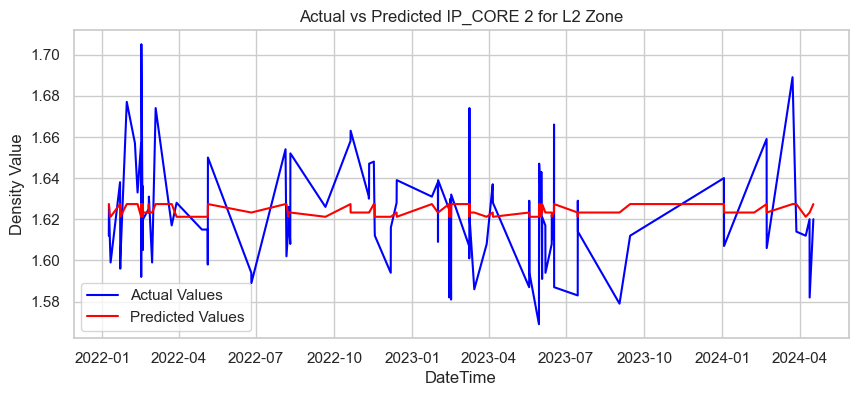

Before tuning:

R2 Value: 0.9331
RMSE Value: 0.0062
MAPE Value: 1.5306
R2 Value: -0.5598
RMSE Value: 0.0305
MAPE Value: 1.7717
GradientBoostingRegressor(learning_rate=0.04153469387755102, max_depth=17,
                          min_samples_leaf=7, min_samples_split=10,
                          min_weight_fraction_leaf=0.3333333333333333,
                          n_estimators=160, warm_start=True)

After tuning:

R2 Value: -0.1743
RMSE Value: 0.0264
MAPE Value: 1.3583

Final results

R2 Value: 0.4098
RMSE Value: 0.0183
MAPE Value: 1.3731
R2 Value: -0.1743
RMSE Value: 0.0264
MAPE Value: 1.3583
R2 Value: 0.1410
RMSE Value: 0.0283
MAPE Value: 1.6159


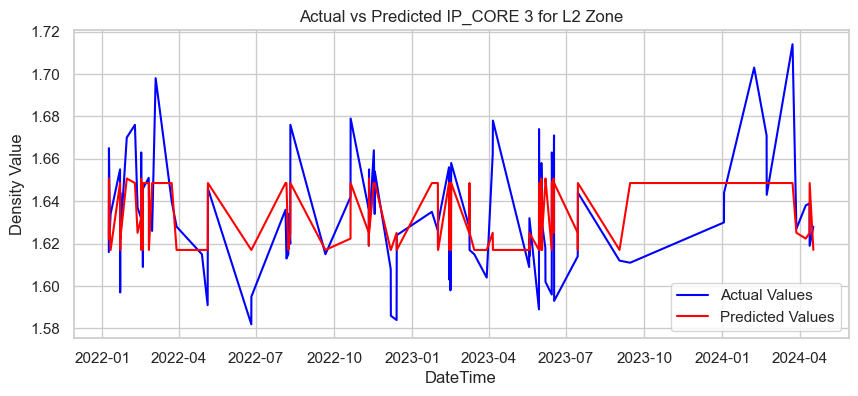

Before tuning:

R2 Value: 0.8978
RMSE Value: 0.0071
MAPE Value: 1.3735
R2 Value: -0.2591
RMSE Value: 0.0227
MAPE Value: 1.4492
GradientBoostingRegressor(learning_rate=0.0012, max_depth=1,
                          min_samples_leaf=17, min_samples_split=8,
                          min_weight_fraction_leaf=0.3333333333333333,
                          n_estimators=200, warm_start=True)

After tuning:

R2 Value: 0.0495
RMSE Value: 0.0197
MAPE Value: 0.9795

Final results

R2 Value: 0.0355
RMSE Value: 0.0217
MAPE Value: 1.1312
R2 Value: 0.0495
RMSE Value: 0.0197
MAPE Value: 0.9795
R2 Value: -0.0059
RMSE Value: 0.0262
MAPE Value: 1.1346


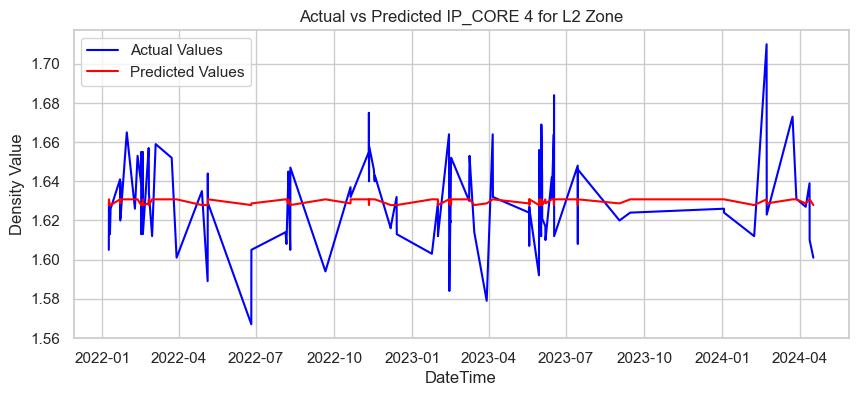

In [64]:
dict = [
    (l1_1['L1 Zone 0'], l1_1['IP_CORE1']),
    (l1_1['L1 Zone 1-4 Avg'], l1_1['IP_CORE2']),
    (l1_1['L1 Zone 5-8 Avg'], l1_1['IP_CORE3']),
    (l1_1['L1 Zone 9'], l1_1['IP_CORE4']),
]

dates_combined = l1_1['DateTime']

combined_actual_core1 = []
combined_predicted_core1 = []
combined_actual_core2 = []
combined_predicted_core2 = []
combined_actual_core3 = []
combined_predicted_core3 = []
combined_actual_core4 = []
combined_predicted_core4 = []

for i, (zone, core) in enumerate(dict):
    y_pred_train, y_train, y_pred_val, y_val, y_pred_test, y_test = pipeline(zone.values.reshape(-1, 1), core.values.reshape(-1, 1))
    y_actual_combined = np.concatenate([y_train, y_val, y_test])
    y_pred_combined = np.concatenate([y_pred_train, y_pred_val, y_pred_test])
    
    if i == 0:
        combined_actual_core1.extend(y_actual_combined)
        combined_predicted_core1.extend(y_pred_combined)
    elif i == 1:
        combined_actual_core2.extend(y_actual_combined)
        combined_predicted_core2.extend(y_pred_combined)
    elif i == 2:
        combined_actual_core3.extend(y_actual_combined)
        combined_predicted_core3.extend(y_pred_combined)
    elif i == 3:
        combined_actual_core4.extend(y_actual_combined)
        combined_predicted_core4.extend(y_pred_combined)
    
    plot_predictions(dates_combined, y_actual_combined, y_pred_combined, f'Actual vs Predicted IP_CORE {i+1} for L2 Zone')

# Create a new DataFrame
results_df = pd.DataFrame({
    'DateTime': dates_combined,
    'Actual_IP_CORE1': combined_actual_core1,
    'Predicted_IP_CORE1': combined_predicted_core1,
    'Actual_IP_CORE2': combined_actual_core2,
    'Predicted_IP_CORE2': combined_predicted_core2,
    'Actual_IP_CORE3': combined_actual_core3,
    'Predicted_IP_CORE3': combined_predicted_core3,
    'Actual_IP_CORE4': combined_actual_core4,
    'Predicted_IP_CORE4': combined_predicted_core4,
})

results_df.to_excel('l1_final_predicted.xlsx', index=False)

Before tuning:

R2 Value: 0.3936
RMSE Value: 0.0218
MAPE Value: 1.4062
R2 Value: 0.0040
RMSE Value: 0.0259
MAPE Value: 1.2749
GradientBoostingRegressor(learning_rate=0.07412244897959185, max_depth=1,
                          min_samples_leaf=7, n_estimators=50)

After tuning:

R2 Value: 0.0739
RMSE Value: 0.0250
MAPE Value: 1.2220

Final results

R2 Value: 0.1065
RMSE Value: 0.0265
MAPE Value: 1.3377
R2 Value: 0.1079
RMSE Value: 0.0245
MAPE Value: 1.2234
R2 Value: 0.1701
RMSE Value: 0.0210
MAPE Value: 1.2046


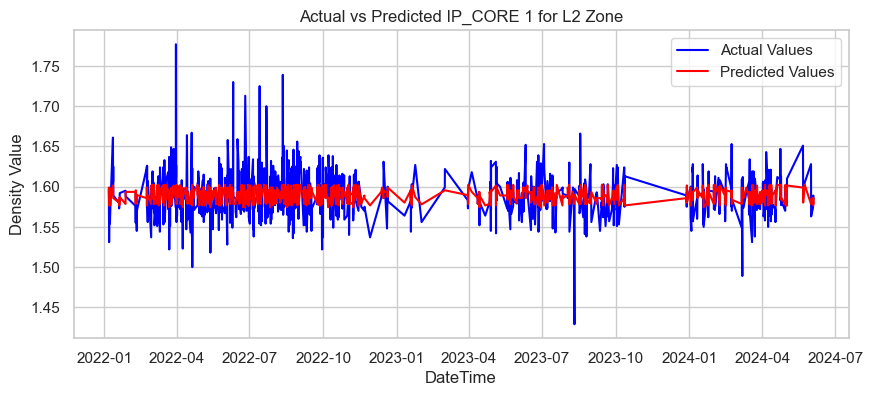

Before tuning:

R2 Value: 0.6514
RMSE Value: 0.0202
MAPE Value: 1.4151
R2 Value: -0.1396
RMSE Value: 0.0325
MAPE Value: 1.4651
GradientBoostingRegressor(learning_rate=0.3348244897959184, max_depth=11,
                          min_samples_leaf=17, min_samples_split=4,
                          min_weight_fraction_leaf=0.18333333333333335,
                          n_estimators=10)

After tuning:

R2 Value: -0.0026
RMSE Value: 0.0305
MAPE Value: 1.3675

Final results

R2 Value: 0.0270
RMSE Value: 0.0337
MAPE Value: 1.2949
R2 Value: 0.0305
RMSE Value: 0.0300
MAPE Value: 1.3675
R2 Value: 0.0124
RMSE Value: 0.0239
MAPE Value: 1.1924


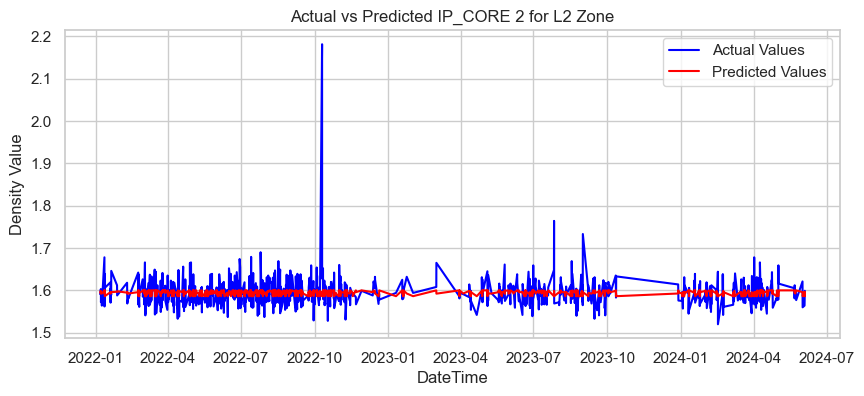

Before tuning:

R2 Value: 0.3071
RMSE Value: 0.0190
MAPE Value: 1.1764
R2 Value: -0.0886
RMSE Value: 0.0204
MAPE Value: 1.0093
GradientBoostingRegressor(learning_rate=0.4655755102040816, min_samples_leaf=13,
                          min_samples_split=16,
                          min_weight_fraction_leaf=0.2222222222222222,
                          n_estimators=10)

After tuning:

R2 Value: -0.0446
RMSE Value: 0.0200
MAPE Value: 0.9715

Final results

R2 Value: 0.0477
RMSE Value: 0.0223
MAPE Value: 1.1361
R2 Value: 0.0167
RMSE Value: 0.0194
MAPE Value: 0.9642
R2 Value: -0.0109
RMSE Value: 0.0372
MAPE Value: 1.2912


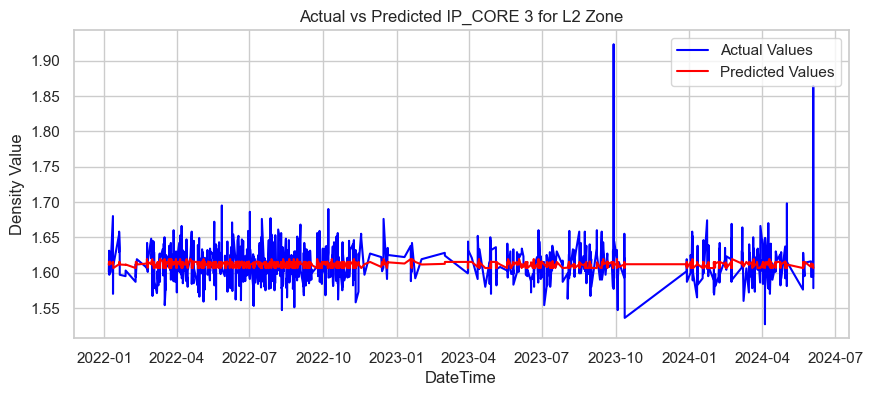

Before tuning:

R2 Value: 0.3634
RMSE Value: 0.0180
MAPE Value: 1.1729
R2 Value: -0.0379
RMSE Value: 0.0231
MAPE Value: 1.1498
GradientBoostingRegressor(learning_rate=0.04153469387755102, max_depth=17,
                          min_samples_leaf=7, min_samples_split=10,
                          min_weight_fraction_leaf=0.3333333333333333,
                          n_estimators=160, warm_start=True)

After tuning:

R2 Value: 0.0529
RMSE Value: 0.0220
MAPE Value: 1.0880

Final results

R2 Value: 0.0567
RMSE Value: 0.0219
MAPE Value: 1.1225
R2 Value: 0.0529
RMSE Value: 0.0220
MAPE Value: 1.0880
R2 Value: 0.0325
RMSE Value: 0.0257
MAPE Value: 1.1876


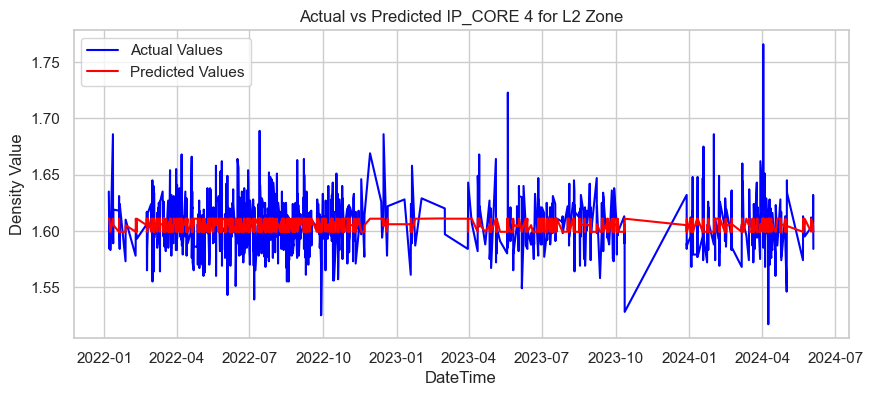

In [66]:
dict = [
    (l2_1['L2 Zone 0'], l2_1['IP_CORE1']),
    (l2_1['L2 Zone 1-4 Avg'], l2_1['IP_CORE2']),
    (l2_1['L2 Zone 5-8 Avg'], l2_1['IP_CORE3']),
    (l2_1['L2 Zone 9'], l2_1['IP_CORE4']),
]

dates_combined = l2_1['DateTime']

combined_actual_core1 = []
combined_predicted_core1 = []
combined_actual_core2 = []
combined_predicted_core2 = []
combined_actual_core3 = []
combined_predicted_core3 = []
combined_actual_core4 = []
combined_predicted_core4 = []

for i, (zone, core) in enumerate(dict):
    y_pred_train, y_train, y_pred_val, y_val, y_pred_test, y_test = pipeline(zone.values.reshape(-1, 1), core.values.reshape(-1, 1))
    y_actual_combined = np.concatenate([y_train, y_val, y_test])
    y_pred_combined = np.concatenate([y_pred_train, y_pred_val, y_pred_test])
    
    if i == 0:
        combined_actual_core1.extend(y_actual_combined)
        combined_predicted_core1.extend(y_pred_combined)
    elif i == 1:
        combined_actual_core2.extend(y_actual_combined)
        combined_predicted_core2.extend(y_pred_combined)
    elif i == 2:
        combined_actual_core3.extend(y_actual_combined)
        combined_predicted_core3.extend(y_pred_combined)
    elif i == 3:
        combined_actual_core4.extend(y_actual_combined)
        combined_predicted_core4.extend(y_pred_combined)
    
    plot_predictions(dates_combined, y_actual_combined, y_pred_combined, f'Actual vs Predicted IP_CORE {i+1} for L2 Zone')

# Create a new DataFrame
results_df = pd.DataFrame({
    'DateTime': dates_combined,
    'Actual_IP_CORE1': combined_actual_core1,
    'Predicted_IP_CORE1': combined_predicted_core1,
    'Actual_IP_CORE2': combined_actual_core2,
    'Predicted_IP_CORE2': combined_predicted_core2,
    'Actual_IP_CORE3': combined_actual_core3,
    'Predicted_IP_CORE3': combined_predicted_core3,
    'Actual_IP_CORE4': combined_actual_core4,
    'Predicted_IP_CORE4': combined_predicted_core4,
})

results_df.to_excel('l2_final_predicted.xlsx', index=False)


# Hypertuning RFR

In [67]:
def pipeline(X, y):

    model = RandomForestRegressor()
    
    X_remaining, X_train, X_val, X_test, y_remaining, y_train, y_val, y_test = train_val_test_split(scaler, X, y)
    model.fit(X_train, y_train)
   
    print('Before tuning:\n')
    check_result(model, X_train, y_train)
    check_result(model, X_val, y_val)

    tuned_model = hypertune_model(model, X_train, y_train)
    print(tuned_model)
    print('\nAfter tuning:\n')
    check_result(tuned_model, X_val, y_val)
    
    tuned_model.fit(X_remaining, y_remaining)
    print('\nFinal results\n')
    y_pred_train = check_result(tuned_model, X_train, y_train)
    y_pred_val = check_result(tuned_model, X_val, y_val)
    y_pred_test = check_result(tuned_model, X_test, y_test)
    
    return y_pred_train, y_train, y_pred_val, y_val,y_pred_test, y_test
    # return tuned_model   

In [68]:
def hypertune_model(model, X_train, y_train):
    # Define the hyperparameter grid for RandomSearchCV
    param_dist = {
        'n_estimators': np.arange(11, 200, 10),
        'max_depth': np.arange(3, 21, 2),
        'min_samples_split': np.arange(4, 21, 2),
        'min_samples_leaf': np.arange(3, 21, 2),
        'bootstrap': [True, False],
        # 'max_leaf_nodes': np.arange(20, 200, 10),
        
    }
    
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=0)
    random_search.fit(X_train, y_train)
    best_random_params = random_search.best_params_
    
    # print(f"Best parameters from RandomSearchCV: {best_random_params}")

    param_grid = {
        'n_estimators': [best_random_params['n_estimators'] - 10, best_random_params['n_estimators'], best_random_params['n_estimators'] + 10],
        'max_depth': [best_random_params['max_depth'] - 2, best_random_params['max_depth'], best_random_params['max_depth'] + 2],
        'min_samples_split': [best_random_params['min_samples_split'] - 2, best_random_params['min_samples_split'], best_random_params['min_samples_split'] + 2],
        'min_samples_leaf': [best_random_params['min_samples_leaf'] - 2, best_random_params['min_samples_leaf'], best_random_params['min_samples_leaf'] + 2],
        'bootstrap': [best_random_params['bootstrap']],
        # 'max_leaf_nodes': [best_random_params['max_leaf_nodes'] - 10, best_random_params['max_leaf_nodes'], best_random_params['max_leaf_nodes'] + 10],
    
    }
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_grid_params = grid_search.best_params_
    
    # print(f"Best parameters from GridSearchCV: {best_grid_params}")
    # print(grid_search.best_estimator_)
    return grid_search.best_estimator_

Before tuning:

R2 Value: 0.8711
RMSE Value: 0.0090
MAPE Value: 1.6097
R2 Value: -1.2770
RMSE Value: 0.0371
MAPE Value: 1.6916
RandomForestRegressor(max_depth=17, min_samples_leaf=3, min_samples_split=6,
                      n_estimators=91)

After tuning:

R2 Value: -0.3796
RMSE Value: 0.0288
MAPE Value: 1.4299

Final results

R2 Value: 0.4863
RMSE Value: 0.0180
MAPE Value: 1.4322
R2 Value: 0.1423
RMSE Value: 0.0227
MAPE Value: 1.3446
R2 Value: -0.1606
RMSE Value: 0.0301
MAPE Value: 1.5117


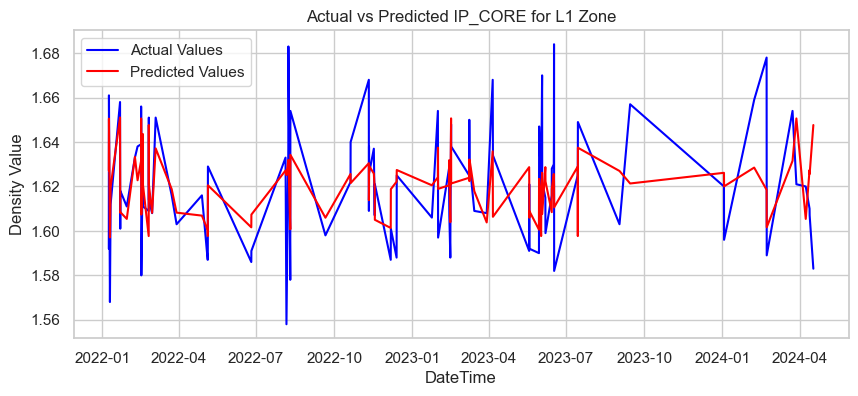

Before tuning:

R2 Value: 0.7917
RMSE Value: 0.0112
MAPE Value: 1.4521
R2 Value: 0.2309
RMSE Value: 0.0196
MAPE Value: 1.2815
RandomForestRegressor(max_depth=3, min_samples_leaf=17, min_samples_split=22,
                      n_estimators=91)

After tuning:

R2 Value: -0.0410
RMSE Value: 0.0228
MAPE Value: 1.2604

Final results

R2 Value: 0.1759
RMSE Value: 0.0223
MAPE Value: 1.2718
R2 Value: 0.0201
RMSE Value: 0.0222
MAPE Value: 1.2548
R2 Value: 0.1371
RMSE Value: 0.0249
MAPE Value: 1.4016


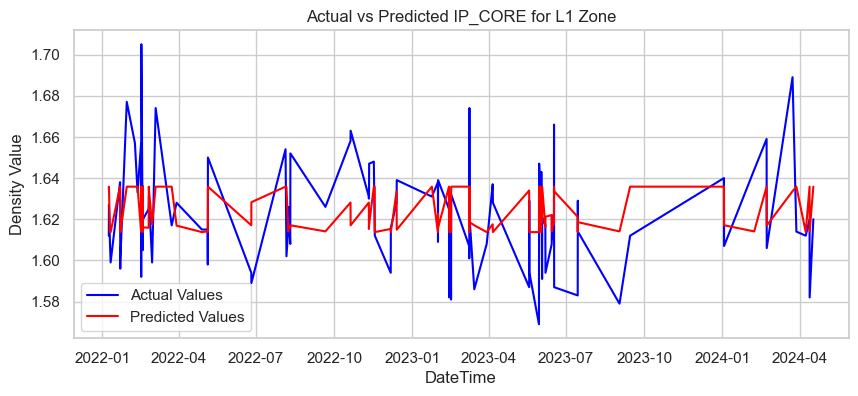

Before tuning:

R2 Value: 0.8455
RMSE Value: 0.0094
MAPE Value: 1.4786
R2 Value: -0.0956
RMSE Value: 0.0255
MAPE Value: 1.6184
RandomForestRegressor(bootstrap=False, max_depth=3, min_samples_leaf=11,
                      min_samples_split=14, n_estimators=21)

After tuning:

R2 Value: 0.0138
RMSE Value: 0.0242
MAPE Value: 1.4041

Final results

R2 Value: 0.3328
RMSE Value: 0.0195
MAPE Value: 1.3586
R2 Value: 0.4293
RMSE Value: 0.0184
MAPE Value: 1.3360
R2 Value: 0.3120
RMSE Value: 0.0253
MAPE Value: 1.5778


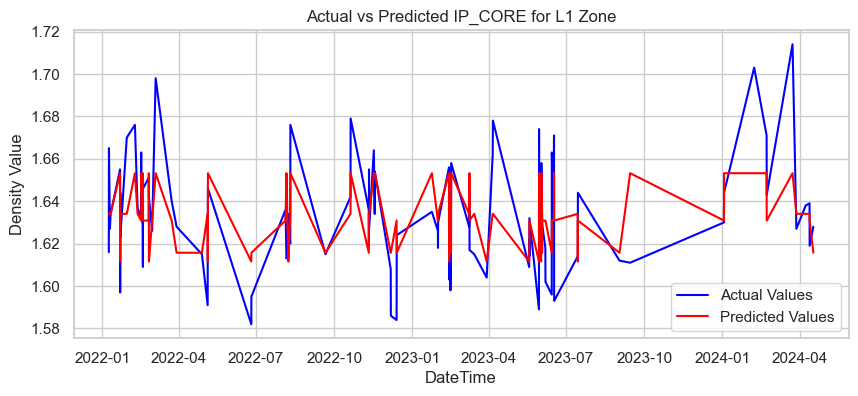

Before tuning:

R2 Value: 0.8108
RMSE Value: 0.0096
MAPE Value: 1.3377
R2 Value: -0.4655
RMSE Value: 0.0245
MAPE Value: 1.4168
RandomForestRegressor(max_depth=5, min_samples_leaf=17, min_samples_split=18,
                      n_estimators=91)

After tuning:

R2 Value: 0.1687
RMSE Value: 0.0184
MAPE Value: 1.0549

Final results

R2 Value: 0.1004
RMSE Value: 0.0210
MAPE Value: 1.1709
R2 Value: 0.1796
RMSE Value: 0.0183
MAPE Value: 1.0651
R2 Value: 0.1447
RMSE Value: 0.0242
MAPE Value: 1.2043


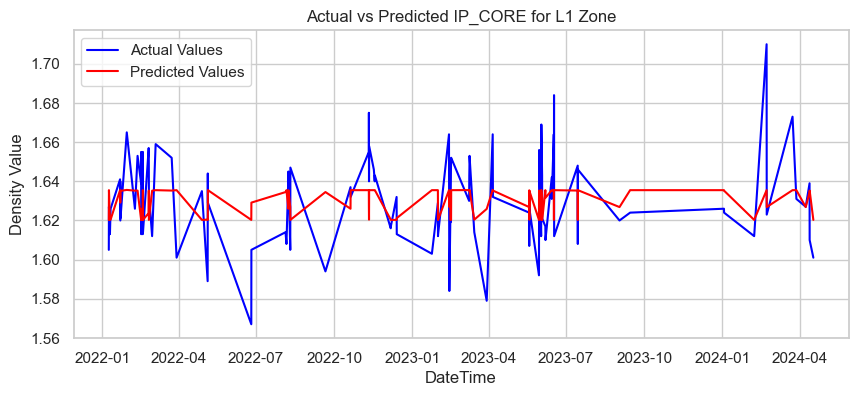

In [69]:
dict = [
    (l1_2['L1 Zone 0'],l1_2['IP_CORE1']),
    (l1_2['L1 Zone 2'],l1_2['IP_CORE2']),
    (l1_2['L1 Zone 6'],l1_2['IP_CORE3']),
    (l1_2['L1 Zone 9'],l1_2['IP_CORE4']),
]
dates_combined = l1_2['DateTime']
for (zone, core) in dict:
    y_pred_train, y_train, y_pred_val, y_val,y_pred_test, y_test  = pipeline(zone.values.reshape(-1,1), core.values.reshape(-1,1))
    y_actual_combined = np.concatenate([y_train, y_val, y_test])
    y_pred_combined = np.concatenate([y_pred_train, y_pred_val, y_pred_test])

    plot_predictions(dates_combined, y_actual_combined, y_pred_combined, 'Actual vs Predicted IP_CORE for L1 Zone')

Before tuning:

R2 Value: 0.8014
RMSE Value: 0.0125
MAPE Value: 1.6007
R2 Value: -0.3031
RMSE Value: 0.0296
MAPE Value: 1.5452
RandomForestRegressor(max_depth=1, min_samples_leaf=13, min_samples_split=12,
                      n_estimators=181)

After tuning:

R2 Value: 0.0933
RMSE Value: 0.0247
MAPE Value: 1.2073

Final results

R2 Value: 0.0859
RMSE Value: 0.0268
MAPE Value: 1.3285
R2 Value: 0.1103
RMSE Value: 0.0245
MAPE Value: 1.2136
R2 Value: 0.1639
RMSE Value: 0.0211
MAPE Value: 1.1946


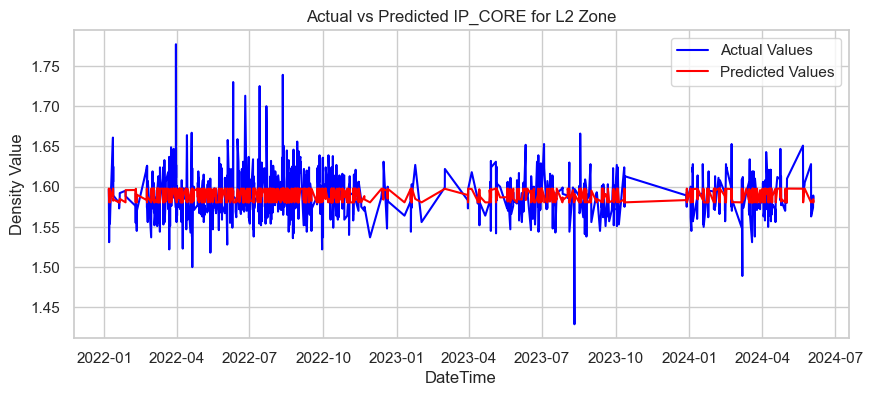

Before tuning:

R2 Value: 0.8132
RMSE Value: 0.0148
MAPE Value: 1.6074
R2 Value: -0.4967
RMSE Value: 0.0373
MAPE Value: 1.6557
RandomForestRegressor(max_depth=9, min_samples_leaf=21, min_samples_split=6,
                      n_estimators=131)

After tuning:

R2 Value: -0.0511
RMSE Value: 0.0312
MAPE Value: 1.3880

Final results

R2 Value: 0.0587
RMSE Value: 0.0332
MAPE Value: 1.3167
R2 Value: 0.0485
RMSE Value: 0.0297
MAPE Value: 1.3867
R2 Value: -0.0023
RMSE Value: 0.0240
MAPE Value: 1.2168


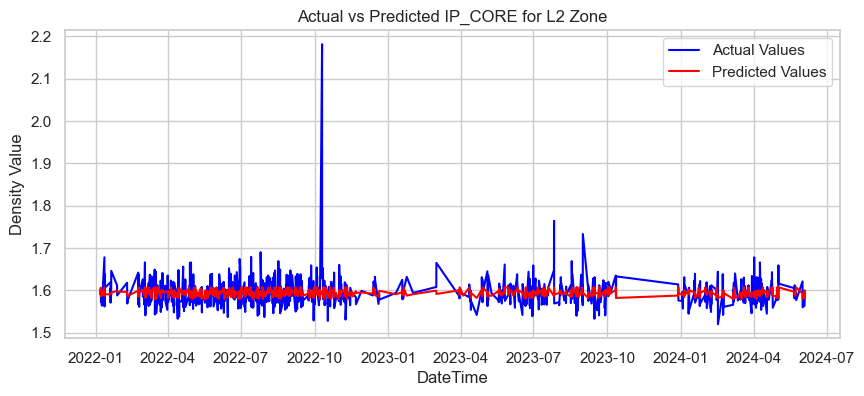

Before tuning:

R2 Value: 0.7843
RMSE Value: 0.0106
MAPE Value: 1.3580
R2 Value: -0.3624
RMSE Value: 0.0228
MAPE Value: 1.1851
RandomForestRegressor(max_depth=1, min_samples_leaf=13, min_samples_split=12,
                      n_estimators=191)

After tuning:

R2 Value: -0.0141
RMSE Value: 0.0197
MAPE Value: 0.9676

Final results

R2 Value: 0.0363
RMSE Value: 0.0224
MAPE Value: 1.1352
R2 Value: 0.0027
RMSE Value: 0.0195
MAPE Value: 0.9628
R2 Value: -0.0023
RMSE Value: 0.0371
MAPE Value: 1.2909


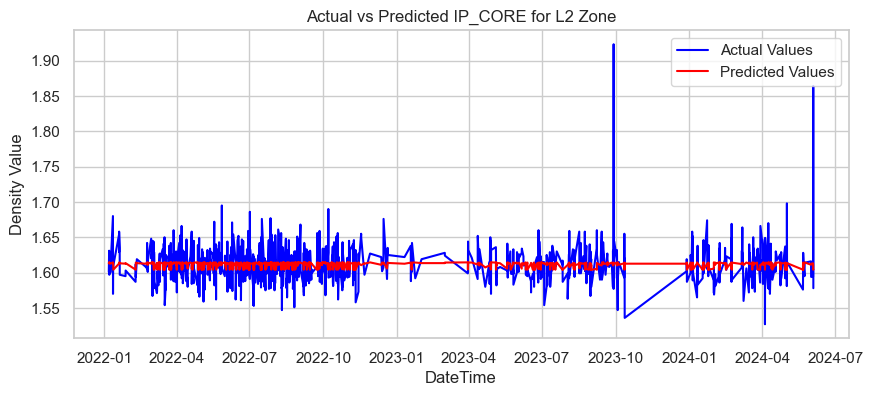

Before tuning:

R2 Value: 0.8079
RMSE Value: 0.0099
MAPE Value: 1.3512
R2 Value: -0.2133
RMSE Value: 0.0249
MAPE Value: 1.2755
RandomForestRegressor(max_depth=1, min_samples_leaf=11, min_samples_split=8,
                      n_estimators=151)

After tuning:

R2 Value: 0.0572
RMSE Value: 0.0220
MAPE Value: 1.0816

Final results

R2 Value: 0.0497
RMSE Value: 0.0220
MAPE Value: 1.1203
R2 Value: 0.0692
RMSE Value: 0.0218
MAPE Value: 1.0843
R2 Value: 0.0272
RMSE Value: 0.0258
MAPE Value: 1.1857


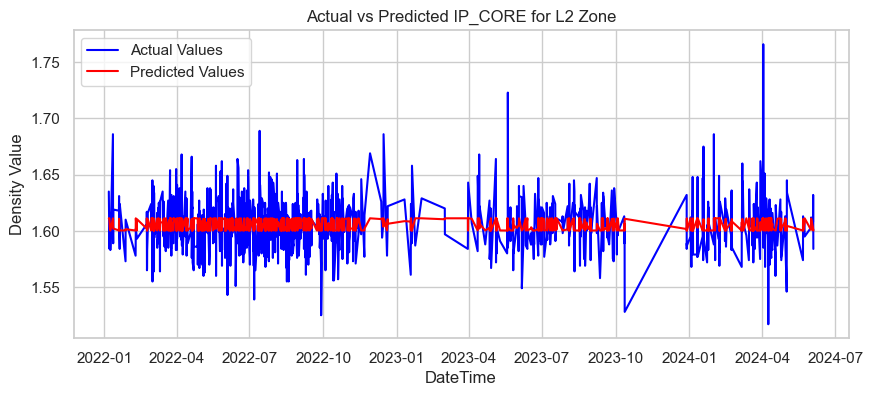

In [70]:
dict = [
    (l2_1['L2 Zone 0'],l2_1['IP_CORE1']),
    (l2_1['L2 Zone 1-4 Avg'],l2_1['IP_CORE2']),
    (l2_1['L2 Zone 5-8 Avg'],l2_1['IP_CORE3']),
    (l2_1['L2 Zone 9'],l2_1['IP_CORE4']),
]
dates_combined = l2_1['DateTime']
for (zone, core) in dict:
    y_pred_train, y_train, y_pred_val, y_val,y_pred_test, y_test  = pipeline(zone.values.reshape(-1,1), core.values.reshape(-1,1))
    y_actual_combined = np.concatenate([y_train, y_val, y_test])
    y_pred_combined = np.concatenate([y_pred_train, y_pred_val, y_pred_test])

    plot_predictions(dates_combined, y_actual_combined, y_pred_combined, 'Actual vs Predicted IP_CORE for L2 Zone')